In [194]:
import scanpy as sc
import pandas as pd 
import numpy as np
import anndata as ad
import re
import scipy.sparse as scs
import concurrent.futures
import scanpy.external as sce
from concurrent.futures import ProcessPoolExecutor
import copy
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import warnings
from matplotlib.lines import Line2D
from matplotlib import cm
import math
from pathlib import Path

# Suppress all warnings
warnings.filterwarnings('ignore')
import math
import decoupler as dc

### START

In [2]:
%%time
AIFI_reference=sc.read_h5ad("cache/1c60f7d8-0e93-4359-bb0f-d36a79bb77d2/AIFI_Reference_processed.h5ad")

CPU times: user 11.2 s, sys: 42.8 s, total: 54 s
Wall time: 8min 33s


In [3]:
B_cell = AIFI_reference[AIFI_reference.obs['AIFI_L1'].isin(['B cell'])]
B_cell.write('B_cell_files/B_cell_AIFI_cross.h5ad')

In [14]:
AIFI_reference

AnnData object with n_obs × n_vars = 1828803 × 1351
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'subject.biologicalSex', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 'sample.visitDetails', 'subject.birthYear', 'CMV.IgG.Serology.Result.Interpretation', 'BMI', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'predicted.celltype.l2.5.score', 'predicted.celltype.l2.5', 'predicted_labels_celltypist', 'majority_voting_celltypist', 'predicted_doublet', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top

In [15]:
adata = AIFI_reference

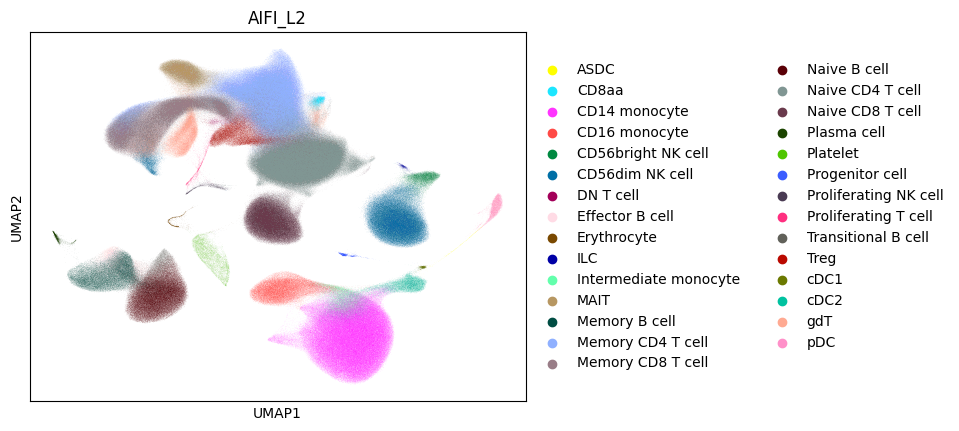

In [16]:
sc.pl.umap(adata, color = ["AIFI_L2"])

In [17]:
adata=adata.raw.to_adata()

In [18]:
adata.raw=adata

In [19]:
AIFI_reference = adata

In [20]:
AIFI_reference

AnnData object with n_obs × n_vars = 1828803 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'subject.biologicalSex', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 'sample.visitDetails', 'subject.birthYear', 'CMV.IgG.Serology.Result.Interpretation', 'BMI', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'predicted.celltype.l2.5.score', 'predicted.celltype.l2.5', 'predicted_labels_celltypist', 'majority_voting_celltypist', 'predicted_doublet', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_to

In [23]:
#do psuedobulk. no need to run this again. this was done on L2
# Store raw counts in layers
AIFI_reference.X = np.round(AIFI_reference.X).astype(np.int_)
AIFI_reference.layers['counts'] = AIFI_reference.X

# Normalize and log-transform
sc.pp.normalize_total(AIFI_reference, target_sum=1e4)
sc.pp.log1p(AIFI_reference)
AIFI_reference.layers['normalized'] = AIFI_reference.X

In [24]:
%%time
pdata = dc.get_pseudobulk(
    AIFI_reference,
    sample_col='subject.subjectGuid',
    groups_col='AIFI_L2',
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=1000
)
pdata

pdata.obs['subject.birthYear'] = pdata.obs['subject.birthYear'].astype(str)
pdata.obs['predicted_doublet'] = pdata.obs['predicted_doublet'].astype(str)

pdata.write('psuedobulk/AIFI_L2_psb.h5ad')

CPU times: user 4min 45s, sys: 2min 48s, total: 7min 33s
Wall time: 7min 44s


In [46]:
subset_data = AIFI_reference[AIFI_reference.obs['AIFI_L3'] == 'Core naive CD4 T cell']
#subset_data = AIFI_reference[AIFI_reference.obs['AIFI_L3'] == 'CLP cell']

In [47]:
subset_data

View of AnnData object with n_obs × n_vars = 352699 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'subject.biologicalSex', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 'sample.visitDetails', 'subject.birthYear', 'CMV.IgG.Serology.Result.Interpretation', 'BMI', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'predicted.celltype.l2.5.score', 'predicted.celltype.l2.5', 'predicted_labels_celltypist', 'majority_voting_celltypist', 'predicted_doublet', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_count

In [293]:
usp10_index = subset_data.var.index.get_loc("ID2")

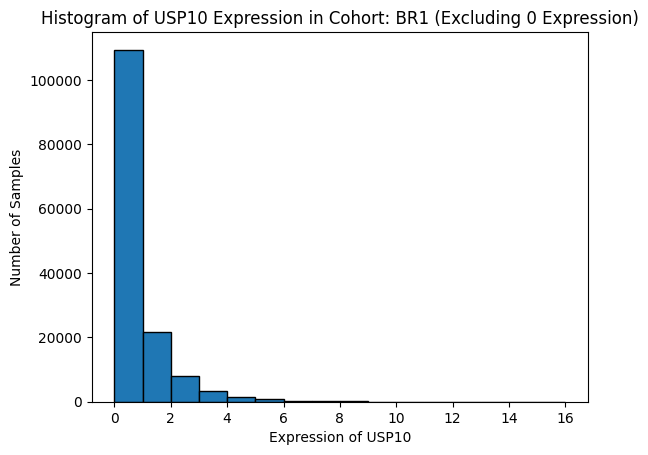

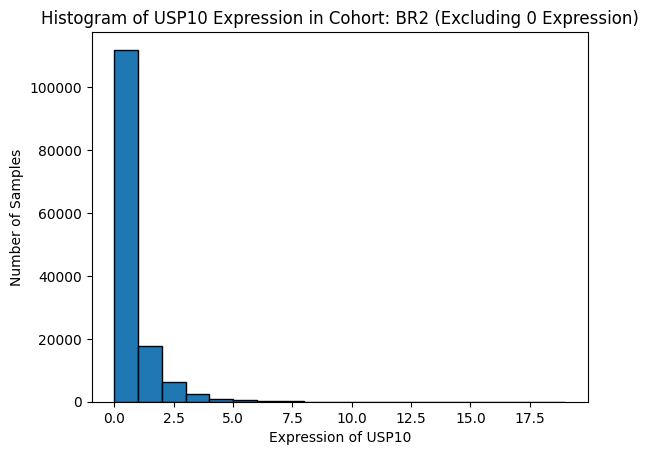

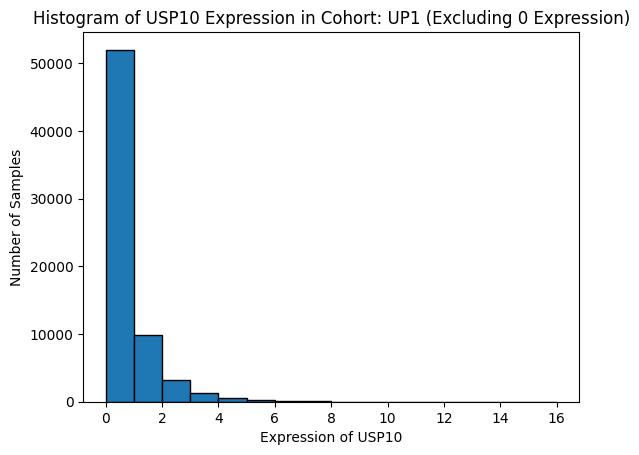

CPU times: user 4.48 s, sys: 2.7 s, total: 7.18 s
Wall time: 6.61 s


In [294]:
%%time

# Step 2: Extract the expression data for "USP10" and convert to DataFrame
usp10_expression = pd.DataFrame(subset_data.X[:, usp10_index].toarray() if hasattr(subset_data.X, "toarray") else subset_data.X[:, usp10_index], 
                                index=subset_data.obs.index)

# Step 3: Add the cohort information to this DataFrame
usp10_expression_with_cohort = usp10_expression.join(adata.obs['cohort.cohortGuid'])

# Step 4: Plot separate histograms for each cohort
cohorts = usp10_expression_with_cohort['cohort.cohortGuid'].unique()

for cohort in cohorts:
    plt.figure()
    cohort_expression = usp10_expression_with_cohort[usp10_expression_with_cohort['cohort.cohortGuid'] == cohort]    
    # Determine the range for bins
    min_exp, max_exp = int(cohort_expression[0].min()), int(cohort_expression[0].max())
    bins = np.arange(min_exp, max_exp + 1, 1)  # Creating integer bins

    plt.hist(cohort_expression[0], bins=bins, edgecolor='k')
    plt.xlabel('Expression of USP10')
    plt.ylabel('Number of Samples')
    plt.title(f'Histogram of USP10 Expression in Cohort: {cohort} (Excluding 0 Expression)')
    plt.show()

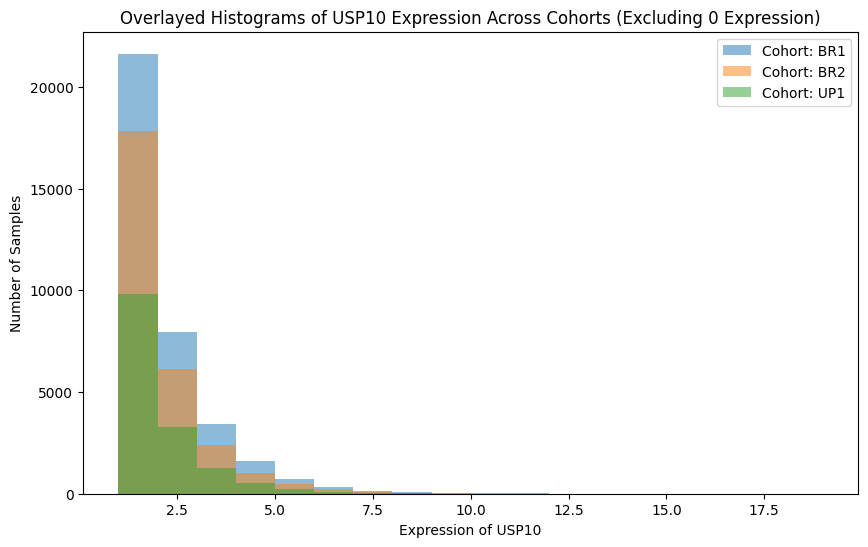

CPU times: user 350 ms, sys: 80.3 ms, total: 430 ms
Wall time: 237 ms


In [295]:
%%time

# Step 4: Overlay histograms for each cohort in a single plot
cohorts = usp10_expression_with_cohort['cohort.cohortGuid'].unique()
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

for cohort in cohorts:
    cohort_expression = usp10_expression_with_cohort[usp10_expression_with_cohort['cohort.cohortGuid'] == cohort]
    # Filtering out cells with 0 expression
    cohort_expression_non_zero = cohort_expression[cohort_expression[0] > 0]
    
    # Determine the range for bins
    min_exp, max_exp = int(cohort_expression_non_zero[0].min()), int(cohort_expression_non_zero[0].max())
    bins = np.arange(min_exp, max_exp + 1, 1)  # Creating integer bins

    # Plot histogram with opacity (alpha) for visibility
    plt.hist(cohort_expression_non_zero[0], bins=bins, alpha=0.5, label=f'Cohort: {cohort}')

plt.xlabel('Expression of USP10')
plt.ylabel('Number of Samples')
plt.title('Overlayed Histograms of USP10 Expression Across Cohorts (Excluding 0 Expression)')
plt.legend()
plt.show()

In [48]:
%%time

# List of genes for DNAm_Tcell_UP
#genes_of_interest = ['CYFIP1', 'DST', 'GLO1', 'TIPARP', 'PDLIM5', 'DGKI','CD274', 'PTPRK', 'MCAM', 'GALC', 'ATPAF1', 'SLCO3A1', 'ZNF597', 'PLK2', 'RHBDD1', 'PRPF8', 'KLF2', 'E2F2', 'DOCK9', 'ARHGEF18', 'FAM50B', 'ZNF287', 'ZHX1', 'ELAC2', 'GRWD1', 'PRKG2', 'MAP3K5', 'ADHFE1', 'USP10', 'MIB1', 'CBX7', 'AKT3', 'B3GALT6', 'UROS', 'MAPKAP1', 'SSRP1', 'MRPL38', 'KPNA1', 'ABHD14A', 'ARSG','NAT10', 'ZNF219', 'RPL31', 'LGALS1']

#genes_of_interest = ['YPEL1','SYNE1','CENPF','MGAT5','PTGER2','ZBTB16','IL6ST','CHI3L2','FAM3C','SNX9','RASSF5','GLB1','DEPDC1','LTBP3','RXRA','PLK1','EDARADD','CDCA2','LAG3','GPR68','CCNF','ZNF70','HOXB4','ALOX12','SFMBT1','CEBPD','LZTFL1','SLC14A1','VPS18','LOXL2','BAZ2A','MPP6','SOAT1','ALKBH3','DDAH2','WFS1','UBE2V1','SNX8','C9orf64','TBC1D23','DNASE2','DPP8','FES','BIRC2','AFF1','ACOX1','ST3GAL4','PAPOLG','HMG20B','ABTB1']
#for DNAm gene signatures of interest
#genes_of_interest = ['USP10', 'LGALS1', 'PRPF8', 'MAP3K5', 'ABHD14A', 'SLCO3A1']

#for KRAS in CLP cells
#genes_of_interest = ['ANGPTL4','ITGA2','SPRY2','HBEGF','RBP4','HSD11B1','ETV4','GLRX','DUSP6','SCG5','ETV5','ITGB2','AKT2','PPBP','G0S2','GABRA3','IRF8','BIRC3','FGF9','DCBLD2','INHBA','TFPI','TSPAN1','ADAM8','SLPI','PRKG2','MMP11','MMP10','TMEM158','TNFAIP3','PRDM1','GALNT3','ETS1','MMP9','WNT7A','IGFBP3','SPP1','ETV1','CLEC4A','CCND2','TSPAN7','ITGBL1','EMP1','CDADC1','KIF5C','TRIB2','SDCCAG8','PCP4','CFHR2','ALDH1A2','NR0B2','ALDH1A3','AMMECR1','SATB1','GUCY1A1','CSF2','APOD','TOR1AIP2','CMKLR1','TMEM176B','ADGRA2','LAPTM5','CD37','CAB39L','CIDEA','ZNF639','IL1B','GYPC','LY96','FLT4','SPON1','BMP2','PLEK2','IGF2','NR1H4','SNAP25','ACE','PRRX1','C3AR1','TRAF1','TLR8','ID2','TMEM100','PLAUR','GADD45G','CBX8','SCN1B','PTBP2','NAP1L2','AKAP12','PLAT','SCG3','ANO1','IL1RL2','CXCL10','ATG10','YRDC','HDAC9','PEG3','SEMA3B','TNNT2','LIF','CFB','BTC','PPP1R15A','PTPRR','CCL20','ARG1','RETN','KLF4','MMD','PDCD1LG2','HOXD11','TRIB1','F2RL1','ANXA10','TSPAN13','MTMR10','CFH','LAT2','ERO1A','RELN','KCNN4','TMEM176A','MAP4K1','PTGS2','IL33','MAFB','LCP1','NGF','CA2','SERPINA3','RGS16','CTSS','USP12','CPE','SPARCL1','ABCB1','USH1C','CSF2RA','BTBD3','IL2RG','DNMBP','IL10RA','EREG','PRELID3B','EPHB2','FBXO4','CROT','MPZL2','ANKH','CBR4','DOCK2','GPRC5B','RABGAP1L','MALL','STRN','ST6GAL1','PIGR','VWA5A','PSMB8','F13A1','NRP1','SOX9','JUP','ADGRL4','ZNF277','EPB41L3','PCSK1N','FUCA1','PLVAP','ADAM17','AVL9','ADAMDEC1','HKDC1','MAP7','IL7R','RBM4','BPGM','ENG','GFPT2','PLAU','GNG11','PTCD2','MAP3K1','CBL','CXCR4','NIN','IKZF1','WDR33','MYCN','FCER1G','PECAM1','CCSER2','SNAP91','EVI5','TNFRSF1B','GPNMB','TPH1']
genes_of_interest = ['EBF1', 'FLT3', 'GATA3', 'GFI1', 'IKZF1', 'MYB', 'SPI1', 'TCF3', 'CEBPA', 'GATA1', 'ID2']


# Subset the data based on genes of interest
subset_data_genes_of_interest = subset_data[:, subset_data.var_names.isin(genes_of_interest)].copy()

# Extract the subject and cohort information
subject_cohort_info = subset_data.obs[['subject.subjectGuid', 'cohort.cohortGuid', 'subject.biologicalSex', 'CMV.IgG.Serology.Result.Interpretation']]

# Convert gene expression matrix to pandas DataFrame
expression_df = pd.DataFrame(subset_data_genes_of_interest.X.toarray(), 
                             columns=subset_data_genes_of_interest.var_names, 
                             index=subset_data.obs_names)

# Concatenate subject and cohort information with gene expression
full_data = pd.concat([subject_cohort_info, expression_df], axis=1)

def aggregate_data(df, genes_list):
    # For gene expression data, calculate the mean using the provided list of genes
    avg_gene_expression = df[genes_list].mean()
    # Retain the first instance of cohort and other details
    first_cohort = pd.Series(df['cohort.cohortGuid'].iloc[0], index=['cohort.cohortGuid'])
    first_CMV = pd.Series(df['CMV.IgG.Serology.Result.Interpretation'].iloc[0], index=['CMV.IgG.Serology.Result.Interpretation'])
    first_biol_sex = pd.Series(df['subject.biologicalSex'].iloc[0], index=['subject.biologicalSex'])
    return pd.concat([first_cohort, first_CMV, first_biol_sex, avg_gene_expression])

## Apply the aggregate function to each group with the current genes_of_interest
aggregated_data = full_data.groupby('subject.subjectGuid').apply(lambda x: aggregate_data(x, genes_of_interest))

CPU times: user 7.09 s, sys: 4.3 s, total: 11.4 s
Wall time: 11.4 s


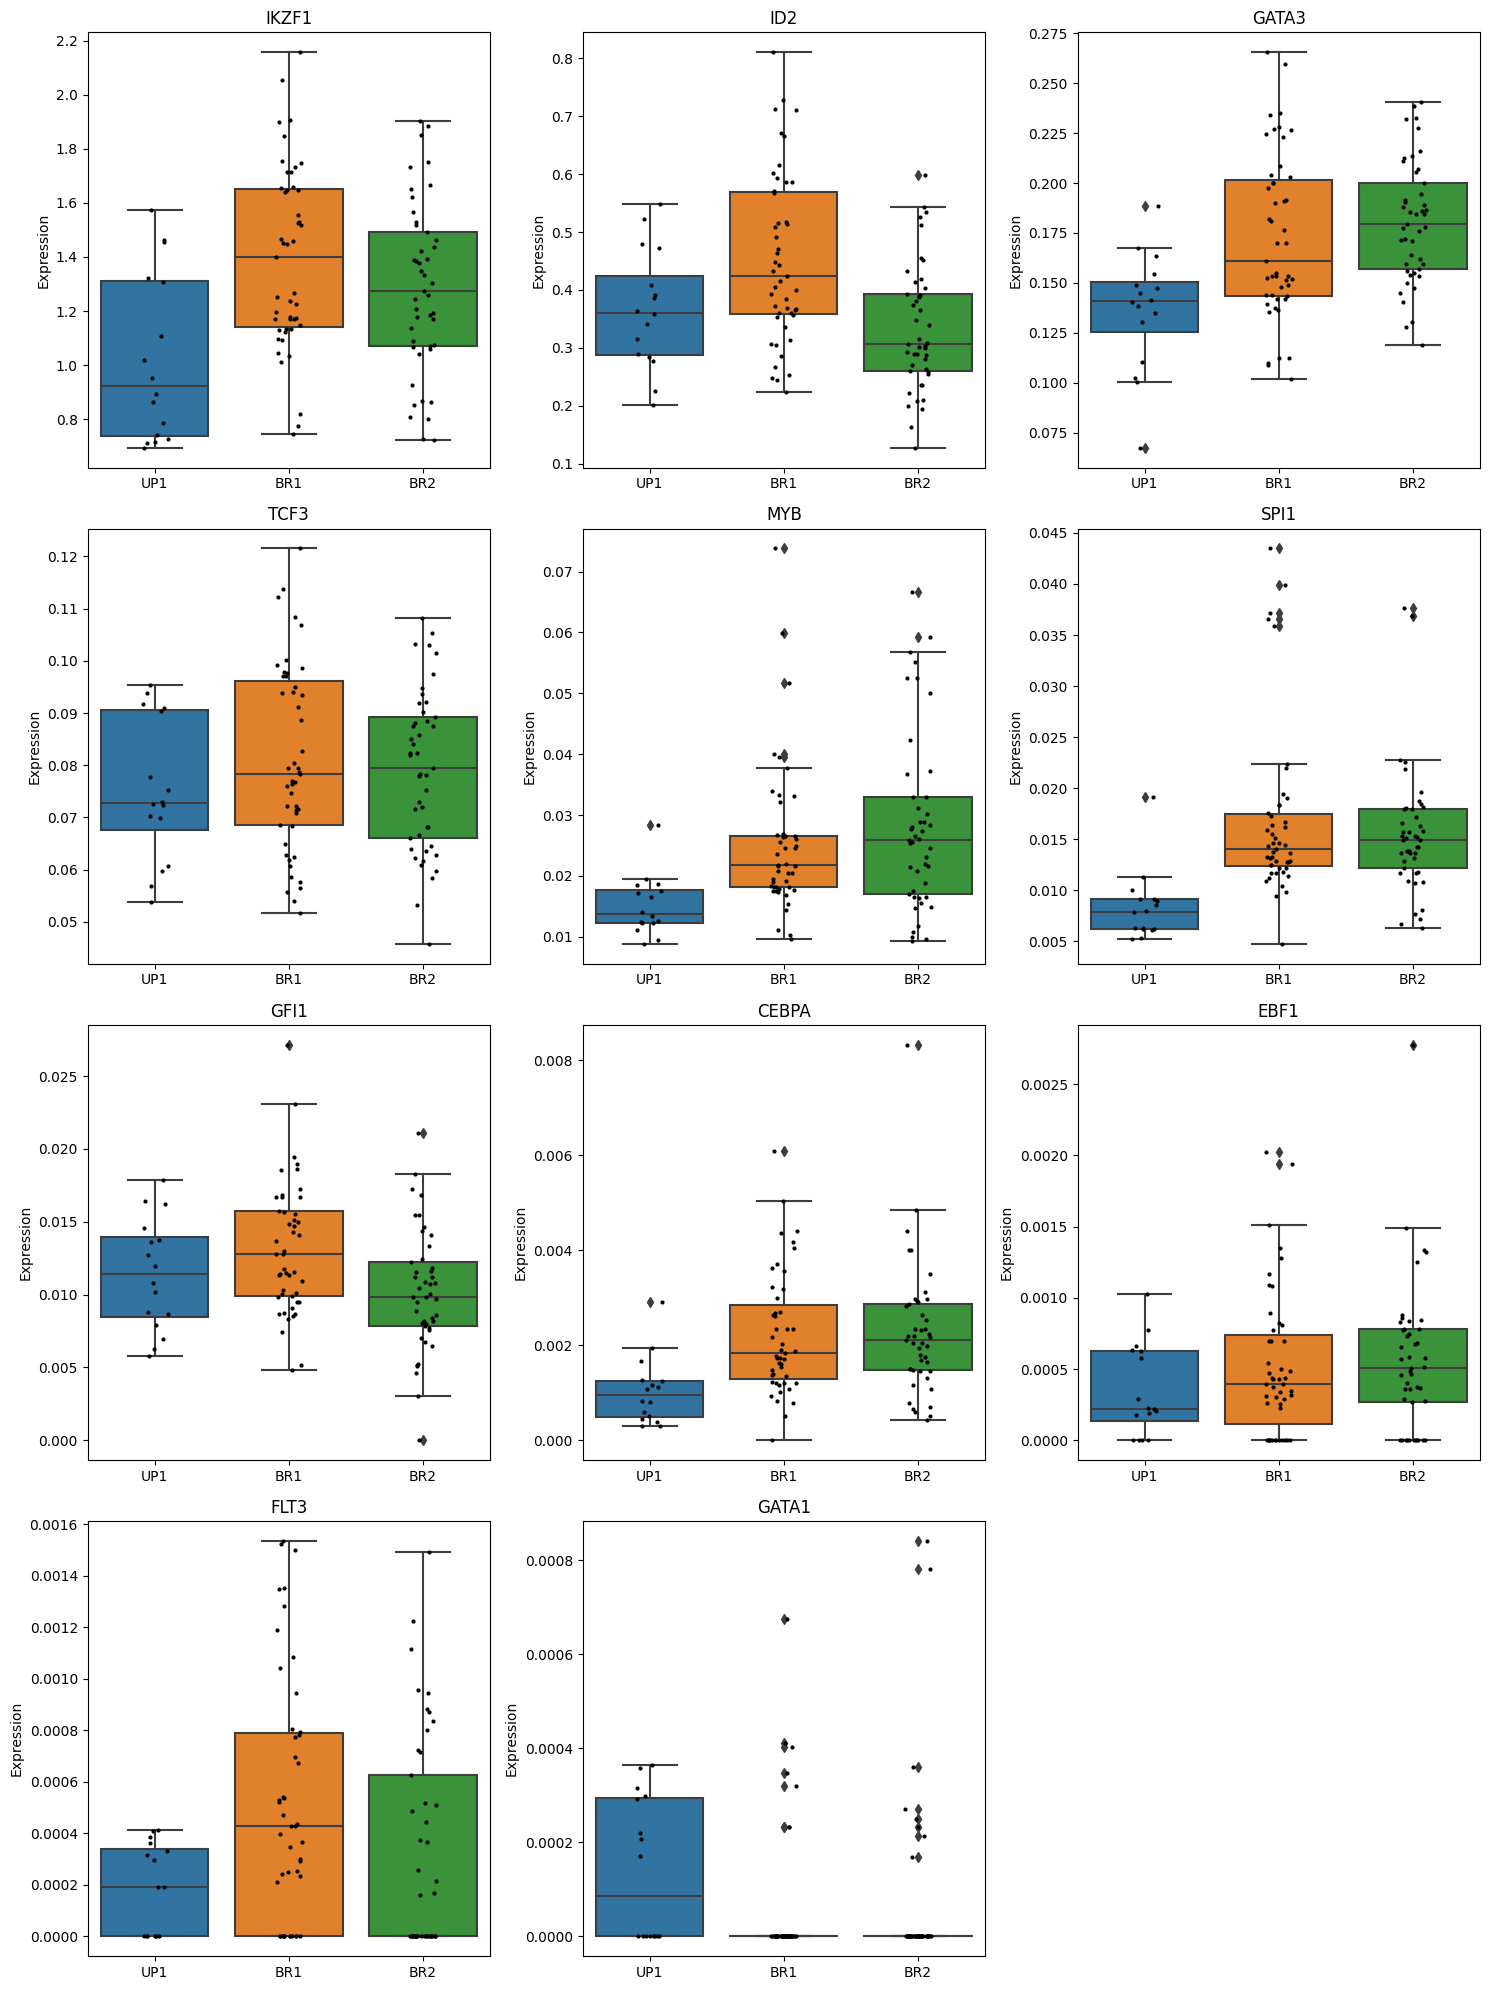

CPU times: user 2.03 s, sys: 120 ms, total: 2.15 s
Wall time: 1.91 s


In [49]:
%%time

# List of columns to exclude from mean calculation and plotting
exclude_columns = ['cohort.cohortGuid', 'CMV.IgG.Serology.Result.Interpretation', 'subject.biologicalSex']

# Exclude the specified columns and reorder the remaining columns based on their mean expression
cols_ordered = aggregated_data.drop(exclude_columns, axis=1).mean().sort_values(ascending=False).index

# Reorder the dataframe columns
aggregated_data1 = aggregated_data[['cohort.cohortGuid'] + list(cols_ordered)]

# Set the order of 'cohort.cohortGuid' for plotting
cohort_order = ["UP1", "BR1", "BR2"]

# Plotting
plt.figure(figsize=(15,20))  # Adjust the size as needed
for i, gene in enumerate(cols_ordered, 1):
    plt.subplot(len(cols_ordered) // 3 + 1, 3, i)  # Adjust the layout as needed
    sns.boxplot(x='cohort.cohortGuid', y=gene, data=aggregated_data1, order=cohort_order)
    sns.stripplot(x='cohort.cohortGuid', y=gene, data=aggregated_data1, order=cohort_order, color='black', size=3)
    plt.title(gene)
    plt.xlabel('')
    plt.ylabel('Expression')

plt.tight_layout()
plt.show()

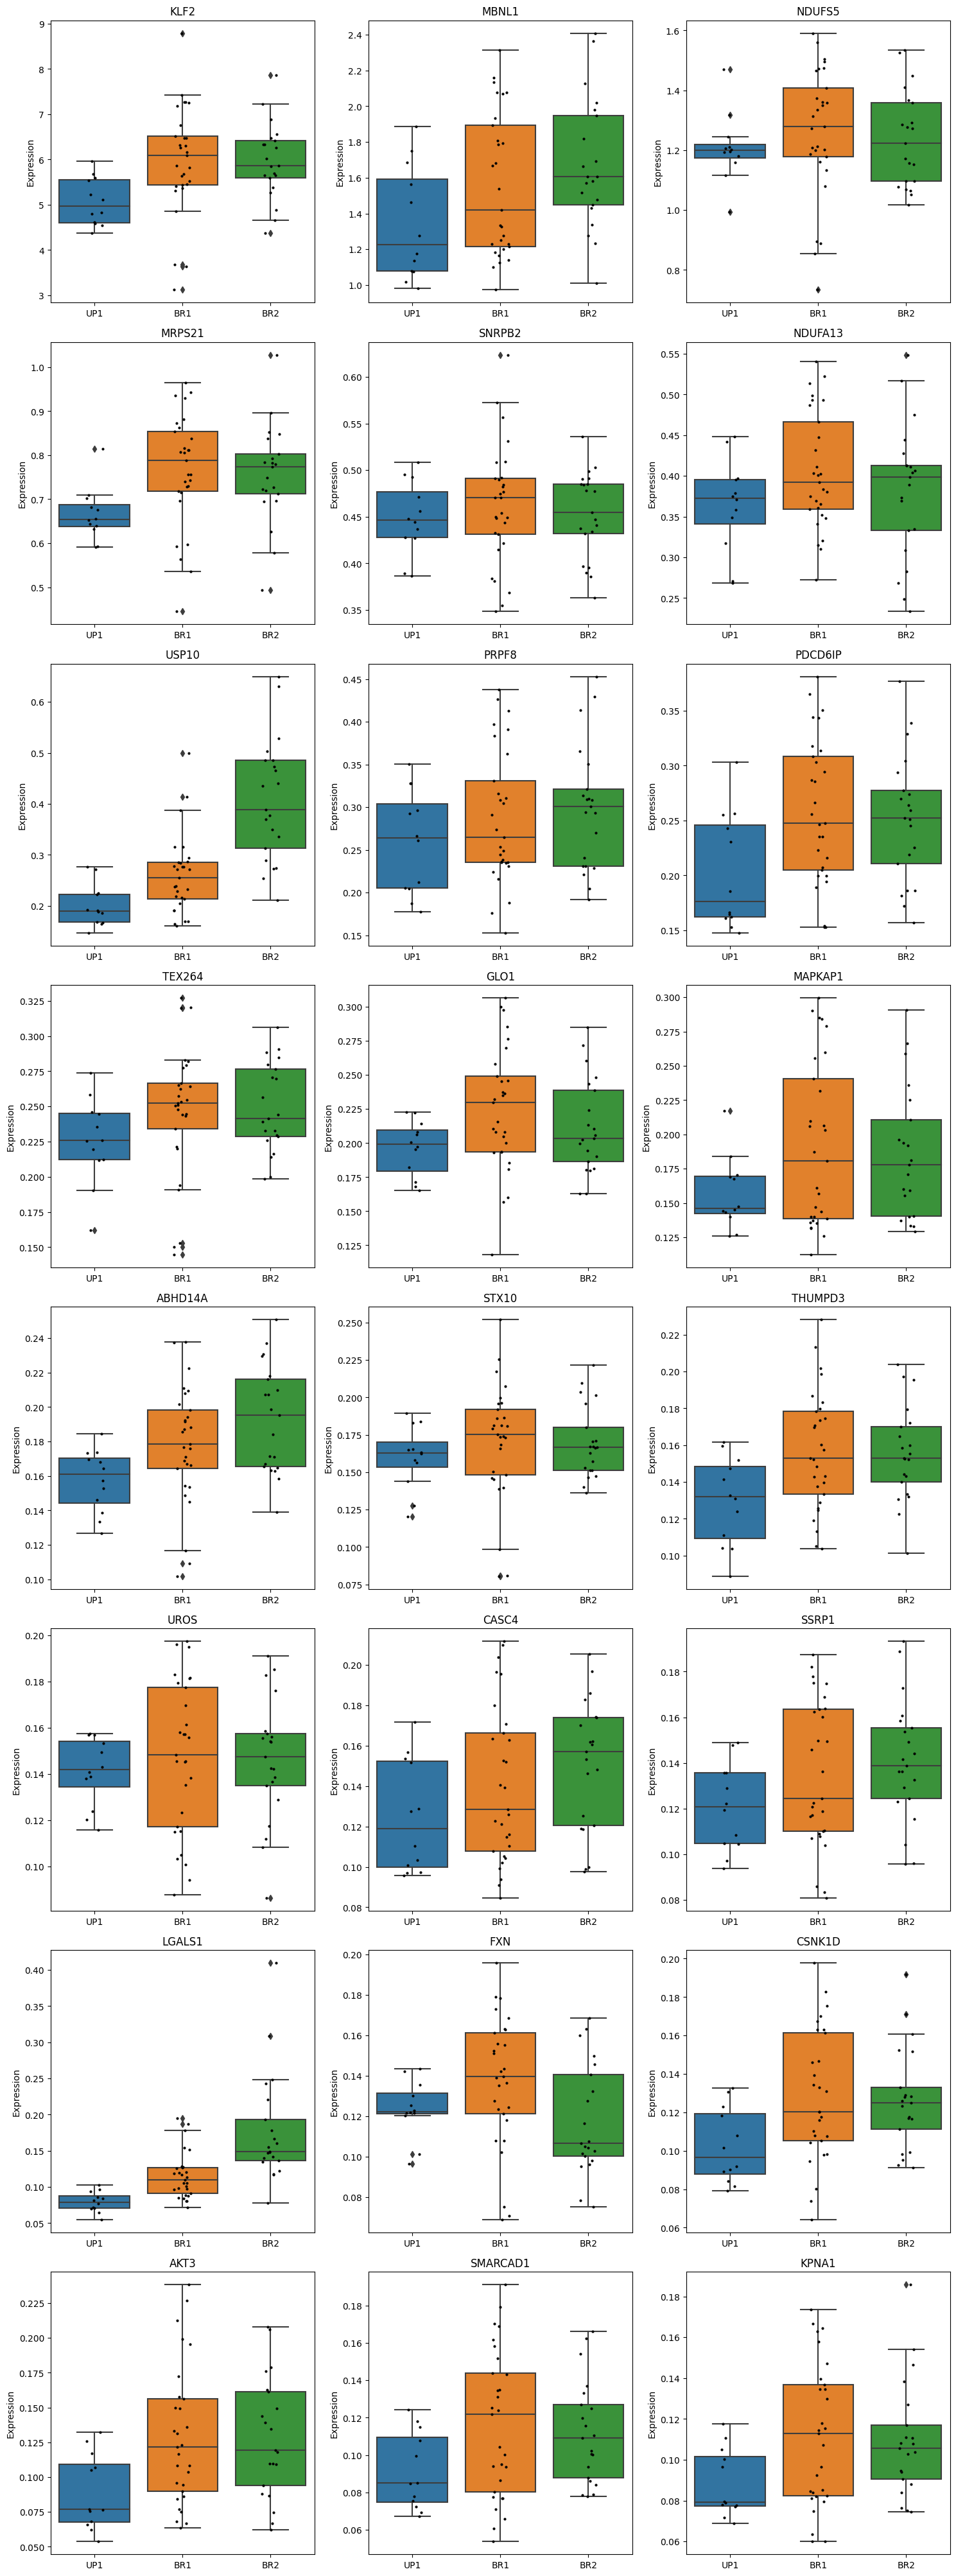

In [306]:
# Filter the DataFrame for rows where 'CMV.IgG.Serology.Result.Interpretation' is "Negative"
negative_cmv_data = aggregated_data[aggregated_data['CMV.IgG.Serology.Result.Interpretation'] == "Negative"]

# List of columns to exclude from mean calculation and plotting
exclude_columns = ['cohort.cohortGuid', 'CMV.IgG.Serology.Result.Interpretation', 'subject.biologicalSex']

# Exclude the specified columns and reorder the remaining columns based on their mean expression
cols_ordered = negative_cmv_data.drop(exclude_columns, axis=1).mean().sort_values(ascending=False).index

# Reorder the dataframe columns
negative_cmv_data = negative_cmv_data[['cohort.cohortGuid'] + list(cols_ordered)]

# Set the order of 'cohort.cohortGuid' for plotting
cohort_order = ["UP1", "BR1", "BR2"]

# Plotting
plt.figure(figsize=(15, 45))  # Adjust the size as needed4
for i, gene in enumerate(cols_ordered, 1):
    plt.subplot(len(cols_ordered) // 3 + 1, 3, i)  # Adjust the layout as needed
    sns.boxplot(x='cohort.cohortGuid', y=gene, data=negative_cmv_data, order=cohort_order)
    sns.stripplot(x='cohort.cohortGuid', y=gene, data=negative_cmv_data, order=cohort_order, color='black', size=3)
    plt.title(gene)
    plt.xlabel('')
    plt.ylabel('Expression')

plt.tight_layout()
plt.show()

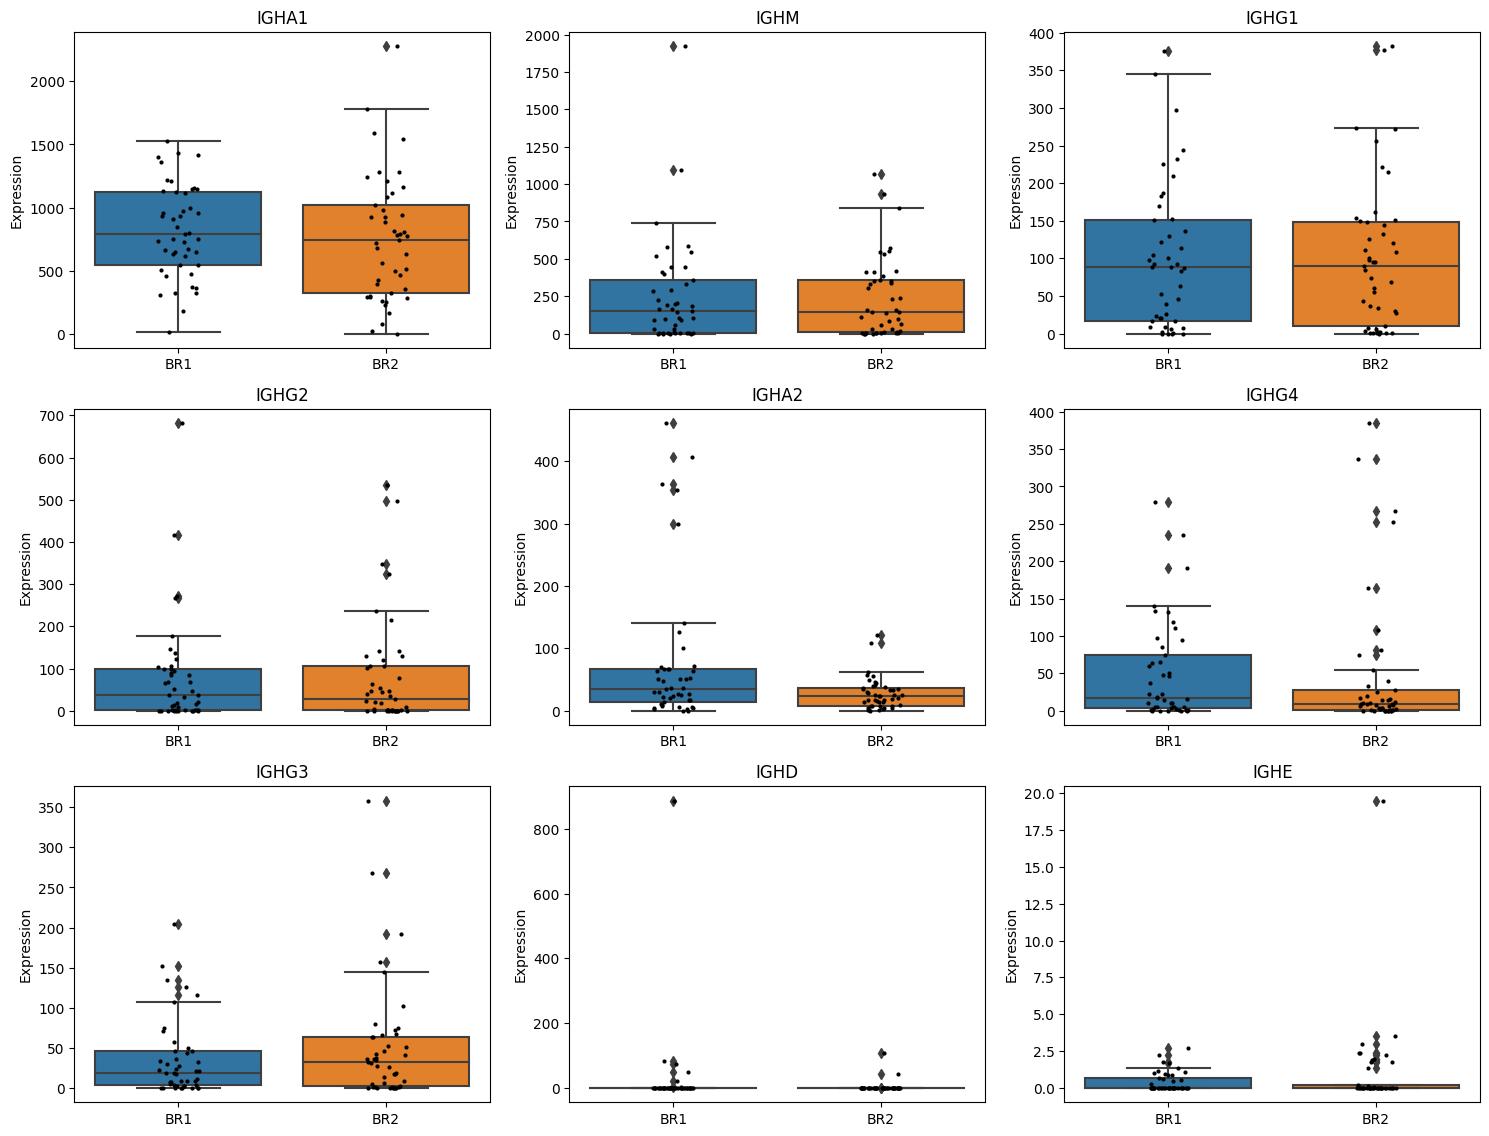

In [93]:
genes_of_interest = ['IGHD', 'IGHM', 'IGHE', 'IGHA1', 'IGHA2', 'IGHG1', 'IGHG2', 'IGHG3', 'IGHG4']

subset_data = AIFI_reference[AIFI_reference.obs['AIFI_L3'] == 'Plasma cell']
subset_data = subset_data[subset_data.obs['cohort.cohortGuid'].isin(['BR1', 'BR2'])]
subset_data_genes_of_interest = subset_data[:, subset_data.var_names.isin(genes_of_interest)].copy()

subject_cohort_info = subset_data.obs[['subject.subjectGuid', 'cohort.cohortGuid', 'subject.biologicalSex', 'CMV.IgG.Serology.Result.Interpretation']]

# Convert gene expression matrix to pandas DataFrame
expression_df = pd.DataFrame(subset_data_genes_of_interest.X.toarray(), 
                             columns=subset_data_genes_of_interest.var_names, 
                             index=subset_data.obs_names)

# Concatenate subject and cohort information with gene expression
full_data = pd.concat([subject_cohort_info, expression_df], axis=1)

def aggregate_data(df, genes_list):
    # For gene expression data, calculate the mean using the provided list of genes
    avg_gene_expression = df[genes_list].mean()
    # Retain the first instance of cohort and other details
    first_cohort = pd.Series(df['cohort.cohortGuid'].iloc[0], index=['cohort.cohortGuid'])
    first_CMV = pd.Series(df['CMV.IgG.Serology.Result.Interpretation'].iloc[0], index=['CMV.IgG.Serology.Result.Interpretation'])
    first_biol_sex = pd.Series(df['subject.biologicalSex'].iloc[0], index=['subject.biologicalSex'])
    return pd.concat([first_cohort, first_CMV, first_biol_sex, avg_gene_expression])

## Apply the aggregate function to each group with the current genes_of_interest
aggregated_data = full_data.groupby('subject.subjectGuid').apply(lambda x: aggregate_data(x, genes_of_interest))

# List of columns to exclude from mean calculation and plotting
exclude_columns = ['cohort.cohortGuid', 'CMV.IgG.Serology.Result.Interpretation', 'subject.biologicalSex']

# Exclude the specified columns and reorder the remaining columns based on their mean expression
cols_ordered = aggregated_data.drop(exclude_columns, axis=1).mean().sort_values(ascending=False).index

# Reorder the dataframe columns
aggregated_data1 = aggregated_data[['cohort.cohortGuid'] + list(cols_ordered)]

# Set the order of 'cohort.cohortGuid' for plotting
cohort_order = ["BR1", "BR2"]

# Plotting
plt.figure(figsize=(15, 15))  # Adjust the size as needed
for i, gene in enumerate(cols_ordered, 1):
    plt.subplot(len(cols_ordered) // 3 + 1, 3, i)  # Adjust the layout as needed
    sns.boxplot(x='cohort.cohortGuid', y=gene, data=aggregated_data1, order=cohort_order)
    sns.stripplot(x='cohort.cohortGuid', y=gene, data=aggregated_data1, order=cohort_order, color='black', size=3)
    plt.title(gene)
    plt.xlabel('')
    plt.ylabel('Expression')

plt.tight_layout()
plt.show()

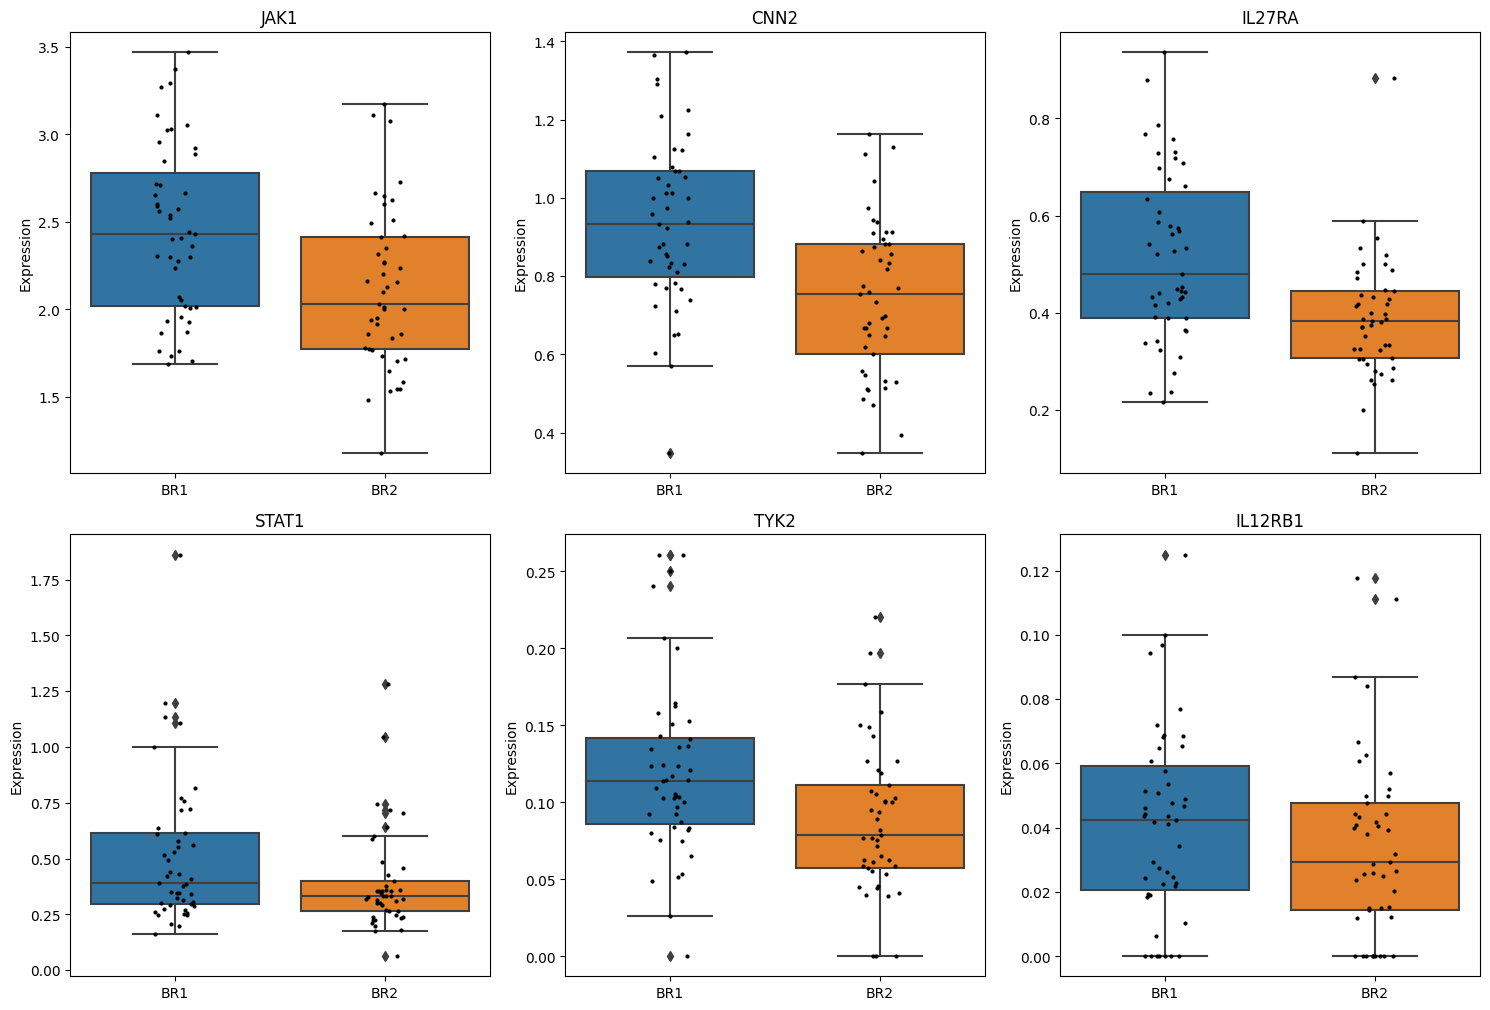

In [107]:
#genes_of_interest = ['CRLF1','RALA','CNN2','CDC42','IL12RB2','RPLP0','JAK2','IL12RB1','MTAP','PSME2','IL27RA','EBI3','TYK2','AIP','IL23A','IFNG','SOD2','HSPA9','IL12B','LMNB1','STAT1','CAPZA1','TCP1','HNRNPA2B1','VAMP7','CANX','RAP1B','SNRPA1','CA1','IL6ST','LCP1','IL10','STAT4','SOD1','ARF1','MSN','GSTO1','PDCD4','HNRNPDL','JAK1','IL23R','STAT3','IL12A','BOLA2B','HNRNPF','CFL1','PITPNA','TALDO1','PAK2','ANXA2','BOLA2','P4HB','PPIA','IL27','SERPINB2','MIF','GSTA2']
genes_of_interest = ['IL12RB1', 'JAK1', 'TYK2', 'STAT1', 'IL27RA', 'CNN2']


#subset_data = AIFI_reference[AIFI_reference.obs['AIFI_L3'] == 'Plasma cell']
subset_data = AIFI_reference[AIFI_reference.obs['AIFI_L3'].isin(['CD27+ effector B cell'])]
subset_data = subset_data[subset_data.obs['cohort.cohortGuid'].isin(['BR1', 'BR2'])]
subset_data_genes_of_interest = subset_data[:, subset_data.var_names.isin(genes_of_interest)].copy()

subject_cohort_info = subset_data.obs[['subject.subjectGuid', 'cohort.cohortGuid', 'subject.biologicalSex', 'CMV.IgG.Serology.Result.Interpretation']]

# Convert gene expression matrix to pandas DataFrame
expression_df = pd.DataFrame(subset_data_genes_of_interest.X.toarray(), 
                             columns=subset_data_genes_of_interest.var_names, 
                             index=subset_data.obs_names)

# Concatenate subject and cohort information with gene expression
full_data = pd.concat([subject_cohort_info, expression_df], axis=1)

def aggregate_data(df, genes_list):
    # For gene expression data, calculate the mean using the provided list of genes
    avg_gene_expression = df[genes_list].mean()
    # Retain the first instance of cohort and other details
    first_cohort = pd.Series(df['cohort.cohortGuid'].iloc[0], index=['cohort.cohortGuid'])
    first_CMV = pd.Series(df['CMV.IgG.Serology.Result.Interpretation'].iloc[0], index=['CMV.IgG.Serology.Result.Interpretation'])
    first_biol_sex = pd.Series(df['subject.biologicalSex'].iloc[0], index=['subject.biologicalSex'])
    return pd.concat([first_cohort, first_CMV, first_biol_sex, avg_gene_expression])

## Apply the aggregate function to each group with the current genes_of_interest
aggregated_data = full_data.groupby('subject.subjectGuid').apply(lambda x: aggregate_data(x, genes_of_interest))

# List of columns to exclude from mean calculation and plotting
exclude_columns = ['cohort.cohortGuid', 'CMV.IgG.Serology.Result.Interpretation', 'subject.biologicalSex']

# Exclude the specified columns and reorder the remaining columns based on their mean expression
cols_ordered = aggregated_data.drop(exclude_columns, axis=1).mean().sort_values(ascending=False).index

# Reorder the dataframe columns
aggregated_data1 = aggregated_data[['cohort.cohortGuid'] + list(cols_ordered)]

# Set the order of 'cohort.cohortGuid' for plotting
cohort_order = ["BR1", "BR2"]

# Plotting
plt.figure(figsize=(15, 15))  # Adjust the size as needed
for i, gene in enumerate(cols_ordered, 1):
    plt.subplot(len(cols_ordered) // 3 + 1, 3, i)  # Adjust the layout as needed
    sns.boxplot(x='cohort.cohortGuid', y=gene, data=aggregated_data1, order=cohort_order)
    sns.stripplot(x='cohort.cohortGuid', y=gene, data=aggregated_data1, order=cohort_order, color='black', size=3)
    plt.title(gene)
    plt.xlabel('')
    plt.ylabel('Expression')

plt.tight_layout()
plt.show()

In [ ]:
genes_of_interest = [ANGPTL4,ITGA2,SPRY2,HBEGF,RBP4,HSD11B1,ETV4,GLRX,DUSP6,SCG5,ETV5,ITGB2,AKT2,PPBP,G0S2,GABRA3,IRF8,BIRC3,FGF9,DCBLD2,INHBA,TFPI,TSPAN1,ADAM8,SLPI,PRKG2,MMP11,MMP10,TMEM158,TNFAIP3,PRDM1,GALNT3,ETS1,MMP9,WNT7A,IGFBP3,SPP1,ETV1,CLEC4A,CCND2,TSPAN7,ITGBL1,EMP1,CDADC1,KIF5C,TRIB2,SDCCAG8,PCP4,CFHR2,ALDH1A2,NR0B2,ALDH1A3,AMMECR1,SATB1,GUCY1A1,CSF2,APOD,TOR1AIP2,CMKLR1,TMEM176B,ADGRA2,LAPTM5,CD37,CAB39L,CIDEA,ZNF639,IL1B,GYPC,LY96,FLT4,SPON1,BMP2,PLEK2,IGF2,NR1H4,SNAP25,ACE,PRRX1,C3AR1,TRAF1,TLR8,ID2,TMEM100,PLAUR,GADD45G,CBX8,SCN1B,PTBP2,NAP1L2,AKAP12,PLAT,SCG3,ANO1,IL1RL2,CXCL10,ATG10,YRDC,HDAC9,PEG3,SEMA3B,TNNT2,LIF,CFB,BTC,PPP1R15A,PTPRR,CCL20,ARG1,RETN,KLF4,MMD,PDCD1LG2,H2BC3,HOXD11,TRIB1,F2RL1,ANXA10,TSPAN13,MTMR10,CFH,LAT2,ERO1A,RELN,KCNN4,TMEM176A,MAP4K1,PTGS2,IL33,MAFB,LCP1,NGF,CA2,SERPINA3,RGS16,CTSS,USP12,CPE,SPARCL1,ABCB1,USH1C,CSF2RA,BTBD3,IL2RG,DNMBP,IL10RA,EREG,PRELID3B,EPHB2,FBXO4,CROT,MPZL2,ANKH,CBR4,DOCK2,GPRC5B,RABGAP1L,MALL,STRN,ST6GAL1,PIGR,VWA5A,PSMB8,F13A1,NRP1,SOX9,JUP,ADGRL4,ZNF277,EPB41L3,PCSK1N,FUCA1,PLVAP,ADAM17,AVL9,ADAMDEC1,HKDC1,MAP7,IL7R,RBM4,BPGM,ENG,GFPT2,PLAU,GNG11,PTCD2,MAP3K1,CBL,CXCR4,NIN,IKZF1,WDR33,MYCN,FCER1G,PECAM1,CCSER2,SNAP91,EVI5,TNFRSF1B,GPNMB,TPH1]
subset_condition = (adata.obs['AIFI_L3'] == 'Core naive CD4 T cell')
plot_gene_expression(adata, genes_of_interest, subset_condition)

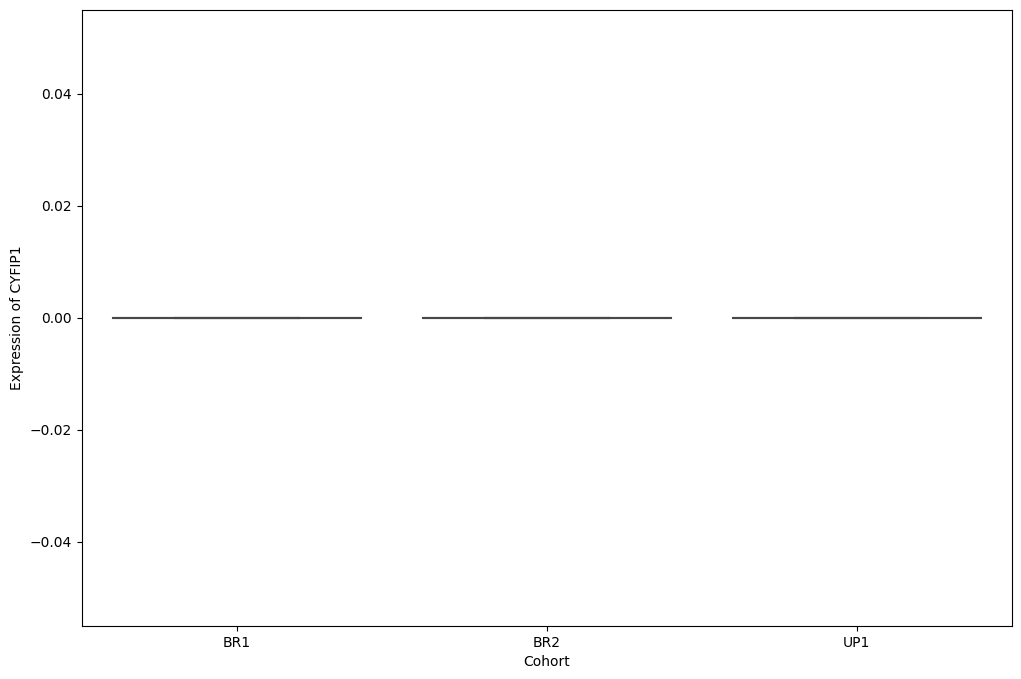

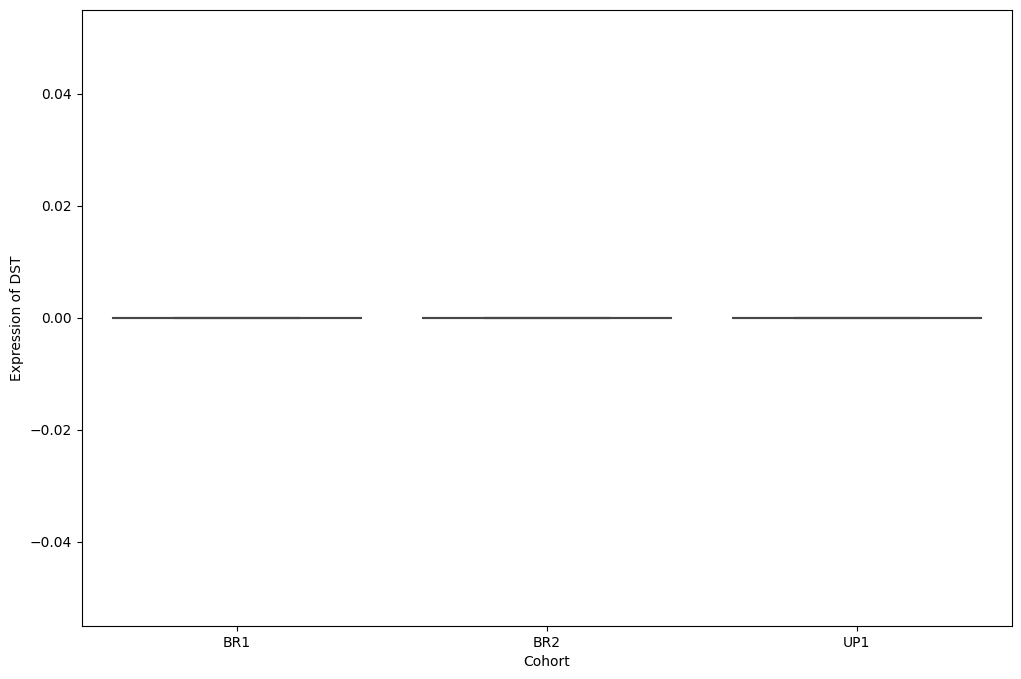

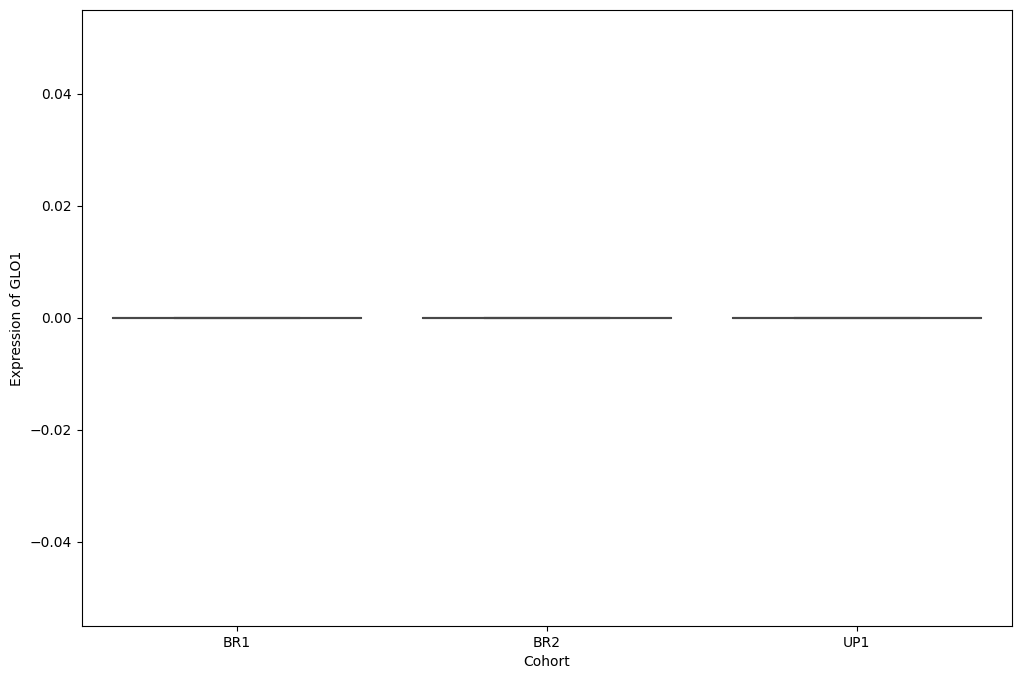

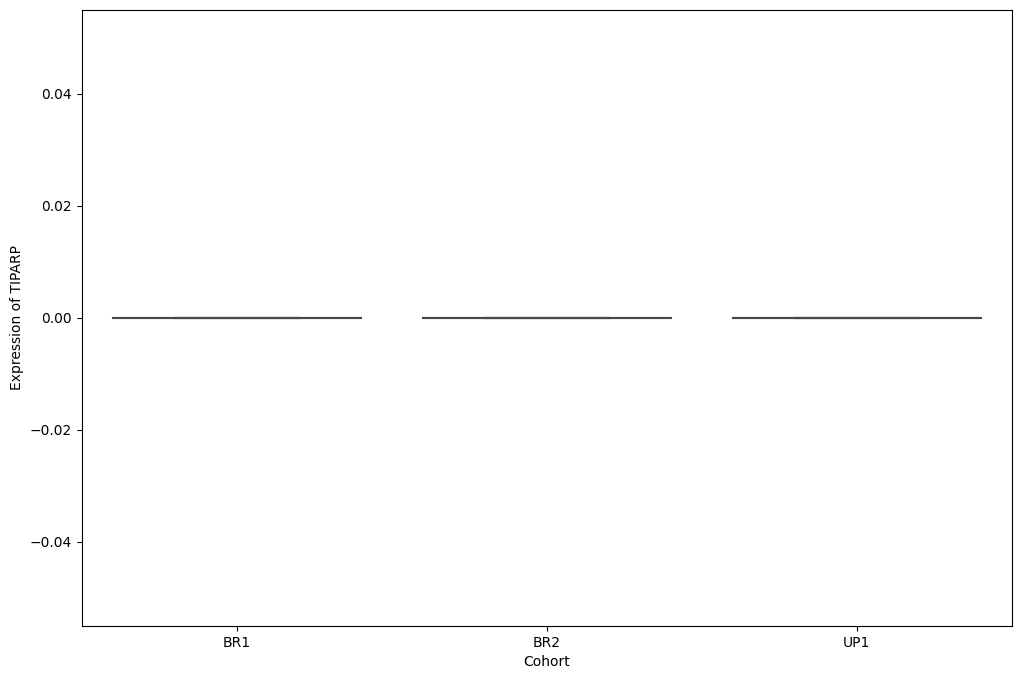

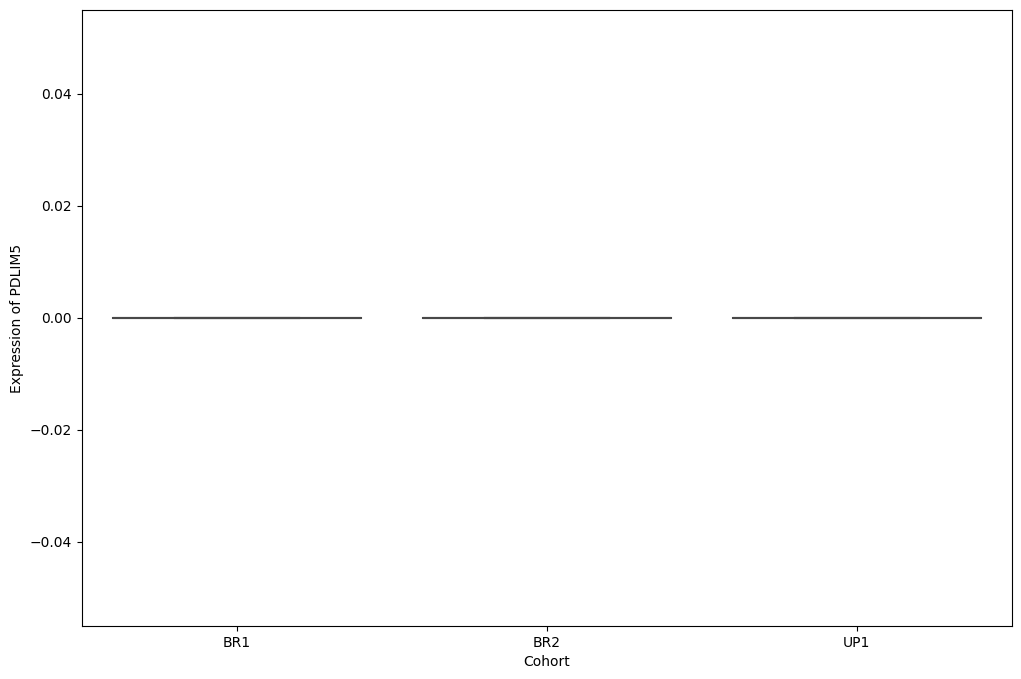

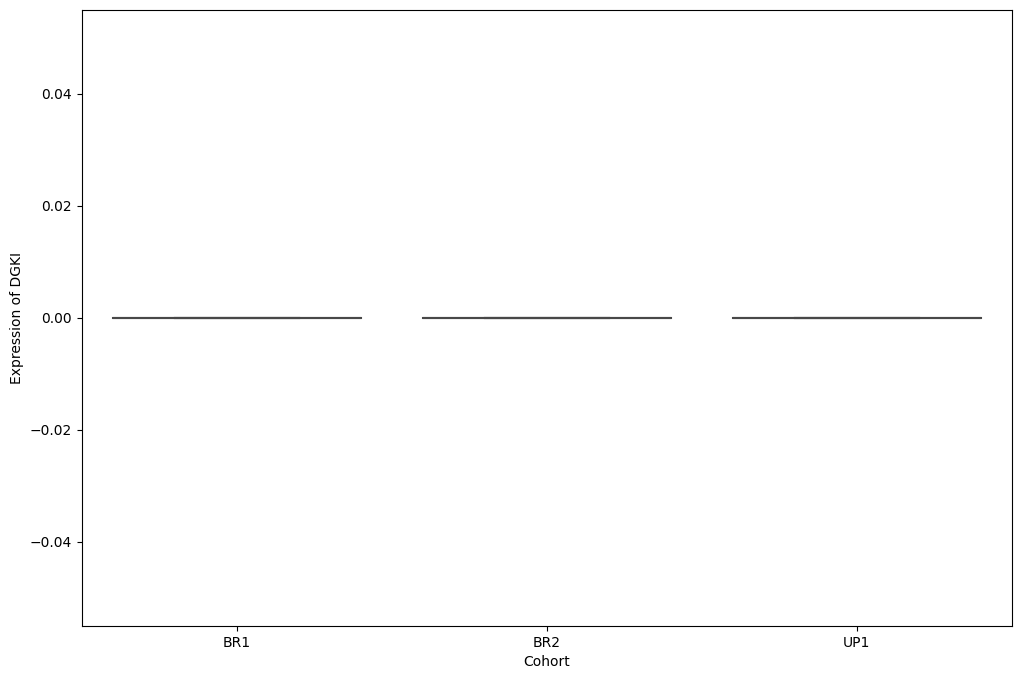

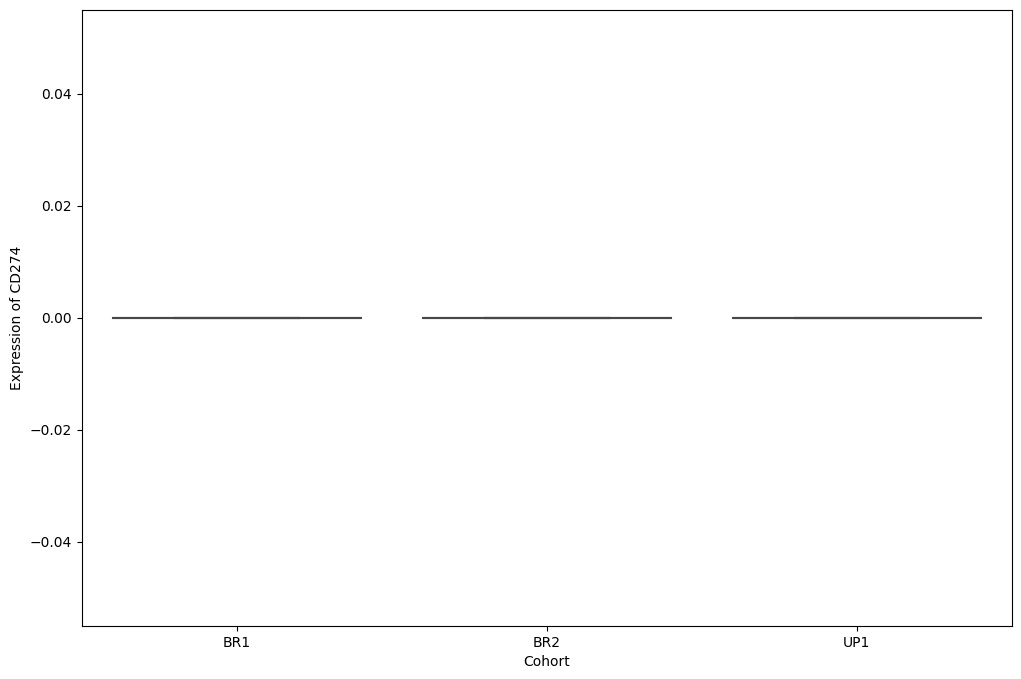

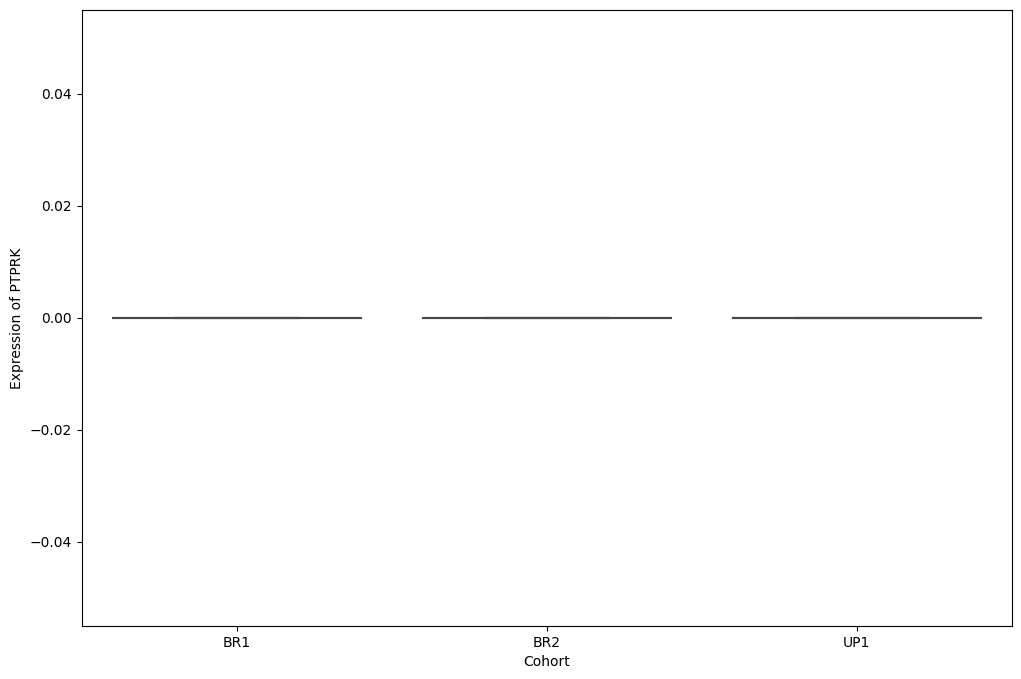

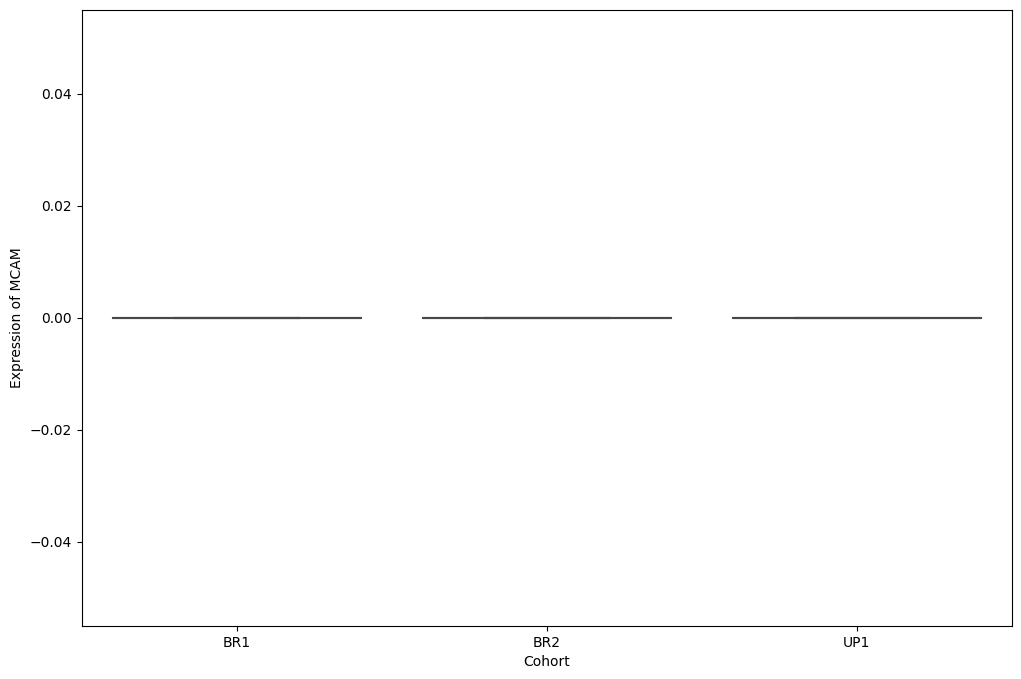

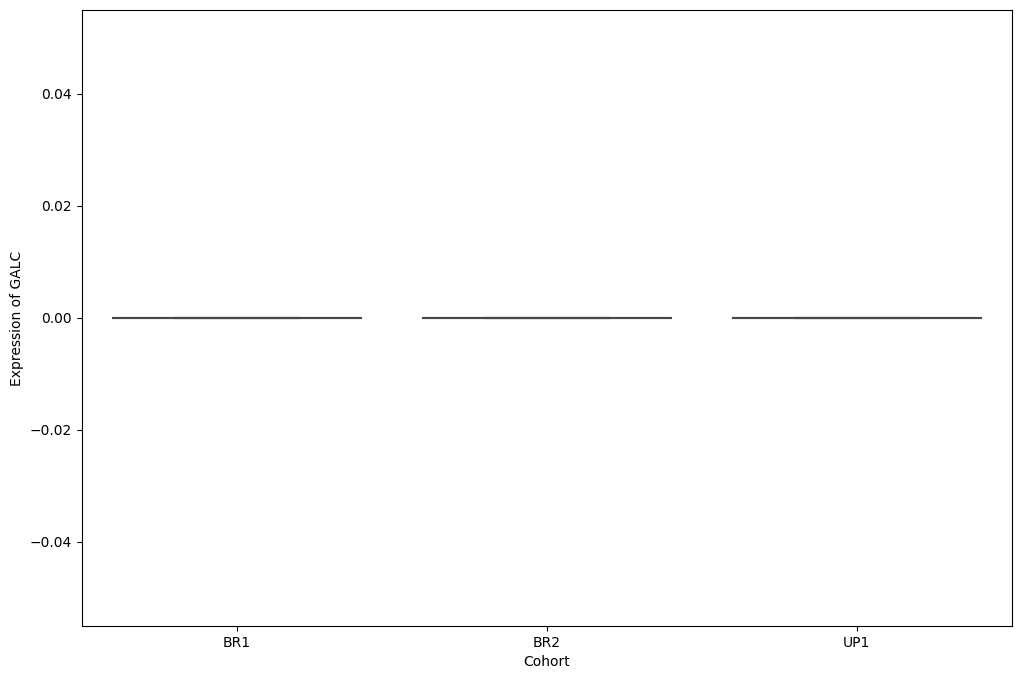

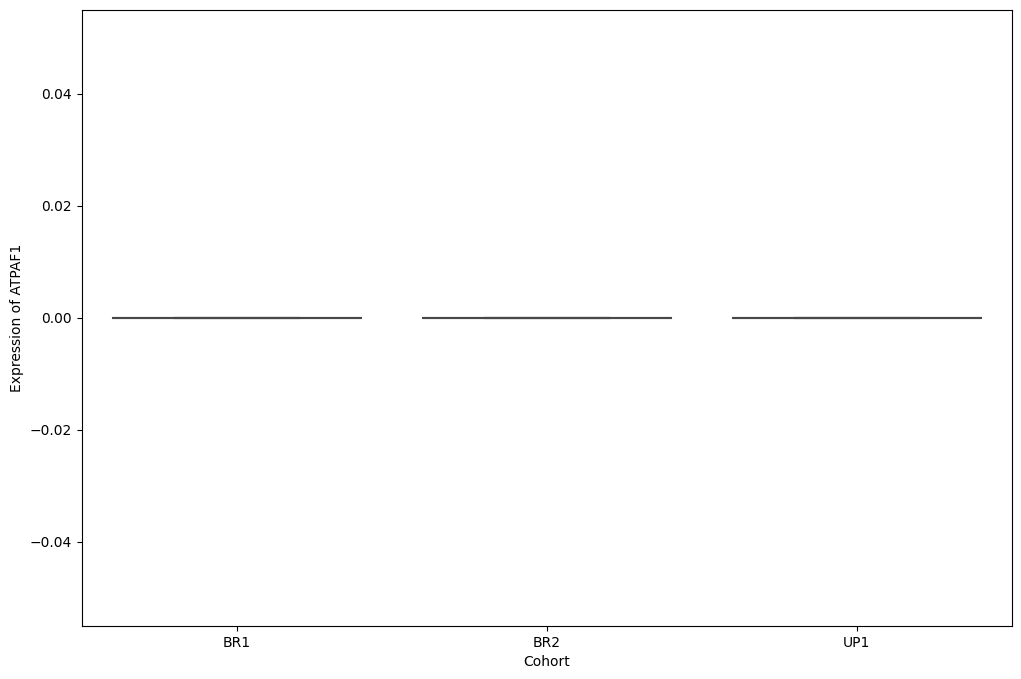

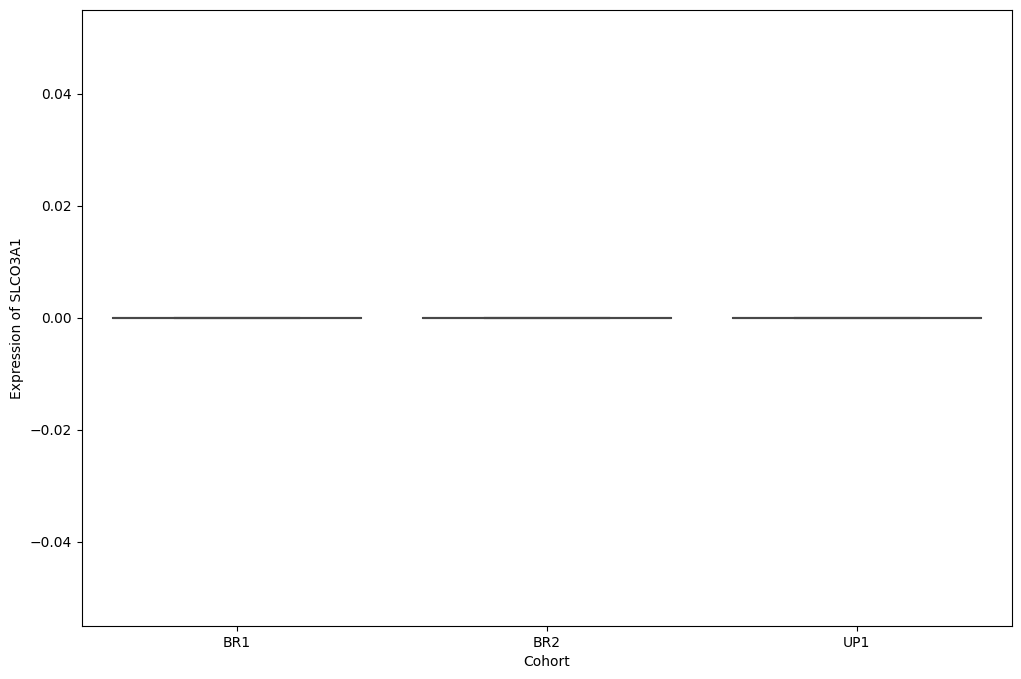

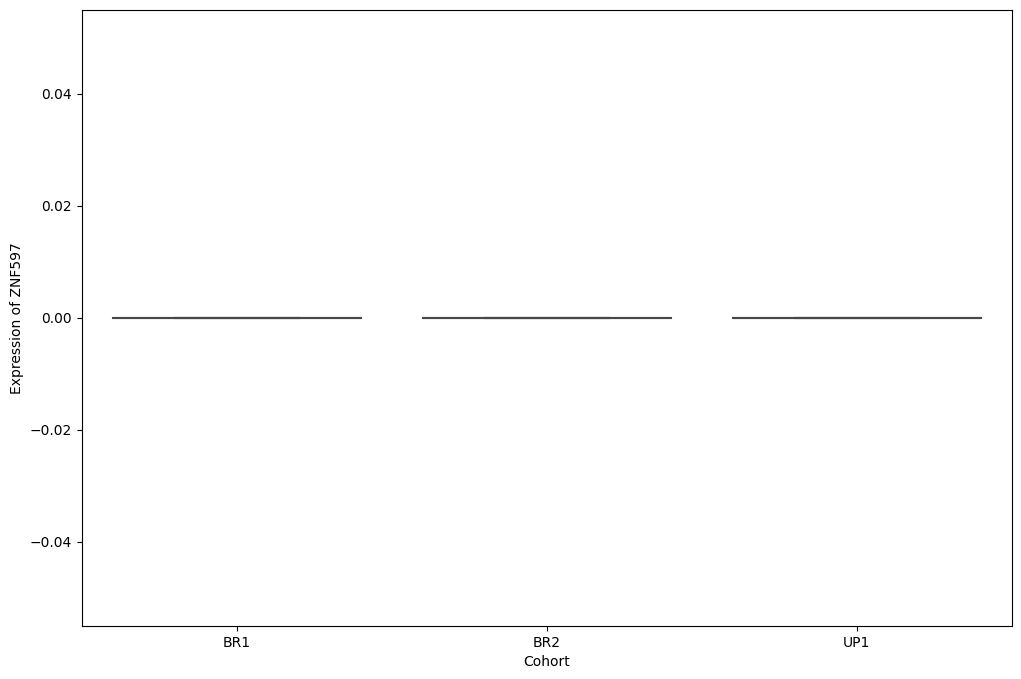

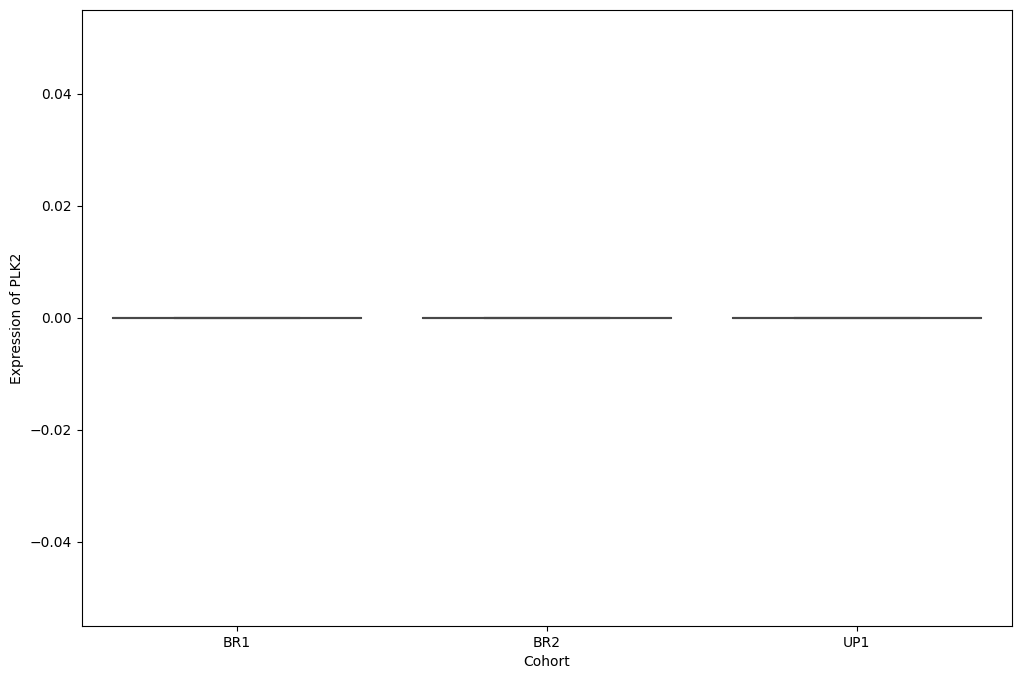

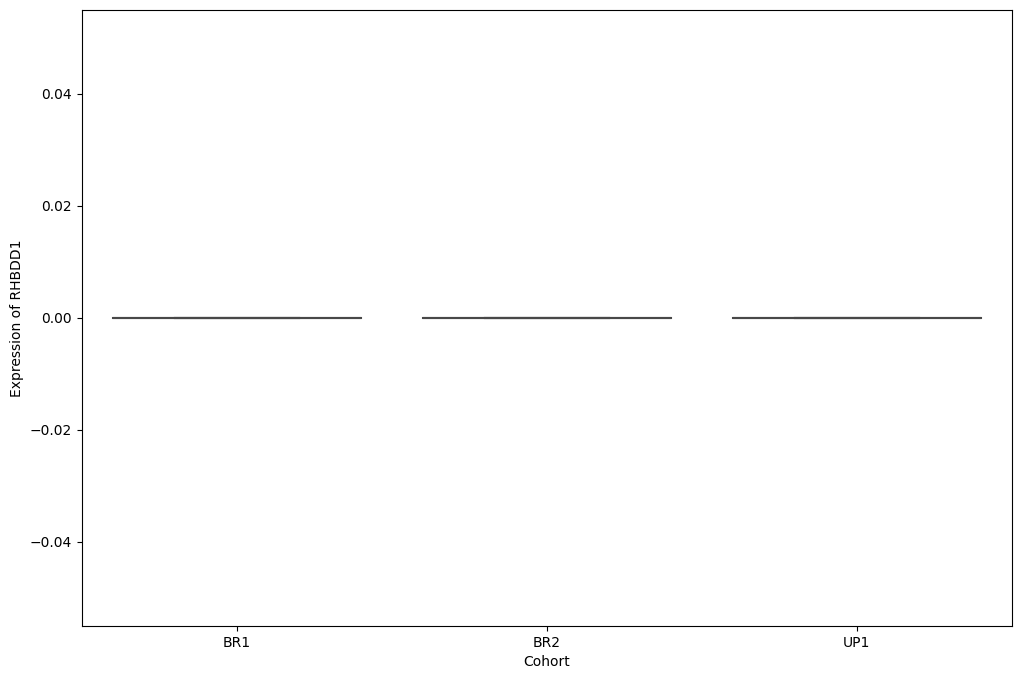

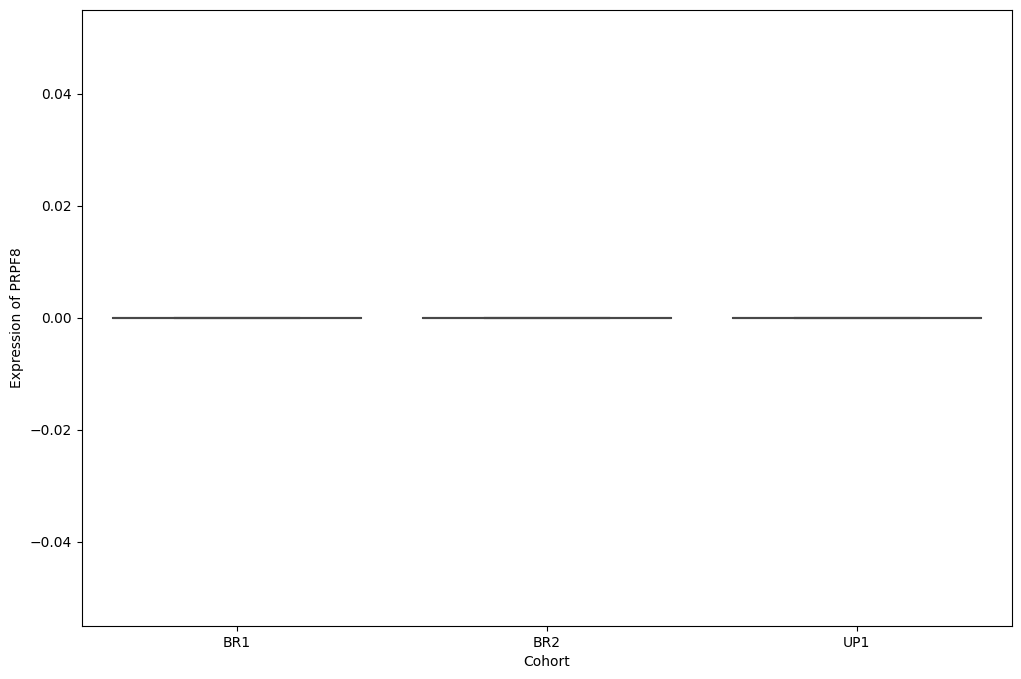

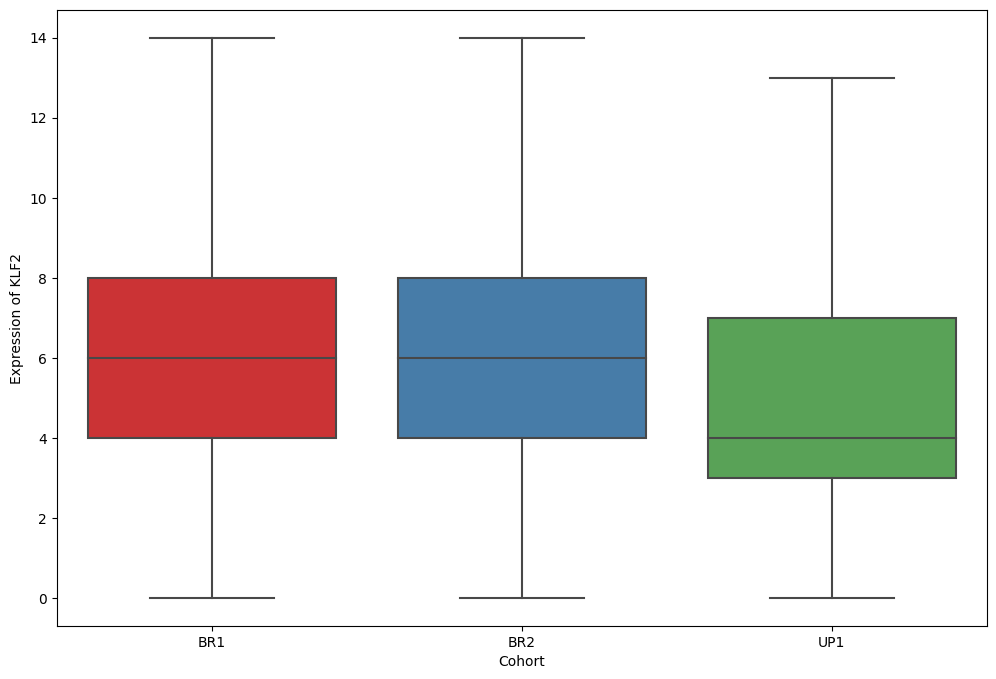

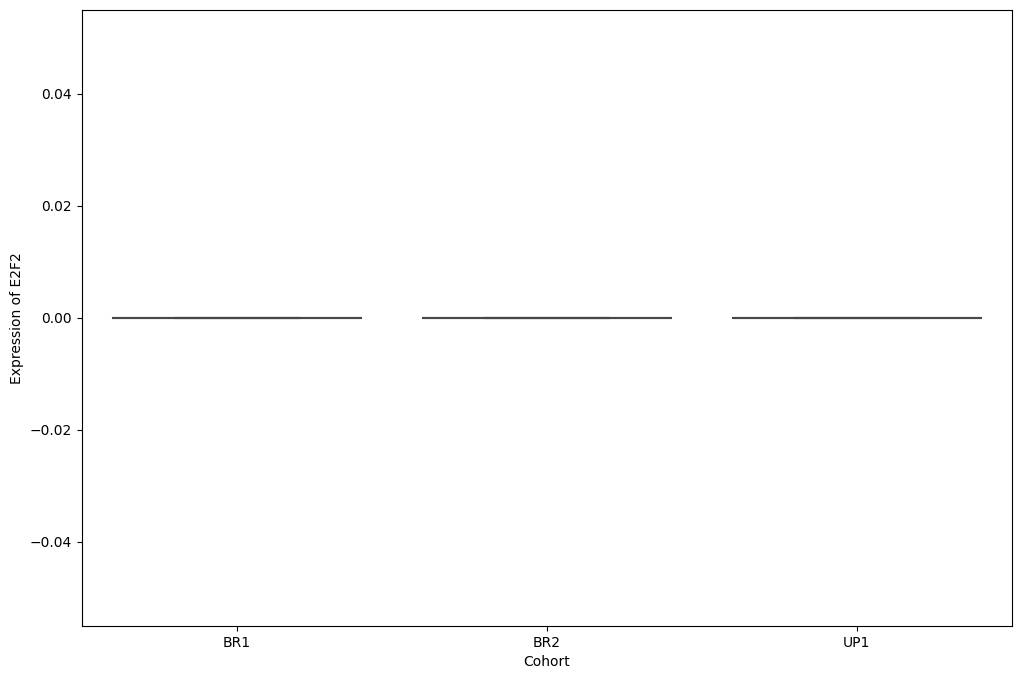

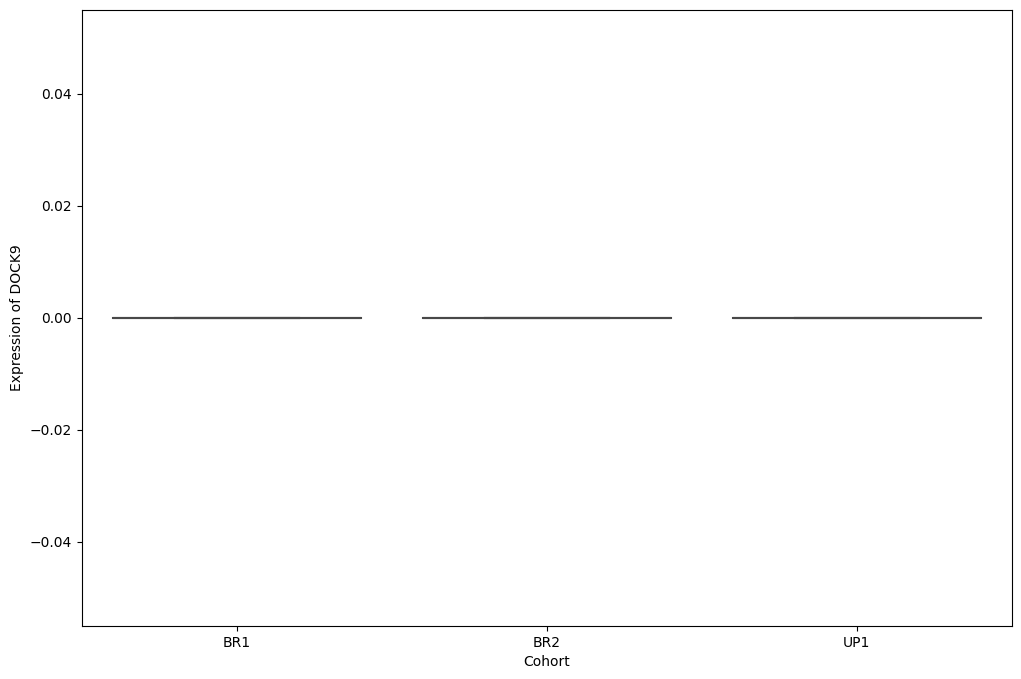

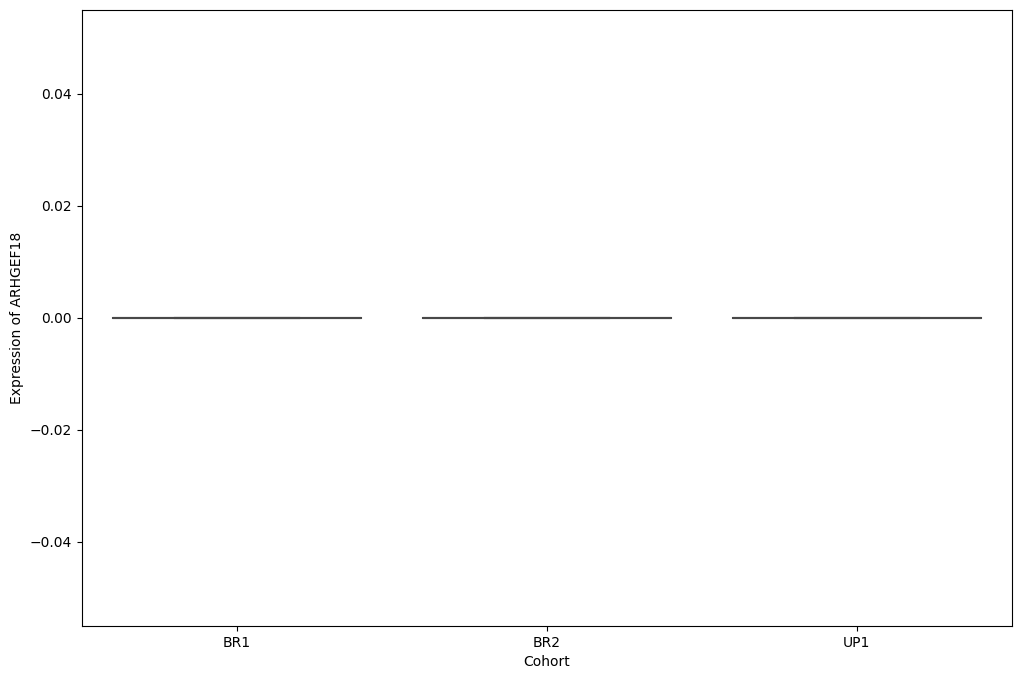

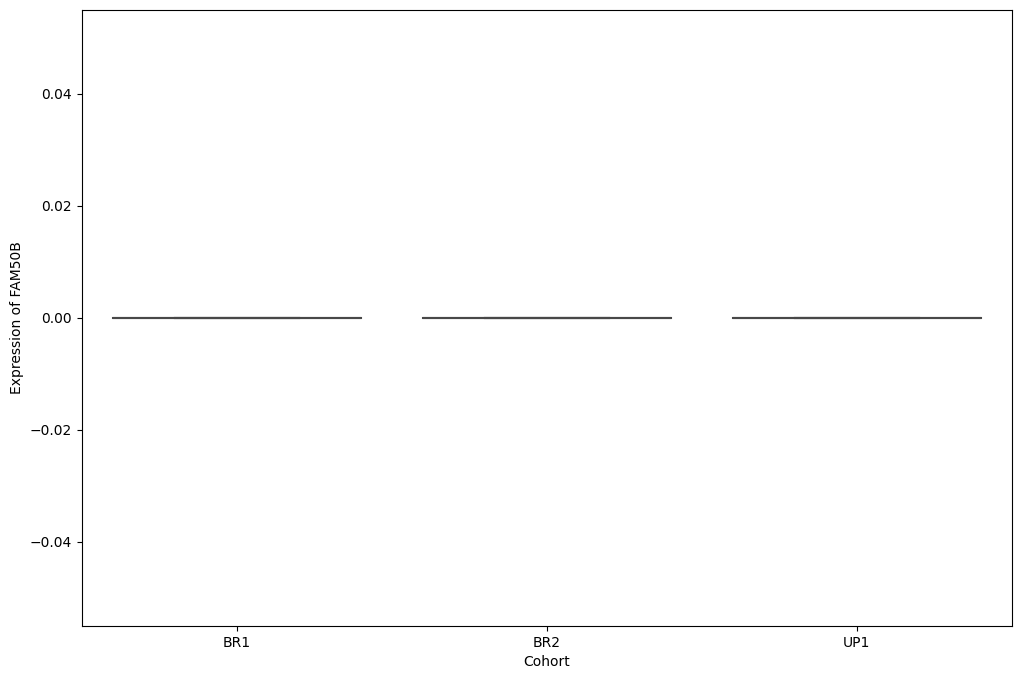

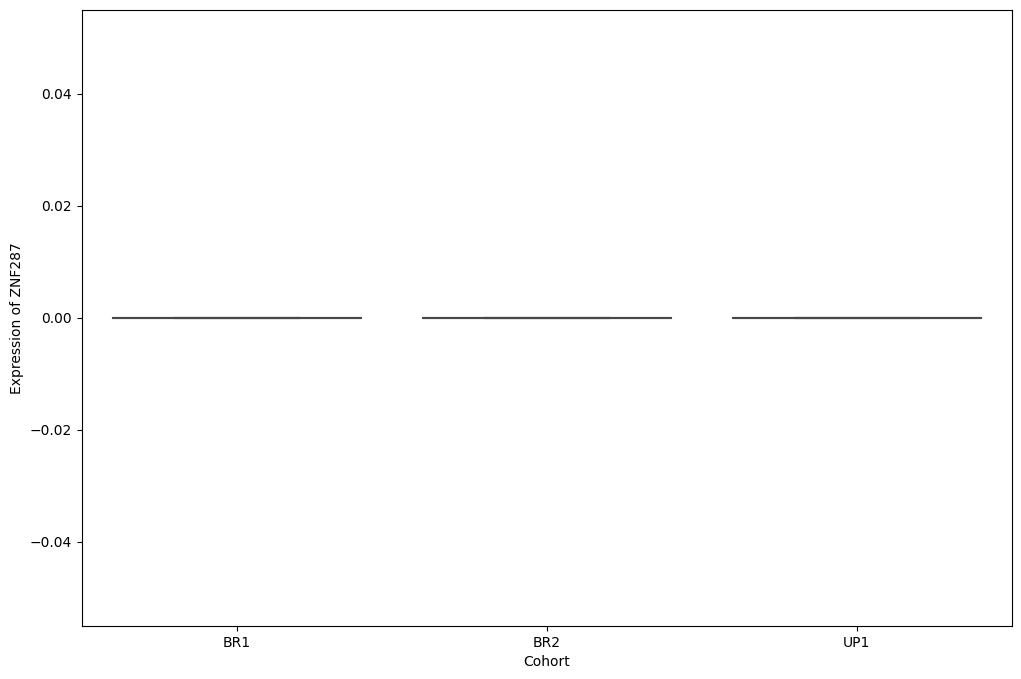

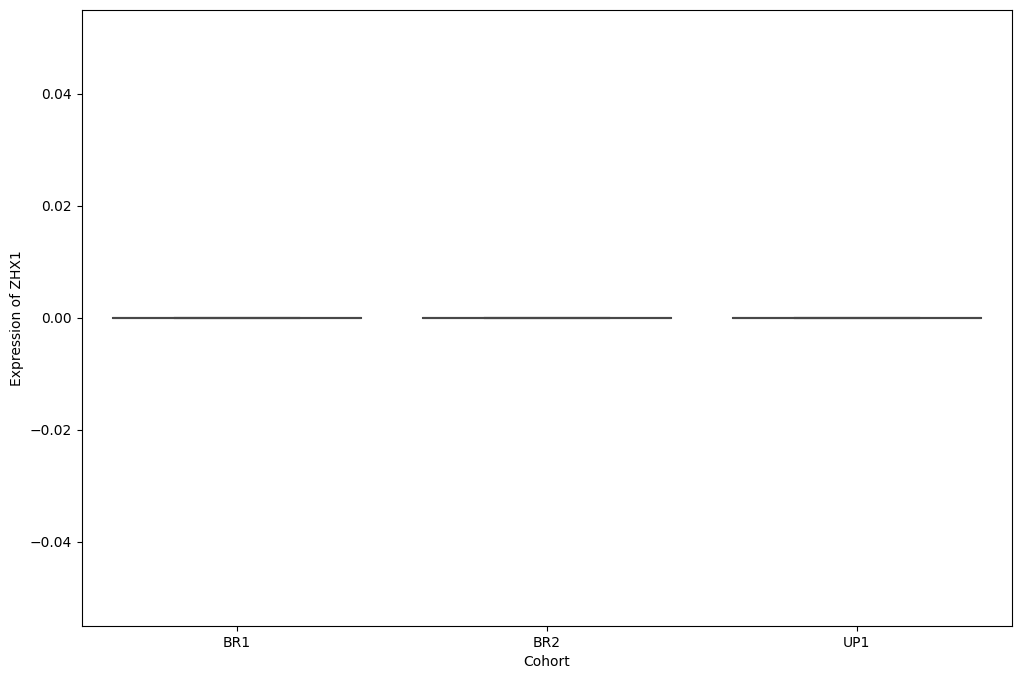

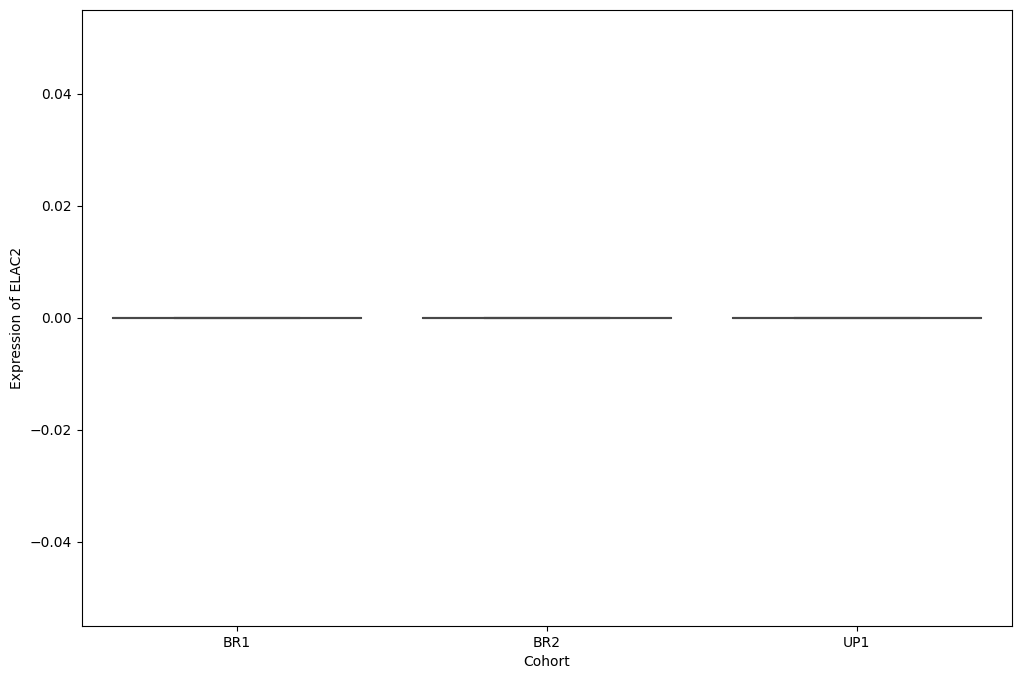

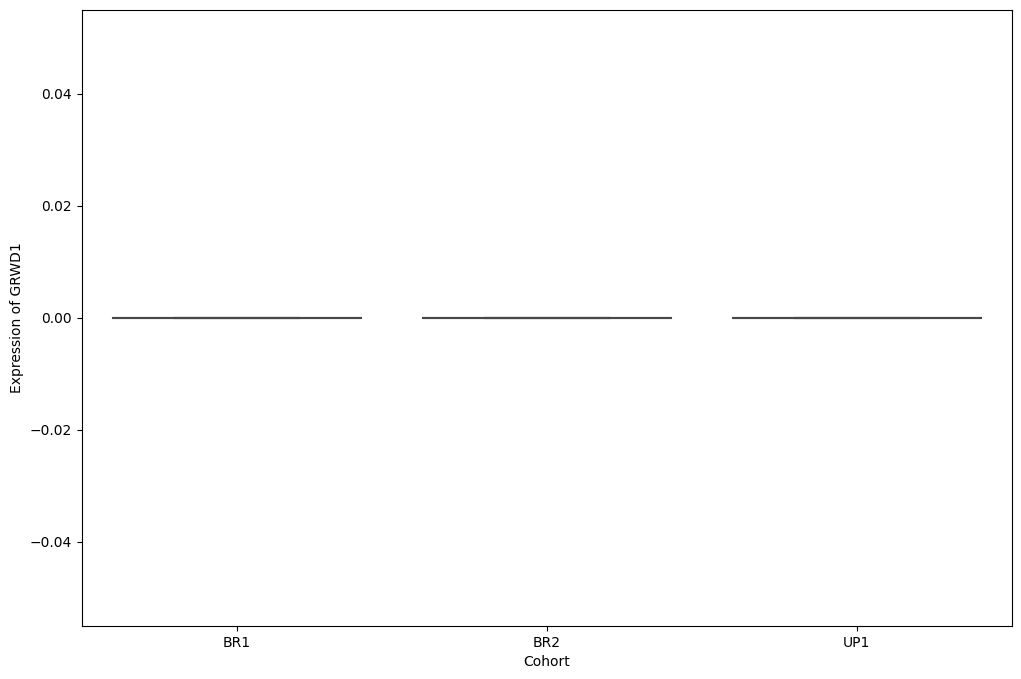

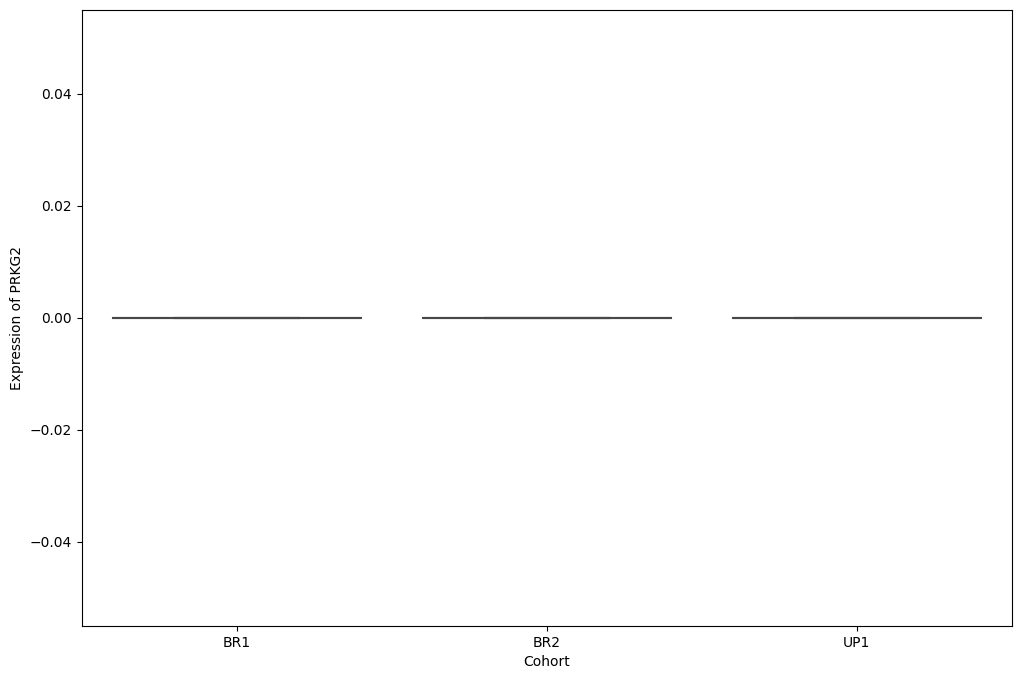

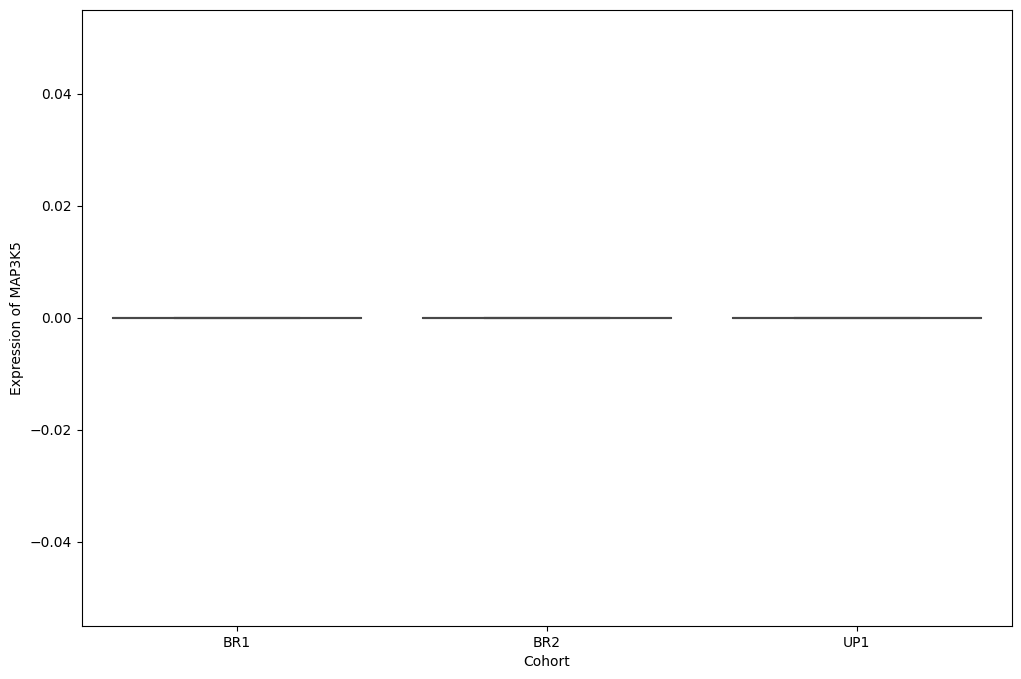

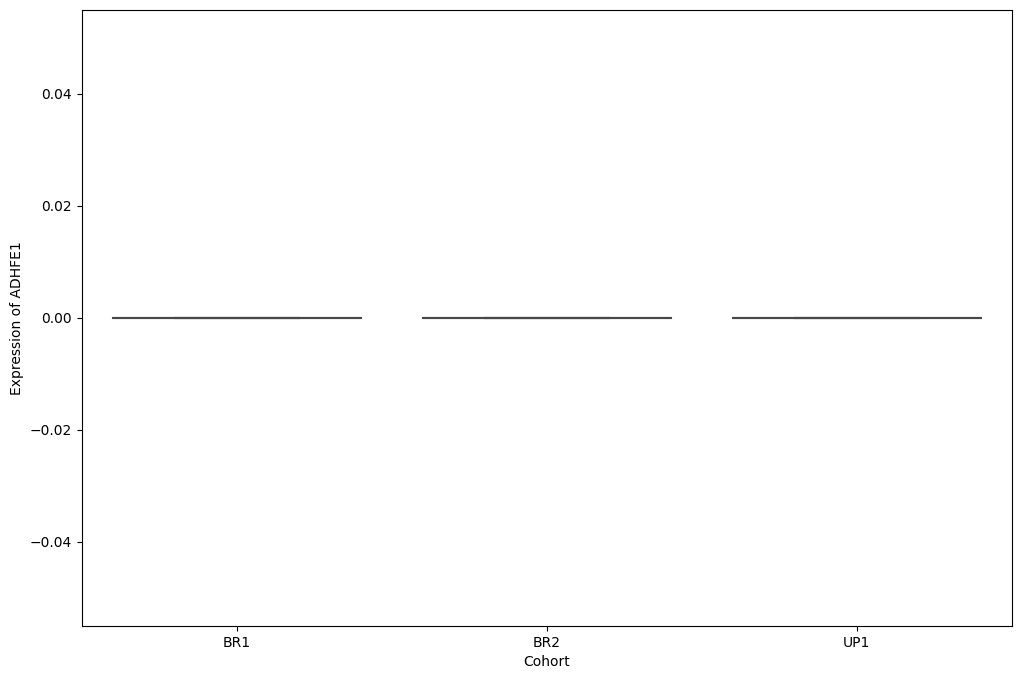

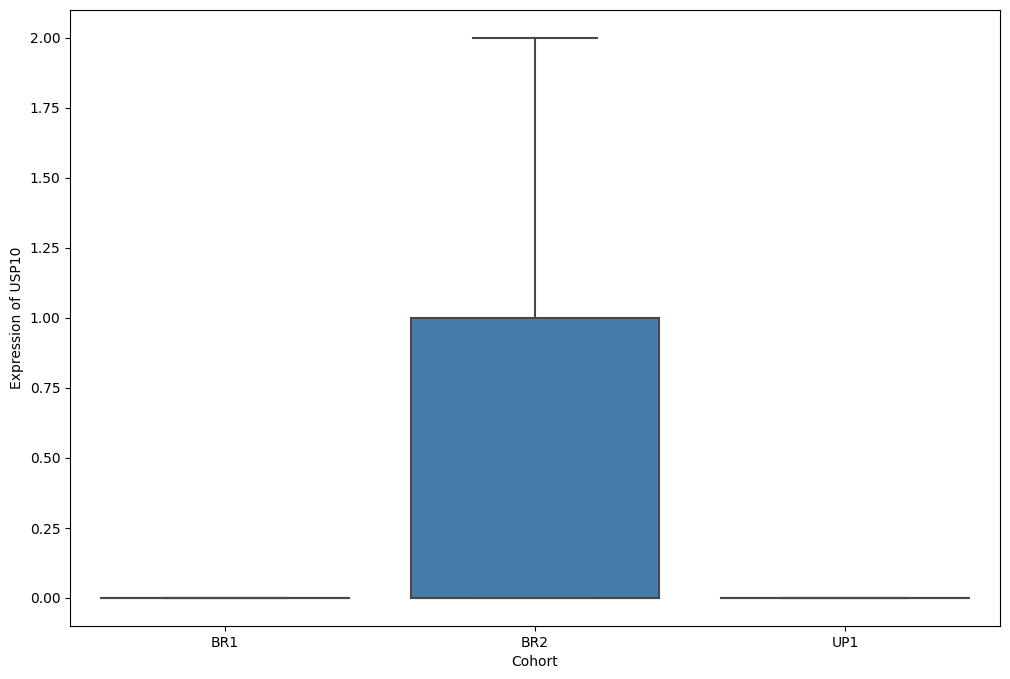

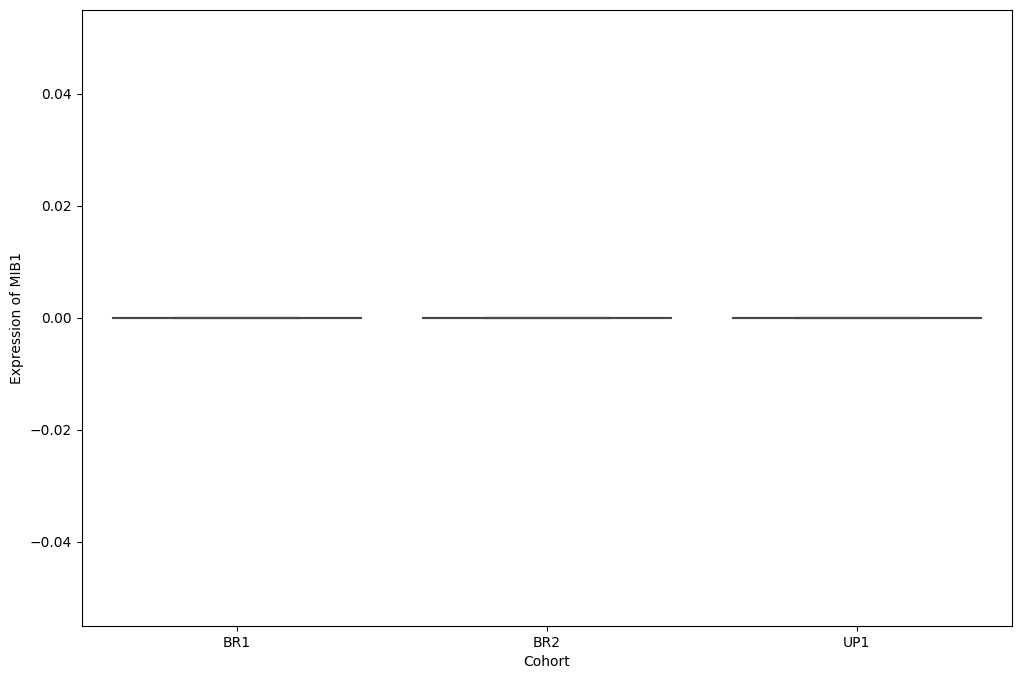

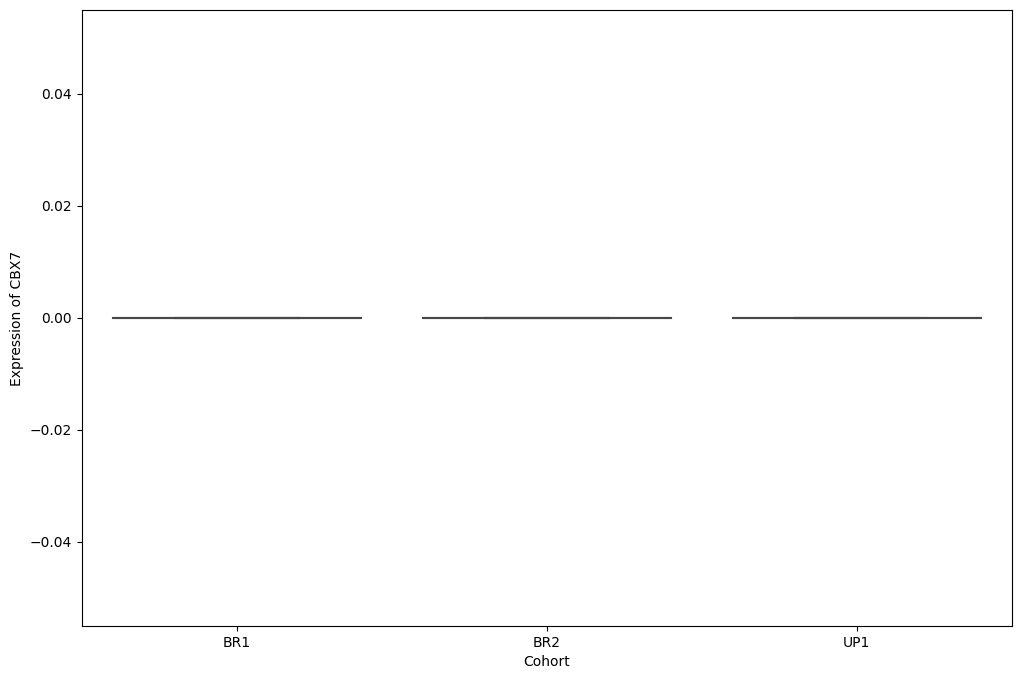

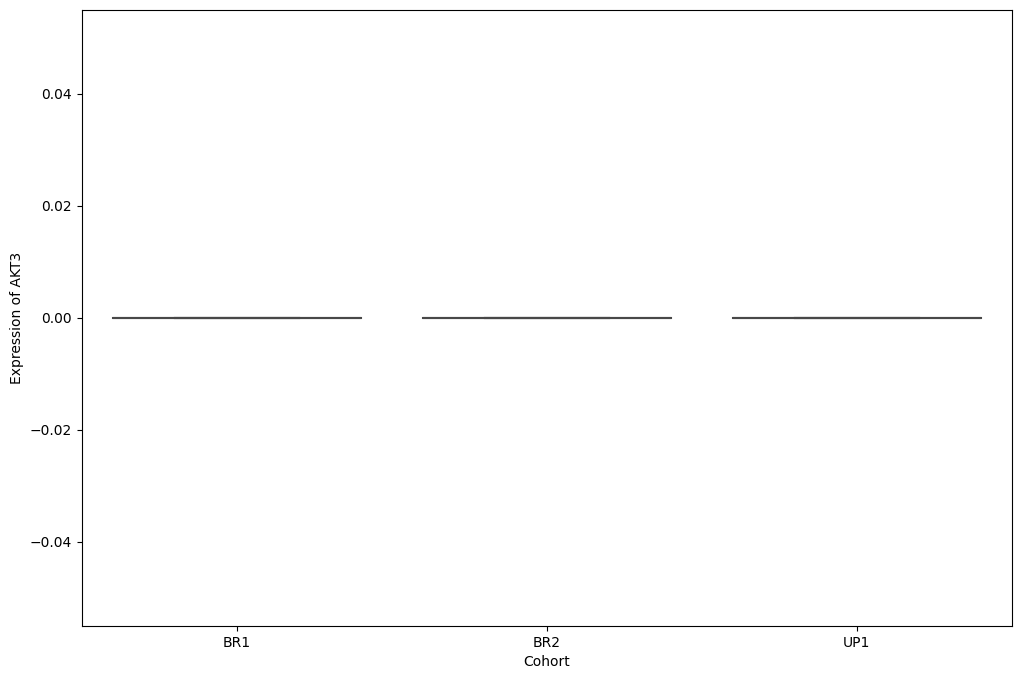

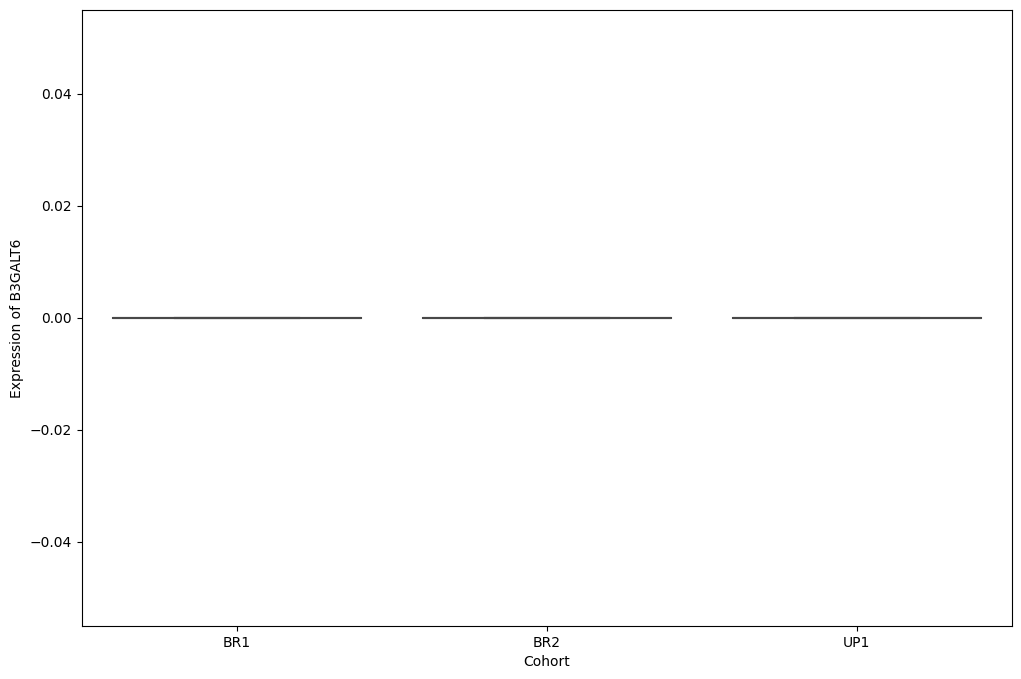

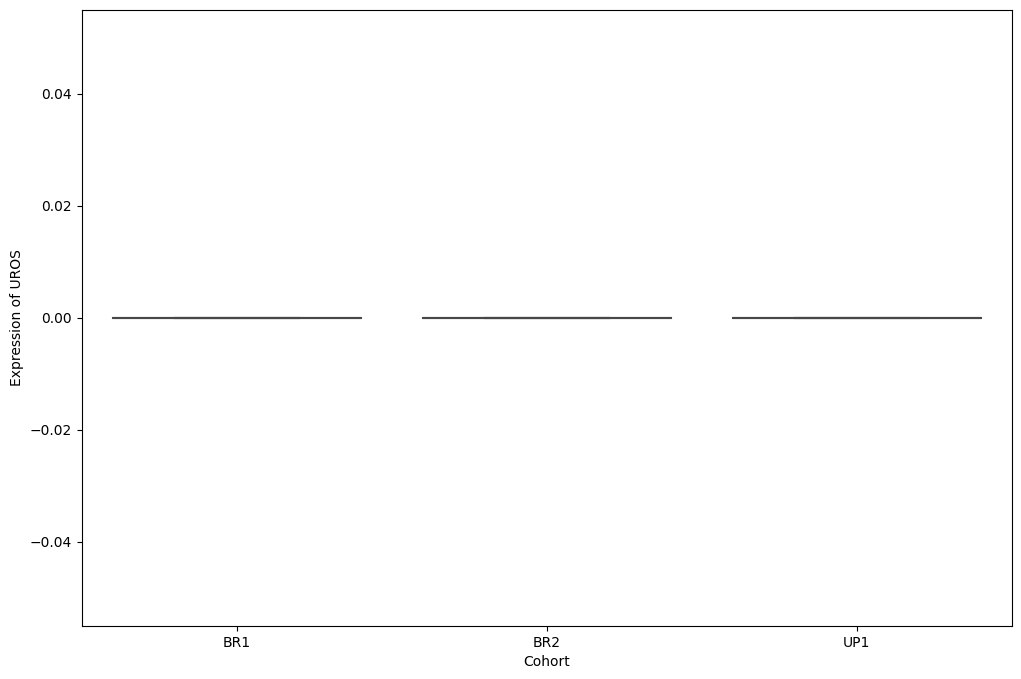

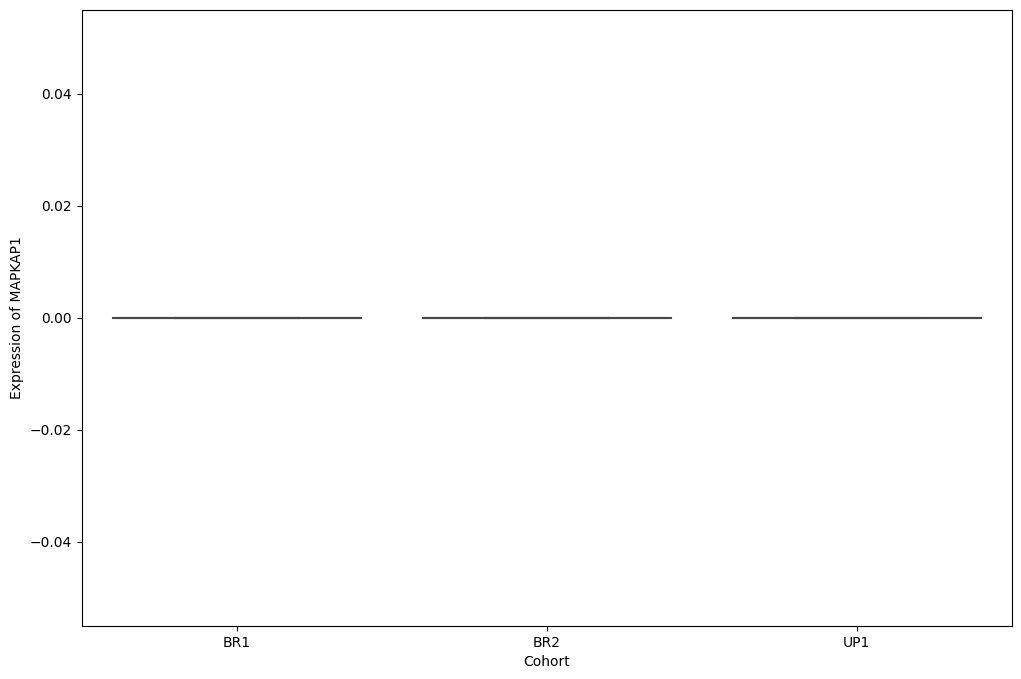

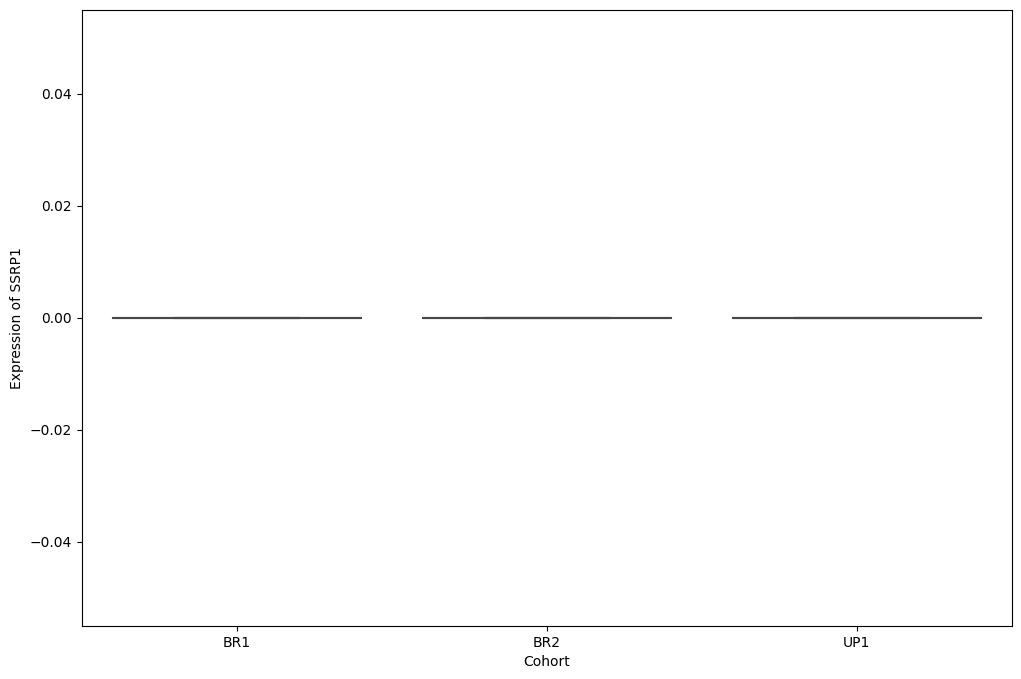

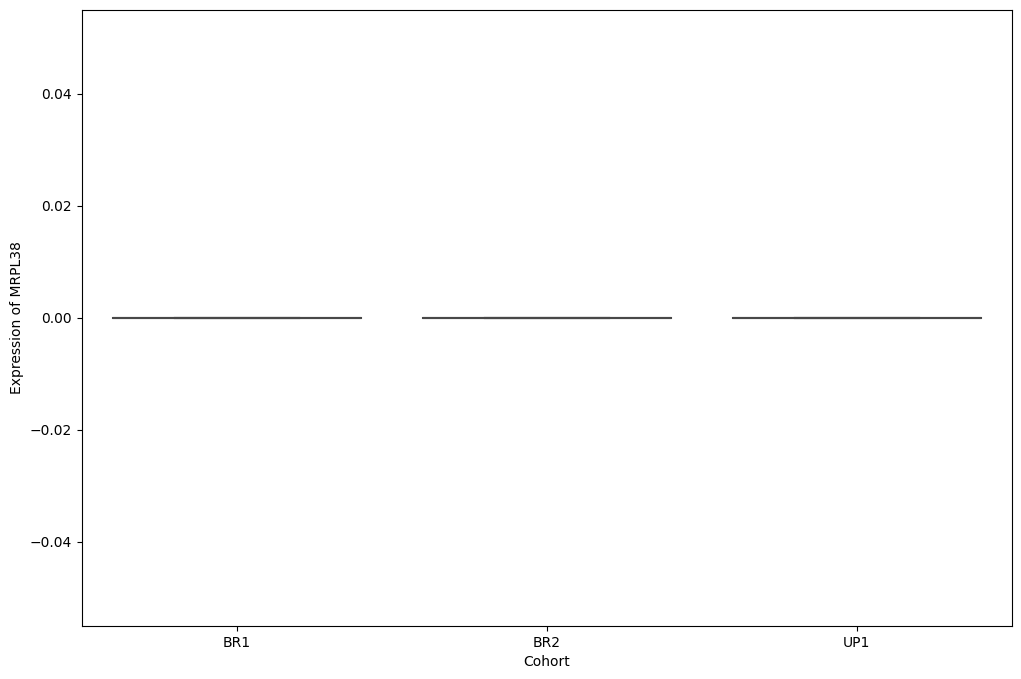

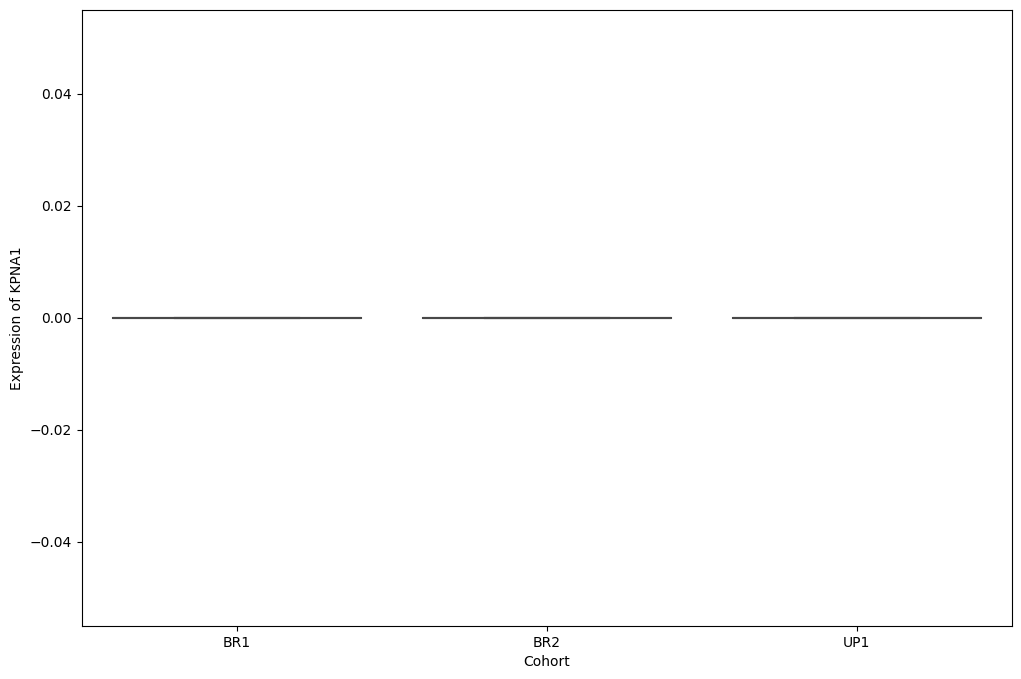

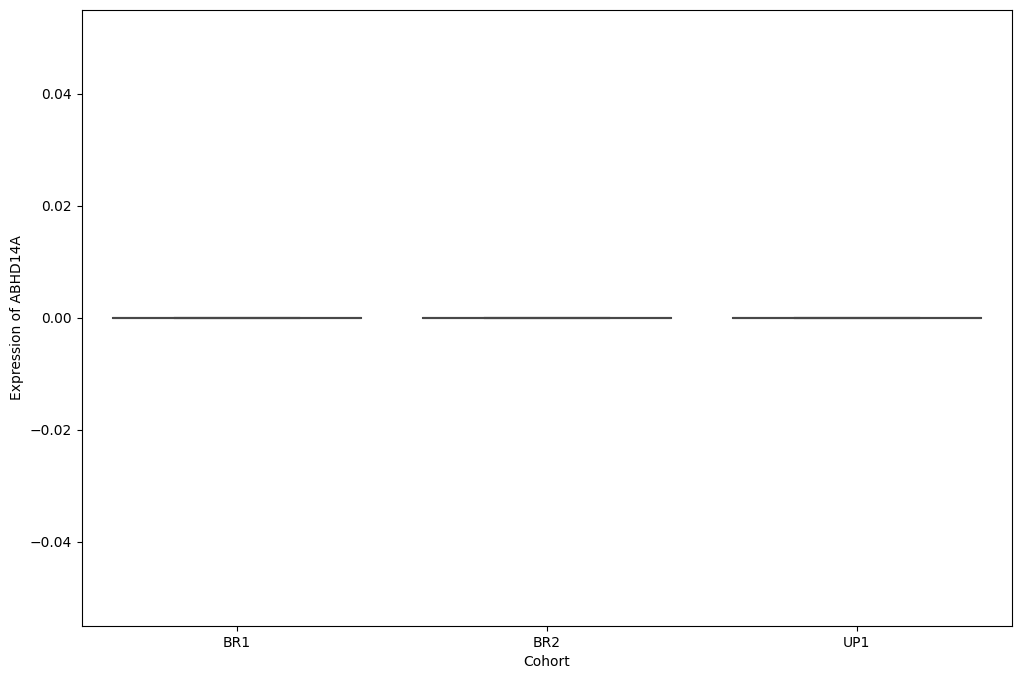

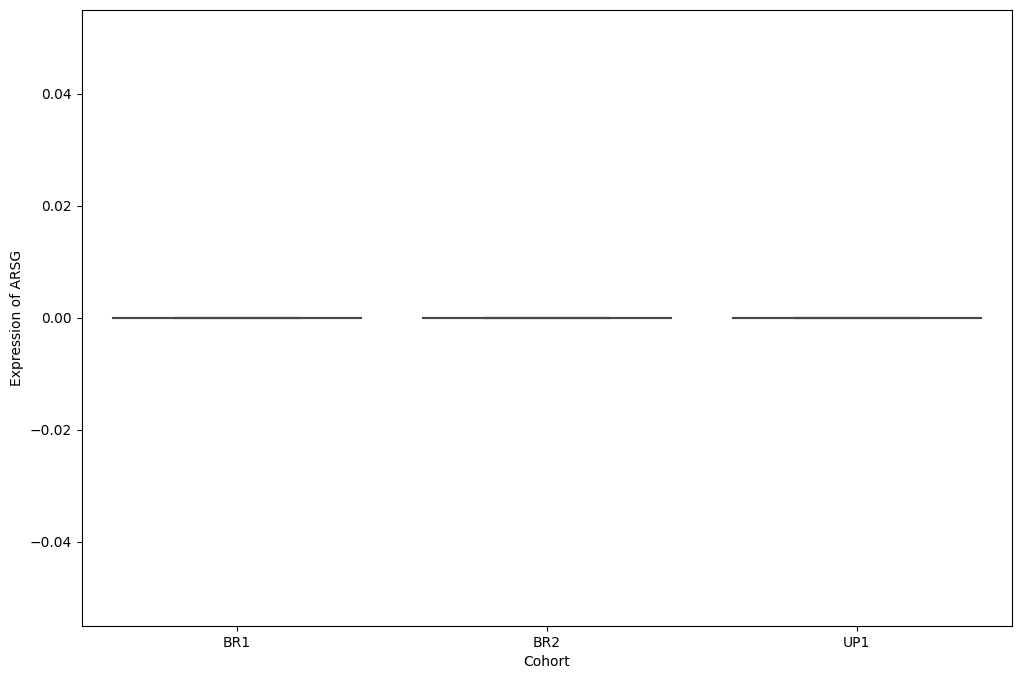

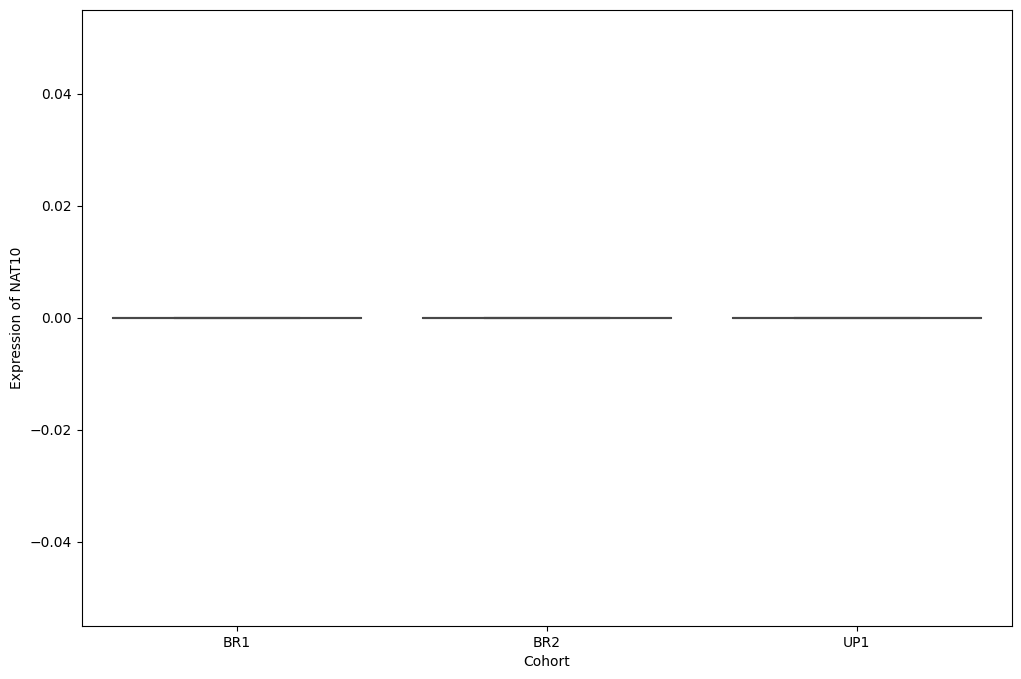

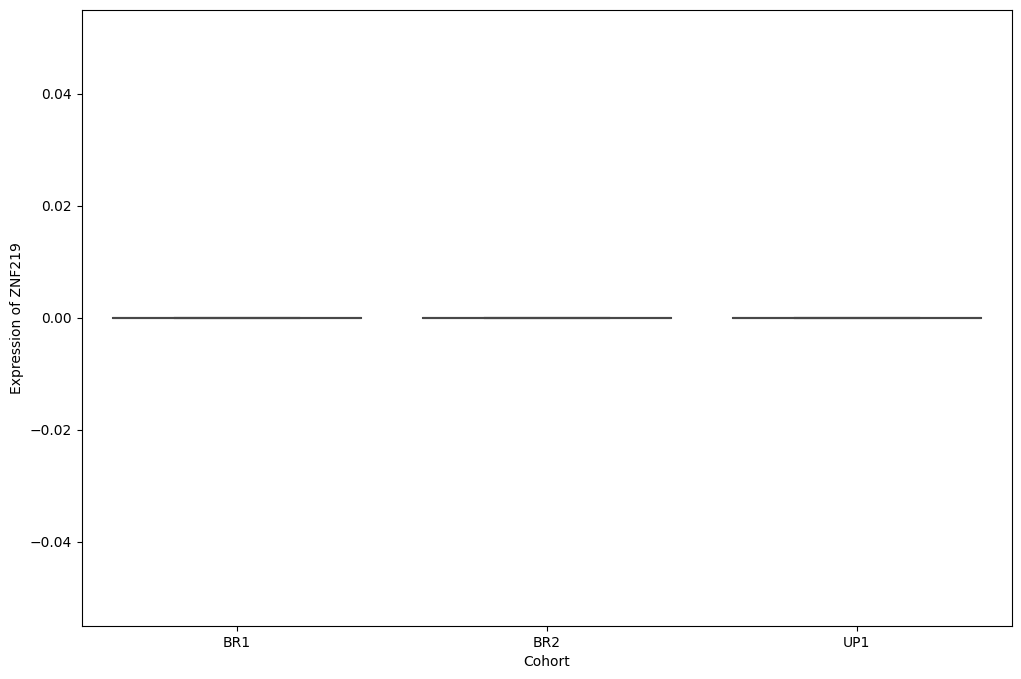

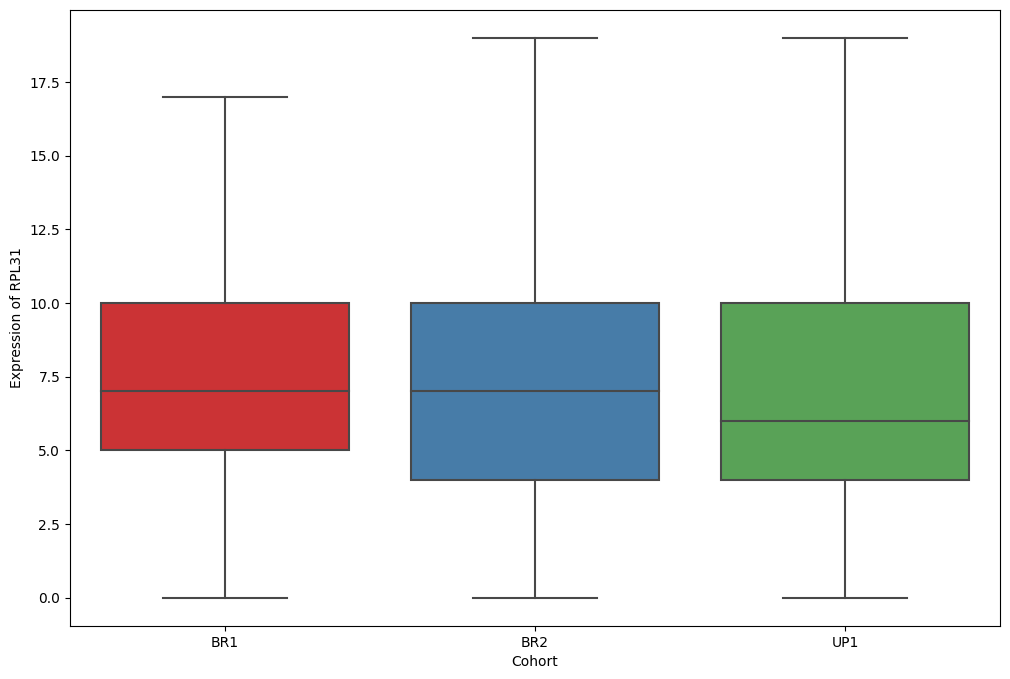

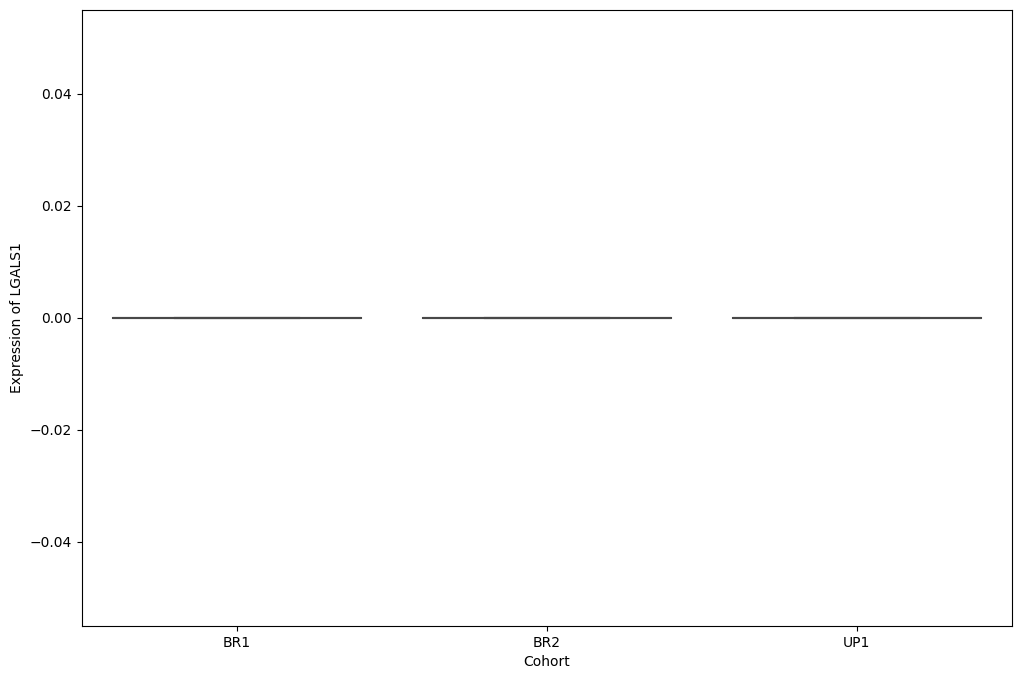

CPU times: user 3min 13s, sys: 1min 47s, total: 5min
Wall time: 4min 52s


In [72]:
%%time

def plot_gene_expression(adata, genes, subset_condition):
    # Filter the data for the subset condition
    subset_data = adata[subset_condition]

    # Check if the subset data is not empty
    if subset_data.shape[0] > 0:
        # Create an empty DataFrame for plotting
        plot_data = pd.DataFrame()

        # Iterate over the list of genes
        for gene in genes:
            # Check if the gene is present in the data
            if gene in subset_data.var_names:
                # Extract the expression data for the gene and ensure it is numeric
                expression_data = subset_data[:, gene].X.A.flatten()
                expression_data_numeric = pd.to_numeric(expression_data, errors='coerce')

                # Add the gene expression data to the DataFrame
                plot_data[gene] = expression_data_numeric

        # Check if any genes are available for plotting
        if not plot_data.empty:
            # Add the cohort information to the DataFrame
            plot_data['Cohort'] = subset_data.obs['cohort.cohortGuid'].tolist()

            # Check if there are at least two unique cohorts for plotting
            if plot_data['Cohort'].nunique() >= 2:
                # Create a boxplot for each gene without outliers and with linear y-axis
                for gene in genes:
                    plt.figure(figsize=(12, 8))
                    sns.boxplot(x='Cohort', y=gene, data=plot_data, palette='Set1', showfliers=False)
                    plt.xlabel('Cohort')
                    plt.ylabel(f'Expression of {gene}')
                    plt.show()
            else:
                print("Insufficient data: At least two unique cohorts required for plotting.")
        else:
            print("No genes available for plotting.")
    else:
        print("No data for the specified condition.")

# Example usage
genes_of_interest = ['CYFIP1','DST','GLO1','TIPARP','PDLIM5','DGKI','CD274','PTPRK','MCAM','GALC','ATPAF1','SLCO3A1','ZNF597','PLK2','RHBDD1','PRPF8','KLF2','E2F2','DOCK9','ARHGEF18','FAM50B','ZNF287','ZHX1','ELAC2','GRWD1','PRKG2','MAP3K5','ADHFE1','USP10','MIB1','CBX7','AKT3','B3GALT6','UROS','MAPKAP1','SSRP1','MRPL38','KPNA1','ABHD14A','ARSG','NAT10','ZNF219','RPL31','LGALS1']
#genes_of_interest = ['NFKB1', 'AIM2', 'FAS']
subset_condition = (adata.obs['AIFI_L2'] == 'Naive CD4 T cell')
plot_gene_expression(adata, genes_of_interest, subset_condition)

In [56]:
subset_data

View of AnnData object with n_obs × n_vars = 4355 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'subject.biologicalSex', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 'sample.visitDetails', 'subject.birthYear', 'CMV.IgG.Serology.Result.Interpretation', 'BMI', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'predicted.celltype.l2.5.score', 'predicted.celltype.l2.5', 'predicted_labels_celltypist', 'majority_voting_celltypist', 'predicted_doublet', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_

# DNA Methylation markers from T cell aging "test"

In [15]:
# Downloading reactome pathways
from pathlib import Path

if not Path("c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O 'c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

In [16]:
Path

pathlib.Path

In [17]:
def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

In [14]:
DNAm = gmt_to_decoupler("DNA_m.gmt")

In [15]:
react_hallmark = gmt_to_decoupler("Reactome_cyt_hallamark.gmt")

In [22]:
reac_hll_metab = gmt_to_decoupler("Reactome_hallmark_metabolism_mig.gmt")

In [23]:
reac_hll_metab

geneset genesymbol
0      REACTOME_CHEMOKINE_RECEPTORS_BIND_CHEMOKINES     CX3CL1
1      REACTOME_CHEMOKINE_RECEPTORS_BIND_CHEMOKINES      CXCL2
2      REACTOME_CHEMOKINE_RECEPTORS_BIND_CHEMOKINES     CXCL12
3      REACTOME_CHEMOKINE_RECEPTORS_BIND_CHEMOKINES       CCL1
4      REACTOME_CHEMOKINE_RECEPTORS_BIND_CHEMOKINES       CCR6
...                                             ...        ...
20144                             ZINC_TRANSPORTERS    SLC39A4
20145                             ZINC_TRANSPORTERS    SLC39A5
20146                             ZINC_TRANSPORTERS    SLC39A6
20147                             ZINC_TRANSPORTERS    SLC39A7
20148                             ZINC_TRANSPORTERS    SLC39A8

[20149 rows x 2 columns]

In [24]:
%%time
dc.run_aucell(
    adata,
    reac_hll_metab,
    source="geneset",
    target="genesymbol",
    use_raw=True,
)

CPU times: user 19h 9min 38s, sys: 1h 52min, total: 21h 1min 38s
Wall time: 1h 30min 14s


In [25]:
adata.obsm["aucell_estimate"]

source                            ABACAVIR_TRANSPORT_AND_METABOLISM  \
cf71f47048b611ea8957bafe6d70929e                           0.071227   
cf71fb7848b611ea8957bafe6d70929e                           0.000000   
cf7216a848b611ea8957bafe6d70929e                           0.058528   
cf72178448b611ea8957bafe6d70929e                           0.000000   
cf721a4048b611ea8957bafe6d70929e                           0.074839   
...                                                             ...   
07066dee608d11ed83fdb2a084f8f1d9                           0.037589   
0706f6f6608d11ed83fdb2a084f8f1d9                           0.000000   
07086234608d11ed83fdb2a084f8f1d9                           0.000000   
07092228608d11ed83fdb2a084f8f1d9                           0.031606   
070a6d7c608d11ed83fdb2a084f8f1d9                           0.076024   

source                            ABC_TRANSPORTERS  \
cf71f47048b611ea8957bafe6d70929e          0.008134   
cf71fb7848b611ea8957bafe6d70929e          0.000000   
cf7216a848b611ea8957bafe6d70929e          0.012050   
cf72178448b611ea8957bafe6d70929e          0.021712   
cf721a4048b611ea8957bafe6d70929e          0.000000   
...                                            ...   
07066dee608d11ed83fdb2a084f8f1d9          0.036627   
0706f6f6608d11ed83fdb2a084f8f1d9          0.000000   
07086234608d11ed83fdb2a084f8f1d9          0.014979   
07092228608d11ed83fdb2a084f8f1d9          0.037056   
070a6d7c608d11ed83fdb2a084f8f1d9          0.006351   

source                            ACTIVATION_OF_GENES_BY_ATF4  \
cf71f47048b611ea8957bafe6d70929e                     0.068112   
cf71fb7848b611ea8957bafe6d70929e                     0.074383   
cf7216a848b611ea8957bafe6d70929e                     0.012480   
cf72178448b611ea8957bafe6d70929e                     0.054397   
cf721a4048b611ea8957bafe6d70929e                     0.066197   
...                                                       ...   
07066dee608d11ed83fdb2a084f8f1d9                     0.000000   
0706f6f6608d11ed83fdb2a084f8f1d9                     0.101813   
07086234608d11ed83fdb2a084f8f1d9                     0.067217   
07092228608d11ed83fdb2a084f8f1d9                     0.066197   
070a6d7c608d11ed83fdb2a084f8f1d9                     0.027307   

source                            ACTIVATION_OF_KAINATE_RECEPTORS_UPON_GLUTAMATE_BINDING  \
cf71f47048b611ea8957bafe6d70929e                                           0.054543        
cf71fb7848b611ea8957bafe6d70929e                                           0.045617        
cf7216a848b611ea8957bafe6d70929e                                           0.061707        
cf72178448b611ea8957bafe6d70929e                                           0.084563        
cf721a4048b611ea8957bafe6d70929e                                           0.086324        
...                                                                             ...        
07066dee608d11ed83fdb2a084f8f1d9                                           0.070727        
0706f6f6608d11ed83fdb2a084f8f1d9                                           0.071761        
07086234608d11ed83fdb2a084f8f1d9                                           0.066734        
07092228608d11ed83fdb2a084f8f1d9                                           0.052123        
070a6d7c608d11ed83fdb2a084f8f1d9                                           0.056469        

source                            ACYL_CHAIN_REMODELLING_OF_PC_PE_PG_PS  \
cf71f47048b611ea8957bafe6d70929e                               0.000000   
cf71fb7848b611ea8957bafe6d70929e                               0.020187   
cf7216a848b611ea8957bafe6d70929e                               0.033813   
cf72178448b611ea8957bafe6d70929e                               0.052582   
cf721a4048b611ea8957bafe6d70929e                               0.000000   
...                                                                 ...   
07066dee608d11ed83fdb2a084f8f1d9                               0.000000   
0706f6f6608d

In [26]:
adata.write_h5ad('ID_reactome_hallmark_metabol_miguel.h5ad')

### Can start here for DNAm if further work

In [253]:
%%time
adata_DNAm=sc.read_h5ad("ID_DNAm.h5ad")

CPU times: user 17.7 s, sys: 1min 12s, total: 1min 30s
Wall time: 9min 4s


In [309]:
adata_DNAm

AnnData object with n_obs × n_vars = 1828803 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'subject.biologicalSex', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 'sample.visitDetails', 'subject.birthYear', 'CMV.IgG.Serology.Result.Interpretation', 'BMI', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'predicted.celltype.l2.5.score', 'predicted.celltype.l2.5', 'predicted_labels_celltypist', 'majority_voting_celltypist', 'predicted_doublet', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_to

In [310]:
%%time

# Convert aucell_estimate to a DataFrame
aucell_df = pd.DataFrame(adata_DNAm.obsm['aucell_estimate'], index=adata_DNAm.obs.index)

# Ensure all values in aucell_df are numeric
aucell_df = aucell_df.apply(pd.to_numeric, errors='coerce')

# Merge aucell_df with only the necessary columns from adata.obs for grouping
necessary_columns = ['subject.subjectGuid', 'AIFI_L3']
merged_data = adata_DNAm.obs[necessary_columns].join(aucell_df)

# Checking the structure of the merged data
print("Merged Data Columns:", merged_data.columns)
print("Original adata.obs shape:", adata.obs.shape)
print("Merged Data shape:", merged_data.shape)

# Check if the merge was successful
if not merged_data.shape[1] > len(necessary_columns):
    raise ValueError("Merge unsuccessful, check the index alignment and structure of aucell_estimate.")

# Group by 'subject.subjectGuid' and 'AIFI_L1', then calculate the mean for each numeric column
grouped_data = merged_data.groupby(['subject.subjectGuid', 'AIFI_L3']).mean()

# Create mappings for 'cohort.cohortGuid', 'AIFI_L2', and 'AIFI_L3'
cohort_mapping = adata_DNAm.obs[['subject.subjectGuid', 'cohort.cohortGuid']].drop_duplicates().set_index('subject.subjectGuid')['cohort.cohortGuid'].to_dict()
aifi_l1_mapping = adata_DNAm.obs[['AIFI_L3', 'AIFI_L1']].drop_duplicates().set_index('AIFI_L3')['AIFI_L1'].to_dict()
aifi_l2_mapping = adata_DNAm.obs[['AIFI_L3', 'AIFI_L2']].drop_duplicates().set_index('AIFI_L3')['AIFI_L2'].to_dict()
CMV_mapping = adata_DNAm.obs[['subject.subjectGuid', 'CMV.IgG.Serology.Result.Interpretation']].drop_duplicates().set_index('subject.subjectGuid')['CMV.IgG.Serology.Result.Interpretation'].to_dict()

# Add 'cohort.cohortGuid', 'CMV', 'AIFI_L2', and 'AIFI_L3' to the grouped data
grouped_data['cohort.cohortGuid'] = grouped_data.index.get_level_values('subject.subjectGuid').map(cohort_mapping)
grouped_data['AIFI_L1'] = grouped_data.index.get_level_values('AIFI_L3').map(aifi_l1_mapping)
grouped_data['AIFI_L2'] = grouped_data.index.get_level_values('AIFI_L3').map(aifi_l2_mapping)
grouped_data['CMV.IgG.Serology.Result.Interpretation'] = grouped_data.index.get_level_values('subject.subjectGuid').map(CMV_mapping)

# Resetting index to make it a standard DataFrame
result_df = grouped_data.reset_index()

# Reorder columns to put 'cohort.cohortGuid', 'AIFI_L2', and 'AIFI_L3' first
cols = ['cohort.cohortGuid', 'CMV.IgG.Serology.Result.Interpretation', 'AIFI_L1', 'AIFI_L2'] + [col for col in result_df.columns if col not in ['cohort.cohortGuid', 'CMV.IgG.Serology.Result.Interpretation', 'AIFI_L1', 'AIFI_L2']]
result_df = result_df[cols]
# Display the first few rows of the resulting DataFrame
print(result_df.head())

Merged Data Columns: Index(['subject.subjectGuid', 'AIFI_L3', 'DNA_clock_UP', 'DNA_clock_down'], dtype='object')
Original adata.obs shape: (1828803, 62)
Merged Data shape: (1828803, 4)
  cohort.cohortGuid CMV.IgG.Serology.Result.Interpretation          AIFI_L1  \
0               BR1                               Negative               DC   
1               BR1                               Negative           B cell   
2               BR1                               Negative          NK cell   
3               BR1                               Negative  Progenitor cell   
4               BR1                               Negative         Monocyte   

           AIFI_L2 subject.subjectGuid                  AIFI_L3  DNA_clock_UP  \
0             ASDC              BR1001                     ASDC      0.056005   
1    Memory B cell              BR1001  Activated memory B cell      0.053893   
2  CD56dim NK cell              BR1001         Adaptive NK cell      0.064245   
3  Progenitor ce

In [311]:
%%time

# split cat and num
obs_data = result_df.iloc[:, :6]
X_data = result_df.iloc[:, 6:]

# Create an AnnData object
adata1 = ad.AnnData(X=X_data)
adata1.obs = obs_data

#some samples do not have erythros. make their scores 0
adata1.X[np.isnan(adata1.X)] = 0

#set rownames as subjectID
adata1.obs_names = adata1.obs['subject.subjectGuid']
adata1.obs

CPU times: user 6.12 ms, sys: 0 ns, total: 6.12 ms
Wall time: 5.75 ms


cohort.cohortGuid CMV.IgG.Serology.Result.Interpretation  \
subject.subjectGuid                                                            
BR1001                            BR1                               Negative   
BR1001                            BR1                               Negative   
BR1001                            BR1                               Negative   
BR1001                            BR1                               Negative   
BR1001                            BR1                               Negative   
...                               ...                                    ...   
UP1034                            UP1                                Unknown   
UP1034                            UP1                                Unknown   
UP1034                            UP1                                Unknown   
UP1034                            UP1                                Unknown   
UP1034                            UP1                                Unknown   

                             AIFI_L1              AIFI_L2 subject.subjectGuid  \
subject.subjectGuid                                                             
BR1001                            DC                 ASDC              BR1001   
BR1001                        B cell        Memory B cell              BR1001   
BR1001                       NK cell      CD56dim NK cell              BR1001   
BR1001               Progenitor cell      Progenitor cell              BR1001   
BR1001                      Monocyte        CD16 monocyte              BR1001   
...                              ...                  ...                 ...   
UP1034                        T cell     Naive CD8 T cell              UP1034   
UP1034                        B cell  Transitional B cell              UP1034   
UP1034                        B cell        Memory B cell              UP1034   
UP1034                            DC                 cDC1              UP1034   
UP1034                            DC                  pDC              UP1034   

                                            AIFI_L3  
subject.subjectGuid                                  
BR1001                                         ASDC  
BR1001                      Activated memory B cell  
BR1001                             Adaptive NK cell  
BR1001                                 BaEoMaP cell  
BR1001                           C1Q+ CD16 monocyte  
...                                             ...  
UP1034                       SOX4+ naive CD8 T cell  
UP1034                          Transitional B cell  
UP1034               Type 2 polarized memory B cell  
UP1034                                         cDC1  
UP1034                                          pDC  

[7668 rows x 6 columns]

In [312]:
#get rid of UP1
adata1_1 = adata1[adata1.obs['cohort.cohortGuid'].isin(['BR1', 'BR2'])]

In [313]:
unique = adata1_1.obs['AIFI_L1'].unique()
print(unique)

['DC' 'B cell' 'NK cell' 'Progenitor cell' 'Monocyte' 'T cell'
 'Erythrocyte' 'ILC' 'Platelet']


In [314]:
df = dc.rank_sources_groups(adata1_1, groupby='cohort.cohortGuid', reference='BR2', method='t-test')
df

group reference           names  statistic  meanchange     pvals  pvals_adj
0   BR1       BR2    DNA_clock_UP   1.913510    0.000752  0.055728   0.111455
1   BR1       BR2  DNA_clock_down   0.823503    0.000206  0.410253   0.410253

#### RUN Function for plotting (it's in the hallmark analysis section) then run the following code

In [214]:
source_markers = df[df['pvals'] < 0.15].groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers

{'BR1': ['DNA_clock_UP']}

In [326]:
Naive_mem_CD4 = adata1_1[adata1_1.obs['AIFI_L2'].isin(['Memory CD4 T cell', 'Naive CD4 T cell'])]

In [327]:
adata1_1

View of AnnData object with n_obs × n_vars = 6532 × 2
    obs: 'cohort.cohortGuid', 'CMV.IgG.Serology.Result.Interpretation', 'AIFI_L1', 'AIFI_L2', 'subject.subjectGuid', 'AIFI_L3'

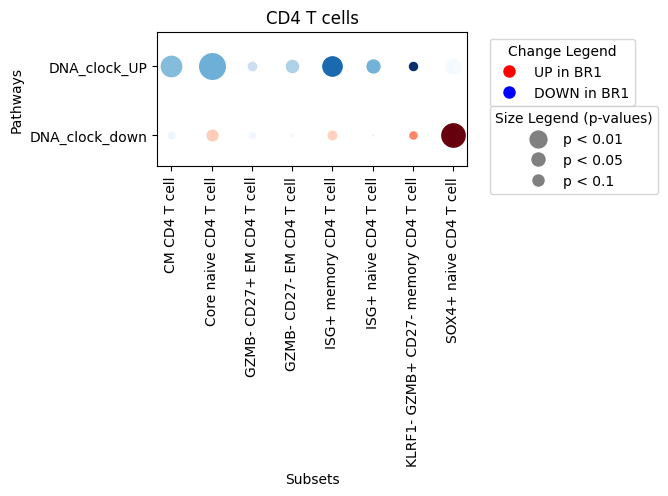

In [380]:
plot_ann_data(Naive_mem_CD4, 'AIFI_L3', 'cohort.cohortGuid', 'BR2', 'wilcoxon', 'CD4 T cells', fig_size=(4,1.75))

In [227]:
negative_cmv_subset = adata1_1[adata1_1.obs['CMV.IgG.Serology.Result.Interpretation'] == 'Negative'].copy()

In [317]:
Naive_mem_CD4 = negative_cmv_subset[negative_cmv_subset.obs['AIFI_L2'].isin(['Memory CD4 T cell', 'Naive CD4 T cell'])]

NameError: name 'negative_cmv_subset' is not defined

In [318]:
plot_ann_data(Naive_mem_CD4, 'AIFI_L3', 'cohort.cohortGuid', 'BR2', 'wilcoxon', 'CD4 T cells', fig_size=(10,6))

NameError: name 'Naive_mem_CD4' is not defined

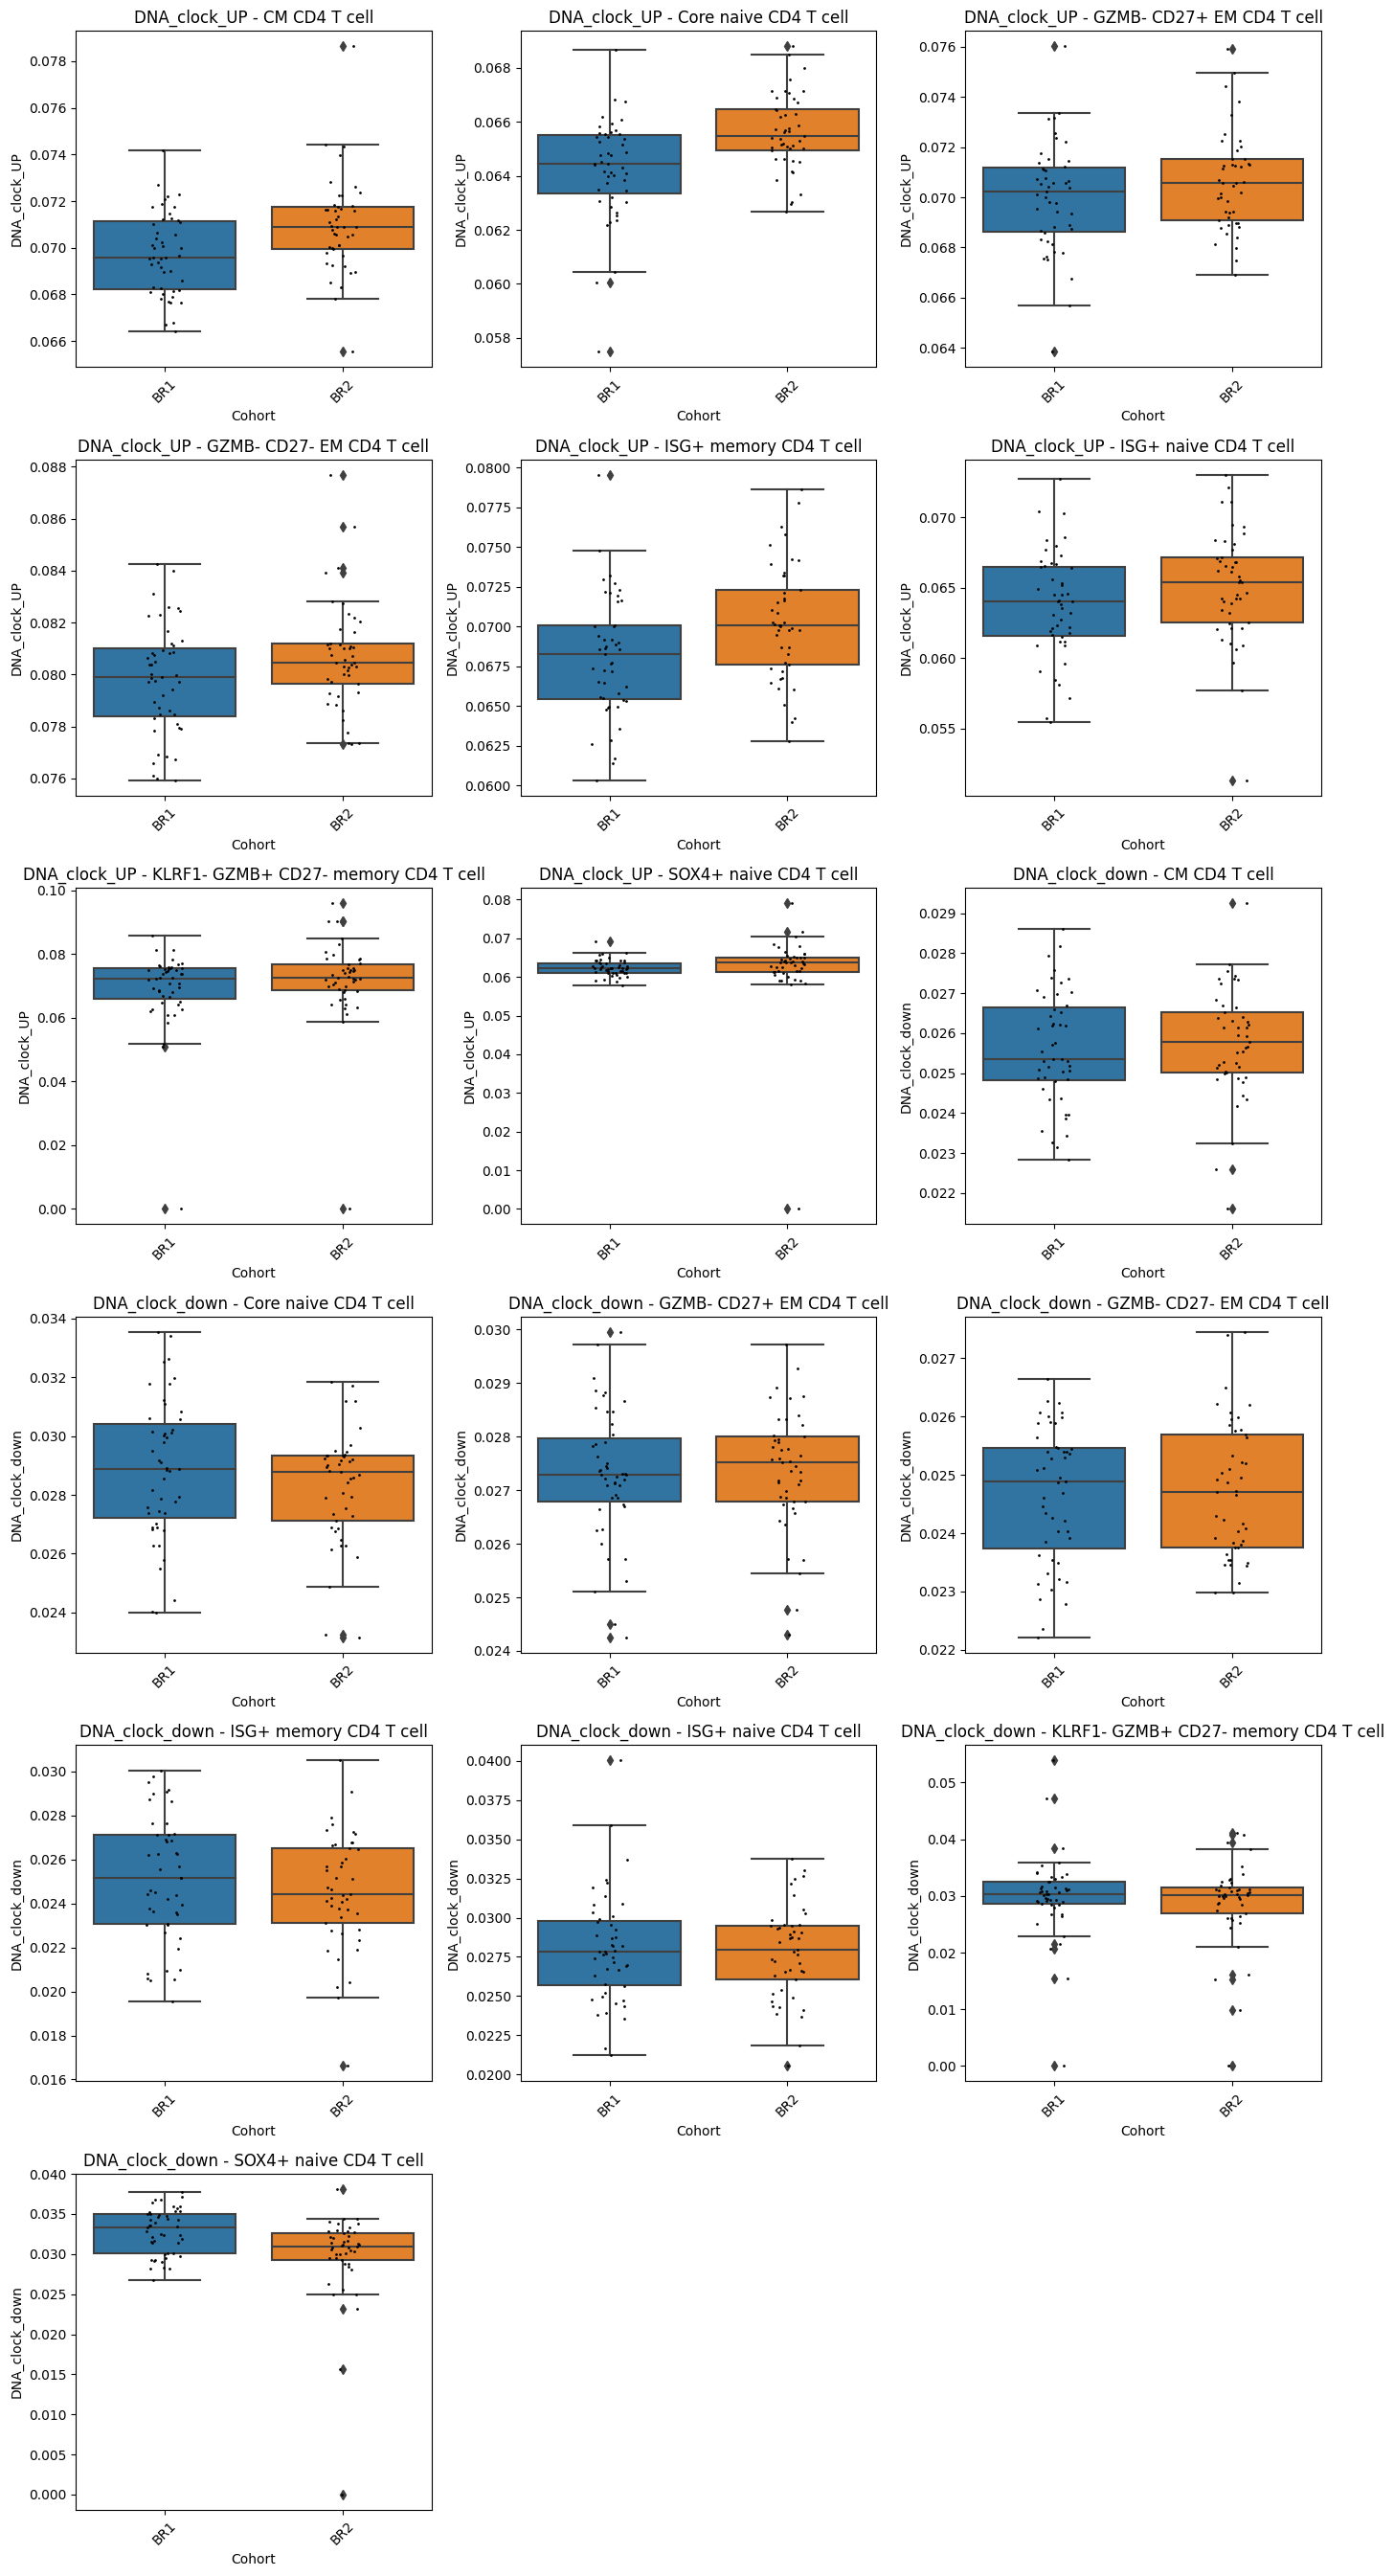

In [381]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

# Your existing code to get source_markers
source_markers = sig_pathways(Naive_mem_CD4, 'AIFI_L3', 'cohort.cohortGuid', 'BR2', 'wilcoxon')

# Calculate the total number of plots and the number of rows needed
num_categories = len(Naive_mem_CD4.obs['AIFI_L3'].unique())
total_plots = len(source_markers) * num_categories
num_rows = math.ceil(total_plots / 3)  # 3 plots per row

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(14, 4.5 * num_rows))  # Adjust the size as needed
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Iterate over markers and categories and plot
plot_index = 0
for marker in source_markers:
    for category in Naive_mem_CD4.obs['AIFI_L3'].unique():
        category_data = Naive_mem_CD4[Naive_mem_CD4.obs['AIFI_L3'] == category]
        df = pd.DataFrame({
            marker: category_data.obs_vector(marker),
            'Cohort': category_data.obs['cohort.cohortGuid']
        })

        ax = axes[plot_index]
        sns.boxplot(x='Cohort', y=marker, data=df, ax=ax)
        sns.stripplot(x='Cohort', y=marker, data=df, ax=ax, color='black', size=2)
        ax.set_title(f'{marker} - {category}')
        ax.set_ylabel(marker)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

        plot_index += 1

# Hide any unused subplots
for i in range(plot_index, len(axes)):
    axes[i].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

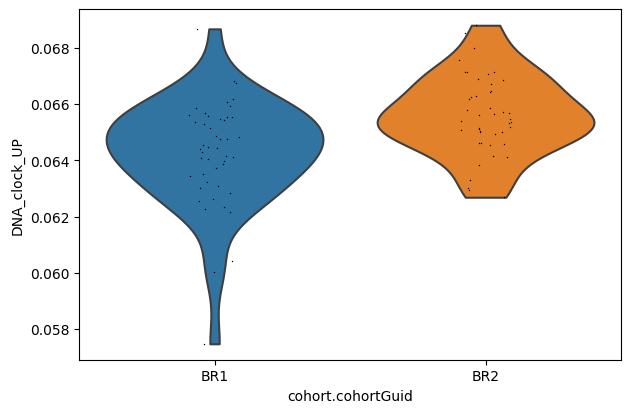

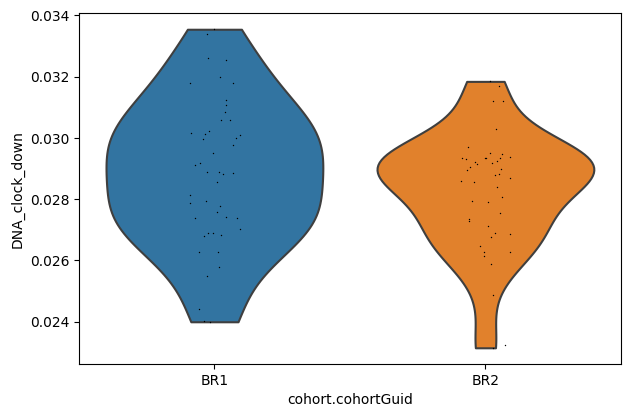

In [216]:
import scanpy as sc

source_markers = CD56dim_NK.var_names.tolist()

# Loop through each source marker and create a violin plot
for marker in source_markers:
    sc.pl.violin(CD56dim_NK, keys=marker, groupby='cohort.cohortGuid')

# AUCELL

In [10]:
# Downloading reactome pathways
from pathlib import Path

if not Path("c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O 'c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

In [11]:
Path

pathlib.Path

In [12]:
def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

In [ ]:
reactome = gmt_to_decoupler("c2.cp.v7.2.symbols.gmt")

In [ ]:
hallmark = gmt_to_decoupler("h.all.v2023.2.Hs.symbols.gmt")

In [13]:
reac_hll_metab = gmt_to_decoupler("Reactome_hallmark_metabolism_mig.gmt")

In [34]:
unique_categories_AIFI_L1 = adata.obs['AIFI_L1'].unique()
print(unique_categories_AIFI_L1)

['T cell', 'NK cell', 'ILC', 'Monocyte', 'DC', 'Progenitor cell', 'Platelet', 'Erythrocyte', 'B cell']
Categories (9, object): ['B cell', 'DC', 'Erythrocyte', 'ILC', ..., 'NK cell', 'Platelet', 'Progenitor cell', 'T cell']


In [97]:
pdata = dc.get_pseudobulk(
    adata,
    sample_col='individual',
    groups_col='cell_type',
    layer='counts',
    mode='sum',
    min_cells=0,
    min_counts=0
)

AnnData object with n_obs × n_vars = 1828803 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'subject.biologicalSex', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 'sample.visitDetails', 'subject.birthYear', 'CMV.IgG.Serology.Result.Interpretation', 'BMI', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'predicted.celltype.l2.5.score', 'predicted.celltype.l2.5', 'predicted_labels_celltypist', 'majority_voting_celltypist', 'predicted_doublet', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_to

In [42]:
#subset on T cells
subset_condition = adata.obs['AIFI_L1'] == 'Platelet'
adata_Tcell = adata[subset_condition, :]

In [43]:
adata_Tcell

View of AnnData object with n_obs × n_vars = 8037 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'subject.biologicalSex', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 'sample.visitDetails', 'subject.birthYear', 'CMV.IgG.Serology.Result.Interpretation', 'BMI', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'predicted.celltype.l2.5.score', 'predicted.celltype.l2.5', 'predicted_labels_celltypist', 'majority_voting_celltypist', 'predicted_doublet', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_

In [57]:
%%time
dc.run_aucell(
    adata,
    hallmark,
    source="geneset",
    target="genesymbol",
    use_raw=True,
)

CPU times: user 19h 5min 21s, sys: 1h 51min 55s, total: 20h 57min 17s
Wall time: 1h 28min 2s


In [58]:
adata.obsm["aucell_estimate"]

source                            HALLMARK_ADIPOGENESIS  \
cf71f47048b611ea8957bafe6d70929e               0.064870   
cf71fb7848b611ea8957bafe6d70929e               0.063596   
cf7216a848b611ea8957bafe6d70929e               0.084751   
cf72178448b611ea8957bafe6d70929e               0.066633   
cf721a4048b611ea8957bafe6d70929e               0.071452   
...                                                 ...   
07066dee608d11ed83fdb2a084f8f1d9               0.052819   
0706f6f6608d11ed83fdb2a084f8f1d9               0.054747   
07086234608d11ed83fdb2a084f8f1d9               0.065896   
07092228608d11ed83fdb2a084f8f1d9               0.053896   
070a6d7c608d11ed83fdb2a084f8f1d9               0.086459   

source                            HALLMARK_ALLOGRAFT_REJECTION  \
cf71f47048b611ea8957bafe6d70929e                      0.166319   
cf71fb7848b611ea8957bafe6d70929e                      0.147190   
cf7216a848b611ea8957bafe6d70929e                      0.150809   
cf72178448b611ea8957bafe6d70929e                      0.104827   
cf721a4048b611ea8957bafe6d70929e                      0.202286   
...                                                        ...   
07066dee608d11ed83fdb2a084f8f1d9                      0.139280   
0706f6f6608d11ed83fdb2a084f8f1d9                      0.144296   
07086234608d11ed83fdb2a084f8f1d9                      0.138397   
07092228608d11ed83fdb2a084f8f1d9                      0.116199   
070a6d7c608d11ed83fdb2a084f8f1d9                      0.128248   

source                            HALLMARK_ANDROGEN_RESPONSE  \
cf71f47048b611ea8957bafe6d70929e                    0.086405   
cf71fb7848b611ea8957bafe6d70929e                    0.053564   
cf7216a848b611ea8957bafe6d70929e                    0.065900   
cf72178448b611ea8957bafe6d70929e                    0.053141   
cf721a4048b611ea8957bafe6d70929e                    0.119260   
...                                                      ...   
07066dee608d11ed83fdb2a084f8f1d9                    0.073047   
0706f6f6608d11ed83fdb2a084f8f1d9                    0.080420   
07086234608d11ed83fdb2a084f8f1d9                    0.081731   
07092228608d11ed83fdb2a084f8f1d9                    0.085439   
070a6d7c608d11ed83fdb2a084f8f1d9                    0.052077   

source                            HALLMARK_ANGIOGENESIS  \
cf71f47048b611ea8957bafe6d70929e               0.059967   
cf71fb7848b611ea8957bafe6d70929e               0.086539   
cf7216a848b611ea8957bafe6d70929e               0.031088   
cf72178448b611ea8957bafe6d70929e               0.012022   
cf721a4048b611ea8957bafe6d70929e               0.001987   
...                                                 ...   
07066dee608d11ed83fdb2a084f8f1d9               0.015514   
0706f6f6608d11ed83fdb2a084f8f1d9               0.000000   
07086234608d11ed83fdb2a084f8f1d9               0.001144   
07092228608d11ed83fdb2a084f8f1d9               0.021434   
070a6d7c608d11ed83fdb2a084f8f1d9               0.026070   

source                            HALLMARK_APICAL_JUNCTION  \
cf71f47048b611ea8957bafe6d70929e                  0.051503   
cf71fb7848b611ea8957bafe6d70929e                  0.053983   
cf7216a848b611ea8957bafe6d70929e                  0.071060   
cf72178448b611ea8957bafe6d70929e                  0.079270   
cf721a4048b611ea8957bafe6d70929e                  0.072177   
...                                                    ...   
07066dee608d11ed83fdb2a084f8f1d9                  0.069553   
0706f6f6608d11ed83fdb2a084f8f1d9                  0.049255   
07086234608d11ed83fdb2a084f8f1d9                  0.035967   
07092228608d11ed83fdb2a084f8f1d9                  0.059227   
070a6d7c608d11ed83fdb2a084f8f1d9                  0.035996   

source                            HALLMARK_APICAL_SURFACE  HALLMARK_APOPTOSIS  \
cf71f47048b611ea8957bafe6d70929e                 0.047865            0.090686   
cf71fb7848b611ea8957bafe6d70929e                 0.051303            0.087853   
cf7216a848b611ea8957bafe6d70929e

In [59]:
adata.write_h5ad('ID_hallmarks.h5ad')

# START HERE IF WANT TO JUST STICK TO HALLMARK LABELS

In [11]:
%%time
adata=sc.read_h5ad("ID_reactome_hallmark_metabol_miguel.h5ad")

CPU times: user 15.8 s, sys: 1min 3s, total: 1min 19s
Wall time: 9min 33s


In [18]:
unique_categories_cohort = adata.obs['cohort.cohortGuid'].unique()
print(unique_categories_cohort)

['BR1', 'BR2', 'UP1']
Categories (3, object): ['BR1', 'BR2', 'UP1']


In [19]:
unique_categories_CMV = adata.obs['CMV.IgG.Serology.Result.Interpretation'].unique()
print(unique_categories_CMV)

['Negative', 'Positive', 'Unknown']
Categories (3, object): ['Negative', 'Positive', 'Unknown']


In [20]:
unique_categories_subject = adata.obs['subject.subjectGuid'].unique()
print(unique_categories_subject)

['BR1001', 'BR1002', 'BR1003', 'BR1004', 'BR1005', ..., 'UP1025', 'UP1026', 'UP1031', 'UP1032', 'UP1034']
Length: 108
Categories (108, object): ['BR1001', 'BR1002', 'BR1003', 'BR1004', ..., 'UP1026', 'UP1031', 'UP1032', 'UP1034']


In [21]:
unique_AIFIL1 = adata.obs['AIFI_L1'].unique()
print(unique_AIFIL1)

['T cell', 'NK cell', 'ILC', 'Monocyte', 'DC', 'Progenitor cell', 'Platelet', 'Erythrocyte', 'B cell']
Categories (9, object): ['B cell', 'DC', 'Erythrocyte', 'ILC', ..., 'NK cell', 'Platelet', 'Progenitor cell', 'T cell']


In [22]:
adata

AnnData object with n_obs × n_vars = 1828803 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'subject.biologicalSex', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 'sample.visitDetails', 'subject.birthYear', 'CMV.IgG.Serology.Result.Interpretation', 'BMI', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'predicted.celltype.l2.5.score', 'predicted.celltype.l2.5', 'predicted_labels_celltypist', 'majority_voting_celltypist', 'predicted_doublet', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_to

In [23]:
%%time

# Convert aucell_estimate to a DataFrame
aucell_df = pd.DataFrame(adata.obsm['aucell_estimate'], index=adata.obs.index)

# Ensure all values in aucell_df are numeric
aucell_df = aucell_df.apply(pd.to_numeric, errors='coerce')

# Merge aucell_df with only the necessary columns from adata.obs for grouping
necessary_columns = ['subject.subjectGuid', 'AIFI_L3']
merged_data = adata.obs[necessary_columns].join(aucell_df)

# Checking the structure of the merged data
print("Merged Data Columns:", merged_data.columns)
print("Original adata.obs shape:", adata.obs.shape)
print("Merged Data shape:", merged_data.shape)

# Check if the merge was successful
if not merged_data.shape[1] > len(necessary_columns):
    raise ValueError("Merge unsuccessful, check the index alignment and structure of aucell_estimate.")

# Group by 'subject.subjectGuid' and 'AIFI_L1', then calculate the mean for each numeric column
grouped_data = merged_data.groupby(['subject.subjectGuid', 'AIFI_L3']).mean()

# Create mappings for 'cohort.cohortGuid', 'AIFI_L2', and 'AIFI_L3'
cohort_mapping = adata.obs[['subject.subjectGuid', 'cohort.cohortGuid']].drop_duplicates().set_index('subject.subjectGuid')['cohort.cohortGuid'].to_dict()
aifi_l1_mapping = adata.obs[['AIFI_L3', 'AIFI_L1']].drop_duplicates().set_index('AIFI_L3')['AIFI_L1'].to_dict()
aifi_l2_mapping = adata.obs[['AIFI_L3', 'AIFI_L2']].drop_duplicates().set_index('AIFI_L3')['AIFI_L2'].to_dict()
CMV_mapping = adata.obs[['subject.subjectGuid', 'CMV.IgG.Serology.Result.Interpretation']].drop_duplicates().set_index('subject.subjectGuid')['CMV.IgG.Serology.Result.Interpretation'].to_dict()

# Add 'cohort.cohortGuid', 'CMV', 'AIFI_L2', and 'AIFI_L3' to the grouped data
grouped_data['cohort.cohortGuid'] = grouped_data.index.get_level_values('subject.subjectGuid').map(cohort_mapping)
grouped_data['AIFI_L1'] = grouped_data.index.get_level_values('AIFI_L3').map(aifi_l1_mapping)
grouped_data['AIFI_L2'] = grouped_data.index.get_level_values('AIFI_L3').map(aifi_l2_mapping)
grouped_data['CMV.IgG.Serology.Result.Interpretation'] = grouped_data.index.get_level_values('subject.subjectGuid').map(CMV_mapping)

# Resetting index to make it a standard DataFrame
result_df = grouped_data.reset_index()

# Reorder columns to put 'cohort.cohortGuid', 'AIFI_L2', and 'AIFI_L3' first
cols = ['cohort.cohortGuid', 'CMV.IgG.Serology.Result.Interpretation', 'AIFI_L1', 'AIFI_L2'] + [col for col in result_df.columns if col not in ['cohort.cohortGuid', 'CMV.IgG.Serology.Result.Interpretation', 'AIFI_L1', 'AIFI_L2']]
result_df = result_df[cols]
# Display the first few rows of the resulting DataFrame
print(result_df.head())

Merged Data Columns: Index(['subject.subjectGuid', 'AIFI_L3', 'ABACAVIR_TRANSPORT_AND_METABOLISM',
       'ABC_TRANSPORTERS', 'ACTIVATION_OF_GENES_BY_ATF4',
       'ACTIVATION_OF_KAINATE_RECEPTORS_UPON_GLUTAMATE_BINDING',
       'ACYL_CHAIN_REMODELLING_OF_PC_PE_PG_PS',
       'ADVANCED_GLYCOSYLATION_ENDPRODUCT_RECEPTOR_SIGNALING',
       'ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM',
       'ALDOSTERONE_REGULATED_SODIUM_REABSORPTION',
       ...
       'TRNA_AMINOACYLATION', 'TRYPTOPHAN_CATABOLISM', 'TRYPTOPHAN_METABOLISM',
       'TYROSINE_METABOLISM', 'UNFOLDED_PROTEIN_RESPONSE',
       'VALINE_LEUCINE_AND_ISOLEUCINE_BIOSYNTHESIS',
       'VALINE_LEUCINE_AND_ISOLEUCINE_DEGRADATION',
       'VITAMIN_B5_PANTOTHENATE_METABOLISM',
       'VOLTAGE_GATED_POTASSIUM_CHANNELS', 'ZINC_TRANSPORTERS'],
      dtype='object', length=289)
Original adata.obs shape: (1828803, 62)
Merged Data shape: (1828803, 289)
  cohort.cohortGuid CMV.IgG.Serology.Result.Interpretation          AIFI_L1  \
0         

In [24]:
%%time

# split cat and num
obs_data = result_df.iloc[:, :6]
X_data = result_df.iloc[:, 6:]

# Create an AnnData object
adata1 = ad.AnnData(X=X_data)
adata1.obs = obs_data

#some samples do not have erythros. make their scores 0
adata1.X[np.isnan(adata1.X)] = 0

#set rownames as subjectID
adata1.obs_names = adata1.obs['subject.subjectGuid']
adata1.obs

CPU times: user 6.16 ms, sys: 4.37 ms, total: 10.5 ms
Wall time: 9.72 ms


cohort.cohortGuid CMV.IgG.Serology.Result.Interpretation  \
subject.subjectGuid                                                            
BR1001                            BR1                               Negative   
BR1001                            BR1                               Negative   
BR1001                            BR1                               Negative   
BR1001                            BR1                               Negative   
BR1001                            BR1                               Negative   
...                               ...                                    ...   
UP1034                            UP1                                Unknown   
UP1034                            UP1                                Unknown   
UP1034                            UP1                                Unknown   
UP1034                            UP1                                Unknown   
UP1034                            UP1                                Unknown   

                             AIFI_L1              AIFI_L2 subject.subjectGuid  \
subject.subjectGuid                                                             
BR1001                            DC                 ASDC              BR1001   
BR1001                        B cell        Memory B cell              BR1001   
BR1001                       NK cell      CD56dim NK cell              BR1001   
BR1001               Progenitor cell      Progenitor cell              BR1001   
BR1001                      Monocyte        CD16 monocyte              BR1001   
...                              ...                  ...                 ...   
UP1034                        T cell     Naive CD8 T cell              UP1034   
UP1034                        B cell  Transitional B cell              UP1034   
UP1034                        B cell        Memory B cell              UP1034   
UP1034                            DC                 cDC1              UP1034   
UP1034                            DC                  pDC              UP1034   

                                            AIFI_L3  
subject.subjectGuid                                  
BR1001                                         ASDC  
BR1001                      Activated memory B cell  
BR1001                             Adaptive NK cell  
BR1001                                 BaEoMaP cell  
BR1001                           C1Q+ CD16 monocyte  
...                                             ...  
UP1034                       SOX4+ naive CD8 T cell  
UP1034                          Transitional B cell  
UP1034               Type 2 polarized memory B cell  
UP1034                                         cDC1  
UP1034                                          pDC  

[7668 rows x 6 columns]

In [19]:
unique_AIFIL1 = adata1.obs['cohort.cohortGuid'].unique()
print(unique_AIFIL1)

['BR1' 'BR2' 'UP1']


In [20]:
#get rid of UP1
adata2 = adata1[adata1.obs['cohort.cohortGuid'].isin(['BR1', 'BR2'])]

In [21]:
adata2

View of AnnData object with n_obs × n_vars = 6532 × 287
    obs: 'cohort.cohortGuid', 'CMV.IgG.Serology.Result.Interpretation', 'AIFI_L1', 'AIFI_L2', 'subject.subjectGuid', 'AIFI_L3'

In [22]:
# To select for CMV positive
#adata2 = adata2[adata2.obs['CMV.IgG.Serology.Result.Interpretation'] == 'Positive'].copy()

In [23]:
# to select for BR1 or BR2 only
adata2 = adata2[adata2.obs['cohort.cohortGuid'] == 'BR2'].copy()

In [24]:
adata2

AnnData object with n_obs × n_vars = 3195 × 287
    obs: 'cohort.cohortGuid', 'CMV.IgG.Serology.Result.Interpretation', 'AIFI_L1', 'AIFI_L2', 'subject.subjectGuid', 'AIFI_L3'

In [25]:
unique = adata2.obs['AIFI_L1'].unique()
print(unique)

['DC' 'B cell' 'NK cell' 'Progenitor cell' 'Monocyte' 'T cell'
 'Erythrocyte' 'ILC' 'Platelet']


In [26]:
B_cell = adata2[adata2.obs['AIFI_L1'].isin(['B cell'])]
DC = adata2[adata2.obs['AIFI_L1'].isin(['DC'])]
NK_cell = adata2[adata2.obs['AIFI_L1'].isin(['NK cell'])]
Monocyte = adata2[adata2.obs['AIFI_L1'].isin(['Monocyte'])]
Other_cells = adata2[adata2.obs['AIFI_L1'].isin(['Progenitor cell', 'ILC', 'Erythrocyte', 'Platelet'])]

In [27]:
unique = NK_cell.obs['AIFI_L2'].unique()
print(unique)

['CD56dim NK cell' 'CD56bright NK cell' 'Proliferating NK cell']


### MIGHT BE WORTH CHANGING THE LOCATION WHERE THE FIGURE IS SAVED BEFORE RUNNING THE FOLLOWING FUNCTION!

In [379]:
def plot_ann_data(ann_data, subset_column, groupby_column, reference, method, title, fig_size=(12, 10)):
    all_df_dataframes = []
    all_significant_markers = []

    for category in ann_data.obs[subset_column].unique():
        subset = ann_data[ann_data.obs[subset_column] == category].copy()
        if subset.n_obs > 0:
            df = dc.rank_sources_groups(subset, groupby=groupby_column, reference=reference, method=method)
            df['subset'] = category
            all_df_dataframes.append(df)
            significant_markers = df[df['pvals_adj'] < 0.05]['names'].tolist() #change to pvals if u like
            all_significant_markers.extend(significant_markers)
        else:
            print(f"No observations found for category {category}. Skipping.")

    all_significant_markers = list(set(all_significant_markers))
    combined_df = pd.concat(all_df_dataframes)
    combined_df = combined_df[combined_df['names'].isin(all_significant_markers)]
    combined_df['dot_size'] = -np.log10(combined_df['pvals_adj'])

    def gradient_color_mapping(value, min_val, max_val, cmap_name):
        cmap = cm.get_cmap(cmap_name)
        norm_value = (value - min_val) / (max_val - min_val)
        return cmap(norm_value)

    min_change, max_change = combined_df['meanchange'].min(), combined_df['meanchange'].max()
    combined_df['custom_color'] = combined_df['meanchange'].apply(
        lambda x: gradient_color_mapping(x, min_change, 0, 'Blues_r') if x < 0 else gradient_color_mapping(x, 0, max_change, 'Reds')
    )

    plt.figure(figsize=fig_size)
    for _, row in combined_df.iterrows():
        plt.scatter(row['subset'], row['names'], s=row['dot_size']*100, color=row['custom_color'])
#        plt.ylim(bottom= -0.45, top= 1.5) <- aesthetic modification

    plt.xlabel('Subsets')
    plt.ylabel('Pathways')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.grid(False)
    
    color_legend_labels = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='UP in BR1'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='DOWN in BR1')
    ]

    size_legend_labels = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=np.sqrt(-np.log10(0.01))*10, label='p < 0.01'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=np.sqrt(-np.log10(0.05))*10, label='p < 0.05'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=np.sqrt(-np.log10(0.1))*10, label='p < 0.1')
    ]

    first_legend = plt.legend(handles=color_legend_labels, title='Change Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax = plt.gca()
    ax.add_artist(first_legend)
    plt.legend(handles=size_legend_labels, title='Size Legend (p-values)', bbox_to_anchor=(1.05, 0.5), loc='upper left')

    plt.tight_layout()
    #plt.savefig(f"Pathway_analysis/CMV+ vs CMV- in BR2/{title}.jpg")
    plt.show()

In [316]:
def sig_pathways(ann_data, subset_column, groupby_column, reference, method):
    all_df_dataframes = []
    all_significant_markers = []

    for category in ann_data.obs[subset_column].unique():
        subset = ann_data[ann_data.obs[subset_column] == category].copy()
        if subset.n_obs > 0:
            df = dc.rank_sources_groups(subset, groupby=groupby_column, reference=reference, method=method)
            df['subset'] = category
            all_df_dataframes.append(df)
            significant_markers = df[df['pvals_adj'] < 0.05]['names'].tolist()
            all_significant_markers.extend(significant_markers)
        else:
            print(f"No observations found for category {category}. Skipping.")

    all_significant_markers = list(set(all_significant_markers))
    return all_significant_markers

### Other cells

In [218]:
others_cell = adata2[adata2.obs['AIFI_L3'].isin(['BaEoMaP cell', 'CLP cell', 'CMP cell', 'Erythrocyte', 'ILC', 'Platelet'])]

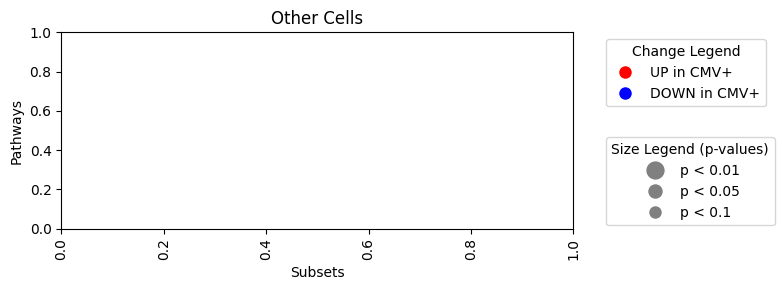

In [219]:
plot_ann_data(others_cell, 'AIFI_L3', 'CMV.IgG.Serology.Result.Interpretation', 'Negative', 'wilcoxon', 'Other Cells', fig_size=(8, 3))

### Monocyte

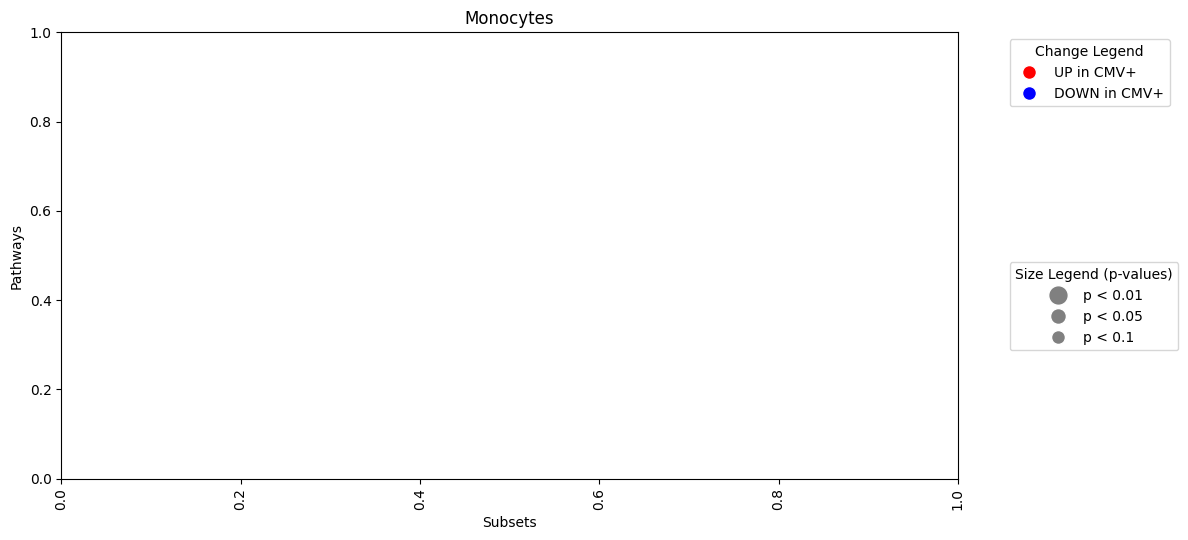

In [220]:
plot_ann_data(Monocyte, 'AIFI_L3', 'CMV.IgG.Serology.Result.Interpretation', 'Negative', 'wilcoxon', 'Monocytes', fig_size=(12, 5.5))

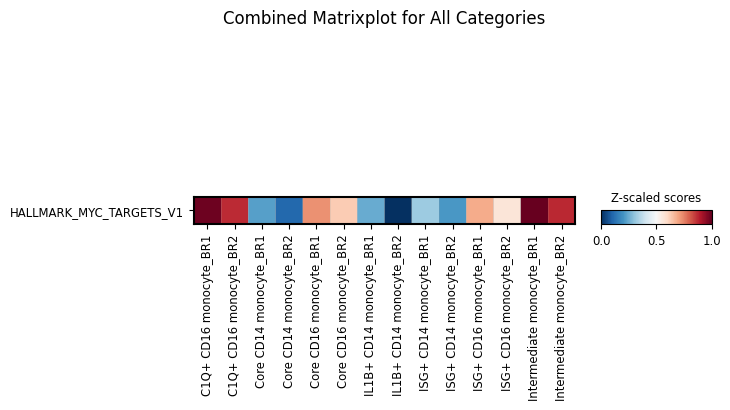

In [602]:
# Initialize a list to store all significant source markers across categories
all_significant_markers = []

# Loop over each unique category in 'AIFI_L3'
for category in Monocyte.obs['AIFI_L3'].unique():
    # Subset the Monocyte AnnData object for the current category
    AIFI_L3_subset = Monocyte[Monocyte.obs['AIFI_L3'] == category].copy()

    # Check if the subset is not empty
    if AIFI_L3_subset.n_obs > 0:
        # Run dc.rank_sources_groups for the subset
        df = dc.rank_sources_groups(AIFI_L3_subset, groupby='cohort.cohortGuid', reference='BR2', method='wilcoxon')
        
        # Filter for significant source markers
        significant_markers = df[df['pvals_adj'] < 0.05]['names'].tolist()
        
        # Add the significant markers to the cumulative list
        all_significant_markers.extend(significant_markers)
    else:
        print(f"No observations found for category {category}. Skipping.")

# Remove duplicates from the list
all_significant_markers = list(set(all_significant_markers))

# Plot one comprehensive matrixplot for all significant markers
sc.pl.matrixplot(Monocyte, all_significant_markers, groupby=['AIFI_L3', 'cohort.cohortGuid'], standard_scale='var', swap_axes=True,
                 colorbar_title='Z-scaled scores', cmap='RdBu_r', title="Combined Matrixplot for All Categories")

In [647]:
all_df_dataframes = []
all_significant_markers = []

# Loop over each unique category in 'AIFI_L3'
for category in Monocyte.obs['AIFI_L3'].unique():
    # Subset the Monocyte AnnData object for the current category
    AIFI_L3_subset = Monocyte[Monocyte.obs['AIFI_L3'] == category].copy()

    # Check if the subset is not empty
    if AIFI_L3_subset.n_obs > 0:
        # Run dc.rank_sources_groups for the subset
        df = dc.rank_sources_groups(AIFI_L3_subset, groupby='cohort.cohortGuid', reference='BR2', method='wilcoxon')
        
        # Add a new column to store the subset information
        df['subset'] = category
        
        # Append the dataframe to the list
        all_df_dataframes.append(df)
        
        # Filter for significant source markers
        significant_markers = df[df['pvals'] < 0.01]['names'].tolist()
        
        # Add the significant markers to the cumulative list
        all_significant_markers.extend(significant_markers)
        
    else:
        print(f"No observations found for category {category}. Skipping.")

# Remove duplicates from the list
all_significant_markers = list(set(all_significant_markers))
        
# Concatenate all "df" dataframes vertically into a single dataframe
combined_df = pd.concat(all_df_dataframes)

# Filter the combined_df to include only rows with 'names' in all_significant_markers
combined_df = combined_df[combined_df['names'].isin(all_significant_markers)]

In [648]:
combined_df

group reference                             names  statistic  meanchange  \
0    BR1       BR2         HALLMARK_MTORC1_SIGNALING   2.839216    0.002574   
1    BR1       BR2           HALLMARK_MYC_TARGETS_V1   2.714243    0.004573   
2    BR1       BR2      HALLMARK_ALLOGRAFT_REJECTION   2.612703    0.003217   
4    BR1       BR2  HALLMARK_IL6_JAK_STAT3_SIGNALING   2.440866    0.003382   
5    BR1       BR2           HALLMARK_UV_RESPONSE_UP   2.362759    0.003219   
10   BR1       BR2   HALLMARK_ESTROGEN_RESPONSE_LATE   1.925355    0.001391   
17   BR1       BR2           HALLMARK_MYC_TARGETS_V2   1.448898    0.002363   
26   BR1       BR2  HALLMARK_ESTROGEN_RESPONSE_EARLY   0.738118    0.000297   
0    BR1       BR2           HALLMARK_MYC_TARGETS_V2   2.971999    0.001090   
1    BR1       BR2           HALLMARK_MYC_TARGETS_V1   2.909513    0.004586   
3    BR1       BR2   HALLMARK_ESTROGEN_RESPONSE_LATE   2.347137    0.001141   
4    BR1       BR2      HALLMARK_ALLOGRAFT_REJECTION   2.284651    0.001773   
5    BR1       BR2           HALLMARK_UV_RESPONSE_UP   2.206543    0.003298   
7    BR1       BR2         HALLMARK_MTORC1_SIGNALING   1.925355    0.001803   
8    BR1       BR2  HALLMARK_IL6_JAK_STAT3_SIGNALING   1.839437    0.002308   
17   BR1       BR2  HALLMARK_ESTROGEN_RESPONSE_EARLY   1.323926    0.000402   
0    BR1       BR2           HALLMARK_MYC_TARGETS_V1   3.534374    0.004081   
1    BR1       BR2         HALLMARK_MTORC1_SIGNALING   2.839216    0.002228   
2    BR1       BR2      HALLMARK_ALLOGRAFT_REJECTION   2.518974    0.002123   
3    BR1       BR2           HALLMARK_UV_RESPONSE_UP   2.370569    0.003137   
11   BR1       BR2  HALLMARK_IL6_JAK_STAT3_SIGNALING   1.581681    0.001770   
13   BR1       BR2           HALLMARK_MYC_TARGETS_V2   1.534817    0.001121   
17   BR1       BR2  HALLMARK_ESTROGEN_RESPONSE_EARLY   1.370790    0.000585   
21   BR1       BR2   HALLMARK_ESTROGEN_RESPONSE_LATE   0.980252    0.000721   
0    BR1       BR2           HALLMARK_MYC_TARGETS_V1   3.323484    0.009709   
1    BR1       BR2           HALLMARK_MYC_TARGETS_V2   2.034706    0.002920   
3    BR1       BR2      HALLMARK_ALLOGRAFT_REJECTION   1.628546    0.005104   
5    BR1       BR2  HALLMARK_IL6_JAK_STAT3_SIGNALING   1.425466    0.004489   
7    BR1       BR2         HALLMARK_MTORC1_SIGNALING   1.027117    0.002820   
13   BR1       BR2           HALLMARK_UV_RESPONSE_UP   0.660010    0.002673   
32   BR1       BR2  HALLMARK_ESTROGEN_RESPONSE_EARLY  -0.449119    0.000503   
42   BR1       BR2   HALLMARK_ESTROGEN_RESPONSE_LATE  -1.245818    0.000284   
0    BR1       BR2           HALLMARK_UV_RESPONSE_UP   2.886080    0.003591   
1    BR1       BR2           HALLMARK_MYC_TARGETS_V1   2.792351    0.004208   
2    BR1       BR2   HALLMARK_ESTROGEN_RESPONSE_LATE   2.511163    0.001207   
3    BR1       BR2  HALLMARK_IL6_JAK_STAT3_SIGNALING   2.401812    0.002810   
6    BR1       BR2           HALLMARK_MYC_TARGETS_V2   2.065949    0.001097   
7    BR1       BR2         HALLMARK_MTORC1_SIGNALING   2.026895    0.001524   
17   BR1       BR2      HALLMARK_ALLOGRAFT_REJECTION   1.527006    0.001682   
18   BR1       BR2  HALLMARK_ESTROGEN_RESPONSE_EARLY   1.409844    0.000593   
0    BR1       BR2           HALLMARK_MYC_TARGETS_V1   3.909291    0.004855   
1    BR1       BR2      HALLMARK_ALLOGRAFT_REJECTION   2.932945    0.002670   
2    BR1       BR2   HALLMARK_ESTROGEN_RESPONSE_LATE   2.784540    0.001646   
3    BR1       BR2  HALLMARK_ESTROGEN_RESPONSE_EARLY   2.722054    0.001180   
4    BR1       BR2           HALLMARK_UV_RESPONSE_UP   2.636136    0.003830   
6    BR1       BR2  HALLMARK_IL6_JAK_STAT3_SIGNALING   2.144057    0.002549   
10   BR1       BR2         HALLMARK_MTORC1_SIGNALING   1.987841    0.001640   
13   BR1       BR2           HALLMARK_MYC_TARGETS_V2   1.691032    0.001118   
0    BR1       BR2           HALLMARK_MYC_TARGETS_V1   3.089160    0.004784   
1    BR1       BR2  HALLMARK_IL6_JAK_STAT3_SIGNALING 

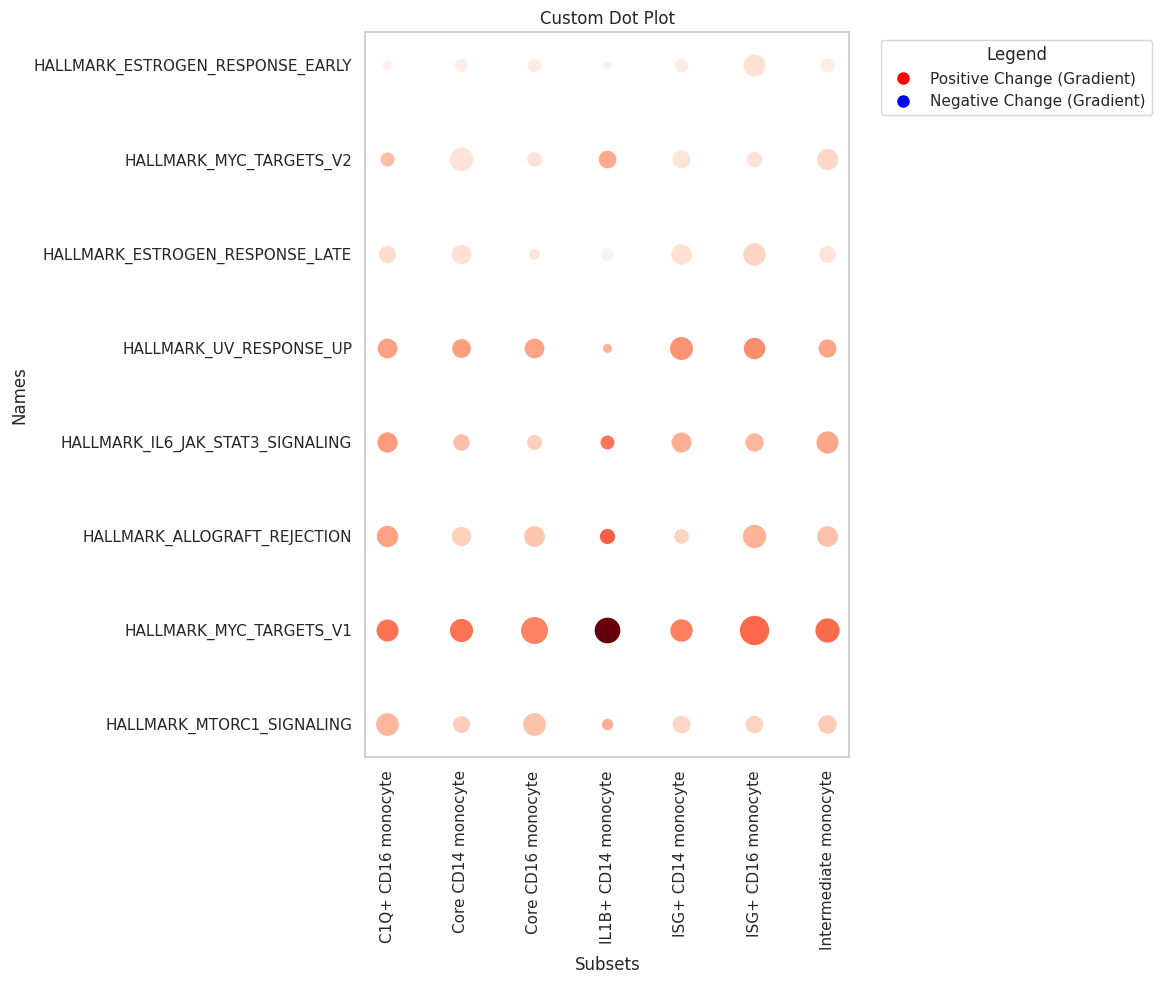

In [668]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib import cm

# Normalize 'pvals' for dot size
combined_df['dot_size'] = -np.log10(combined_df['pvals'])

# Define new gradient color mappings for positive and negative changes
def gradient_color_mapping(value, min_val, max_val, cmap_name):
    cmap = cm.get_cmap(cmap_name)
    norm_value = (value - min_val) / (max_val - min_val)
    return cmap(norm_value)

# Apply the new color mappings
min_change, max_change = combined_df['meanchange'].min(), combined_df['meanchange'].max()
combined_df['custom_color'] = combined_df['meanchange'].apply(
    lambda x: gradient_color_mapping(x, min_change, 0, 'Blues_r') if x < 0 else gradient_color_mapping(x, 0, max_change, 'Reds')
)

# Create the dot plot with custom gradient colors
plt.figure(figsize=(12, 10))  # Adjust figure size to accommodate legend
for _, row in combined_df.iterrows():
    plt.scatter(row['subset'], row['names'], s=row['dot_size']*100, color=row['custom_color'])

# Customize the axes and remove grid lines
plt.xlabel('Subsets')
plt.ylabel('Names')
plt.title('Custom Dot Plot')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.grid(False)  # Disable the grid

# Create custom legend labels for the color gradients
legend_labels = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Positive Change in BR1'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Negative Change in BR1')
]

# Add the legend to the plot
plt.legend(handles=legend_labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

### NK Cell

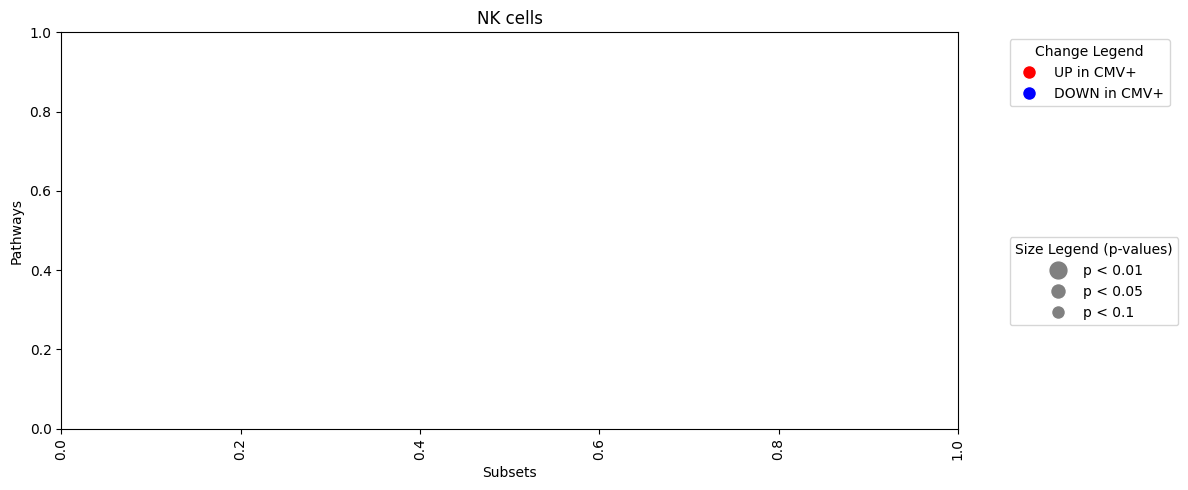

In [221]:
plot_ann_data(NK_cell, 'AIFI_L3', 'CMV.IgG.Serology.Result.Interpretation', 'Negative', 'wilcoxon', 'NK cells', fig_size=(12, 5))

In [222]:
# Initialize a list to store all significant source markers across categories
all_significant_markers = []

# Loop over each unique category in 'AIFI_L3'
for category in NK_cell.obs['AIFI_L3'].unique():
    # Subset the NK_cell AnnData object for the current category
    AIFI_L3_subset = NK_cell[NK_cell.obs['AIFI_L3'] == category].copy()

    # Check if the subset is not empty
    if AIFI_L3_subset.n_obs > 0:
        # Run dc.rank_sources_groups for the subset
        df = dc.rank_sources_groups(AIFI_L3_subset, groupby='cohort.cohortGuid', reference='BR2', method='wilcoxon')
        
        # Filter for significant source markers
        significant_markers = df[df['pvals'] < 0.01]['names'].tolist()
        
        # Add the significant markers to the cumulative list
        all_significant_markers.extend(significant_markers)
    else:
        print(f"No observations found for category {category}. Skipping.")

# Remove duplicates from the list
all_significant_markers = list(set(all_significant_markers))

# Plot one comprehensive matrixplot for all significant markers
sc.pl.matrixplot(NK_cell, all_significant_markers, groupby=['AIFI_L3', 'cohort.cohortGuid'], standard_scale='var', swap_axes=True,
                 colorbar_title='Z-scaled scores', cmap='RdBu_r', title="Combined Matrixplot for All Categories")

ValueError: No objects to concatenate

### DC

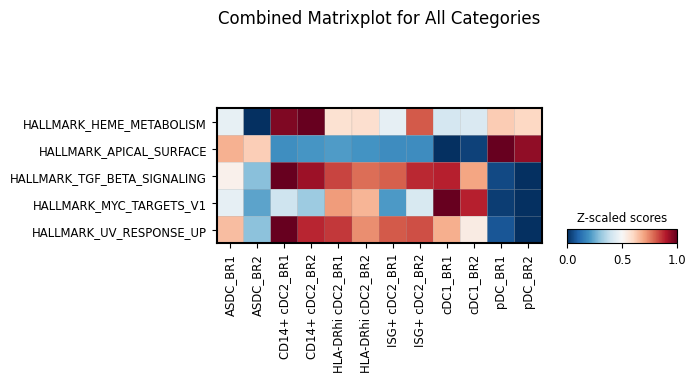

In [569]:
# Initialize a list to store all significant source markers across categories
all_significant_markers = []

# Loop over each unique category in 'AIFI_L3'
for category in DC.obs['AIFI_L3'].unique():
    # Subset the NK_cell AnnData object for the current category
    AIFI_L3_subset = DC[DC.obs['AIFI_L3'] == category].copy()

    # Check if the subset is not empty
    if AIFI_L3_subset.n_obs > 0:
        # Run dc.rank_sources_groups for the subset
        df = dc.rank_sources_groups(AIFI_L3_subset, groupby='cohort.cohortGuid', reference='BR2', method='wilcoxon')
        
        # Filter for significant source markers
        significant_markers = df[df['pvals'] < 0.01]['names'].tolist()
        
        # Add the significant markers to the cumulative list
        all_significant_markers.extend(significant_markers)
    else:
        print(f"No observations found for category {category}. Skipping.")

# Remove duplicates from the list
all_significant_markers = list(set(all_significant_markers))

# Plot one comprehensive matrixplot for all significant markers
sc.pl.matrixplot(DC, all_significant_markers, groupby=['AIFI_L3', 'cohort.cohortGuid'], standard_scale='var', swap_axes=True,
                 colorbar_title='Z-scaled scores', cmap='RdBu_r', title="Combined Matrixplot for All Categories")

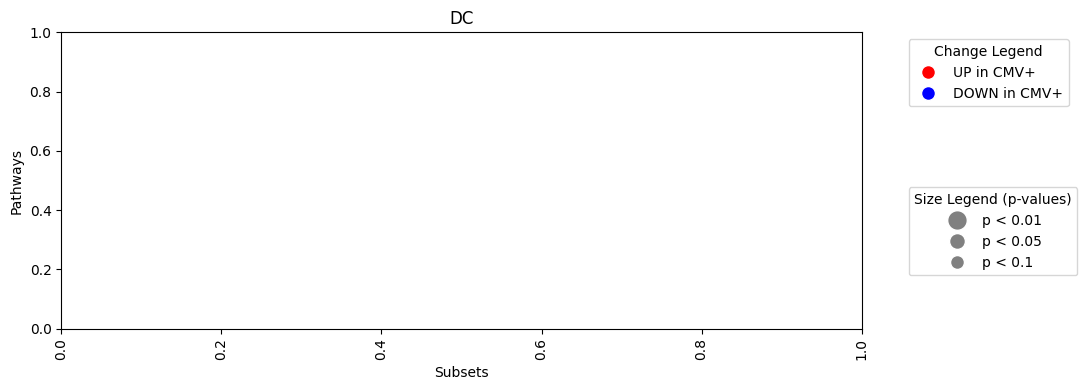

In [223]:
plot_ann_data(DC, 'AIFI_L3', 'CMV.IgG.Serology.Result.Interpretation', 'Negative', 'wilcoxon', 'DC', fig_size=(11, 4))

### B cell

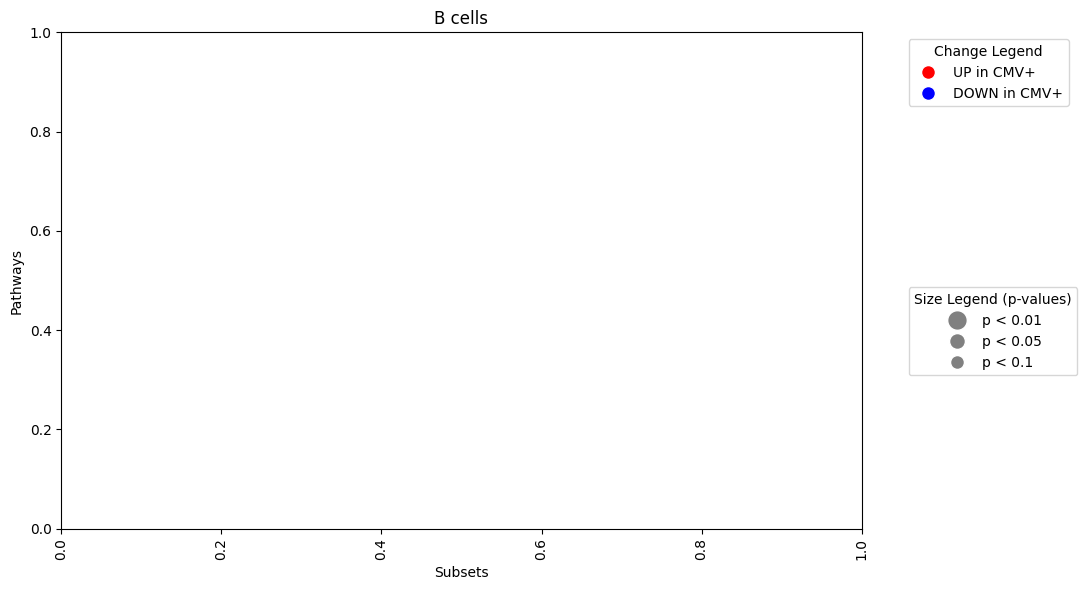

In [224]:
plot_ann_data(B_cell, 'AIFI_L3', 'CMV.IgG.Serology.Result.Interpretation', 'Negative', 'wilcoxon', 'B cells', fig_size=(11, 6))

#### Only Plasma cells

In [84]:
Plasma_cell = adata2[adata2.obs['AIFI_L3'].isin(['Plasma cell'])]

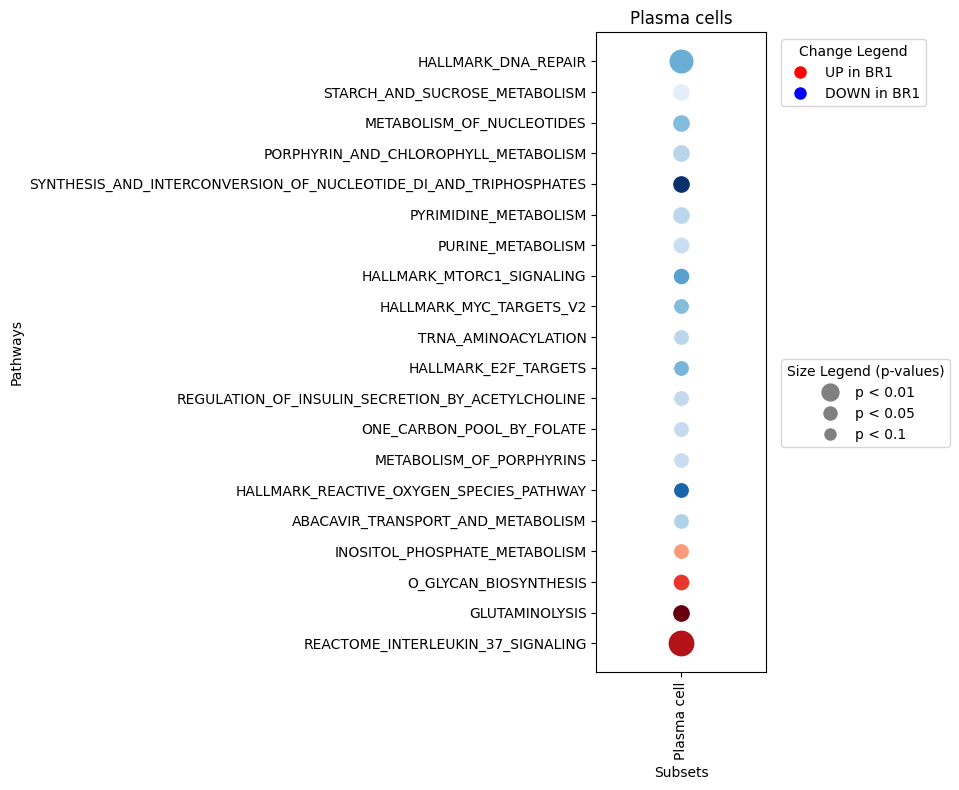

In [78]:
plot_ann_data(Plasma_cell, 'AIFI_L3', 'cohort.cohortGuid', 'BR2', 'wilcoxon', 'Plasma cells', fig_size=(10, 8))

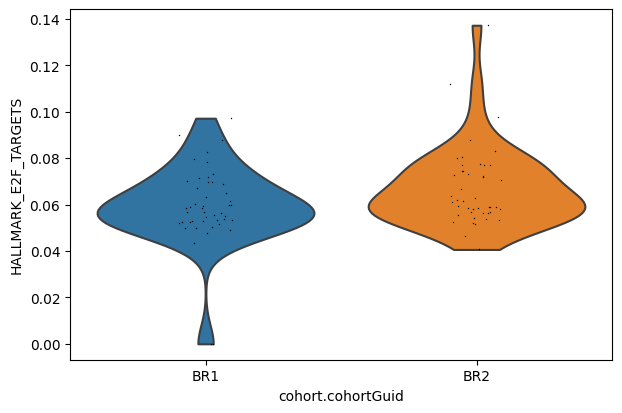

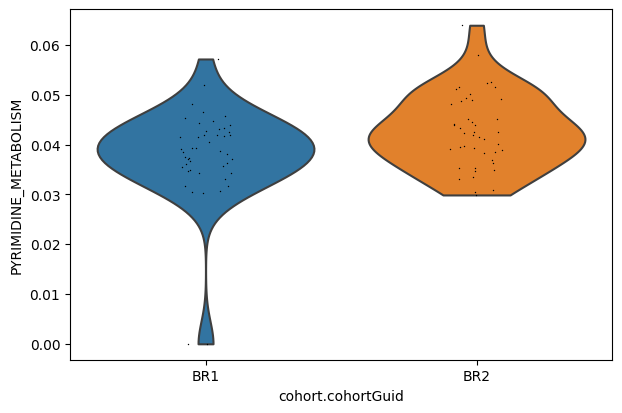

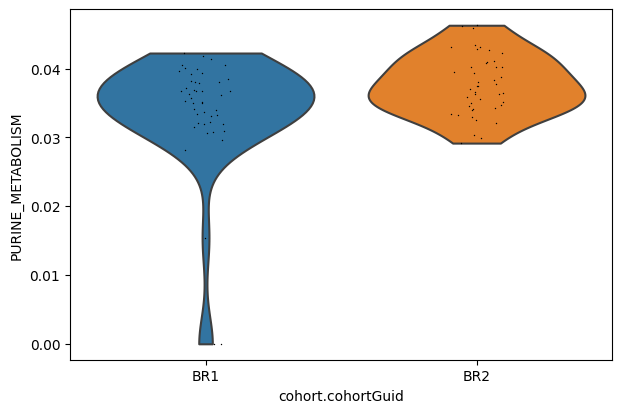

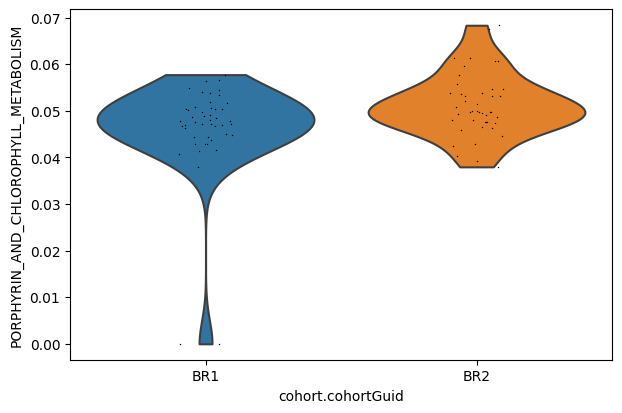

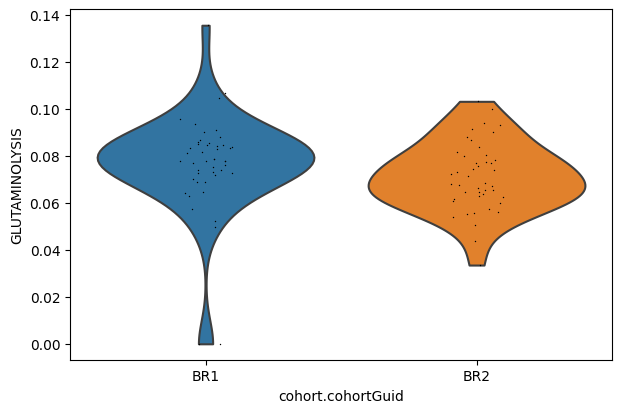

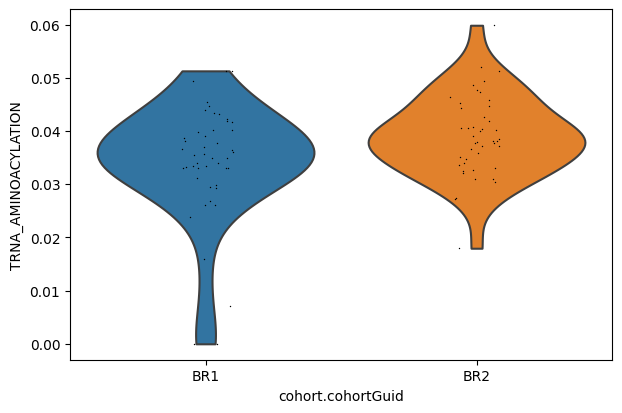

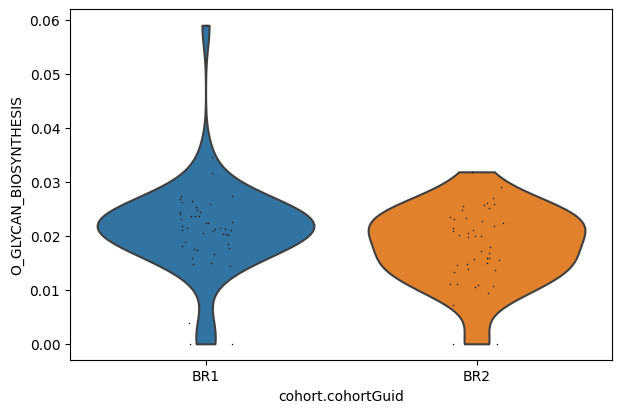

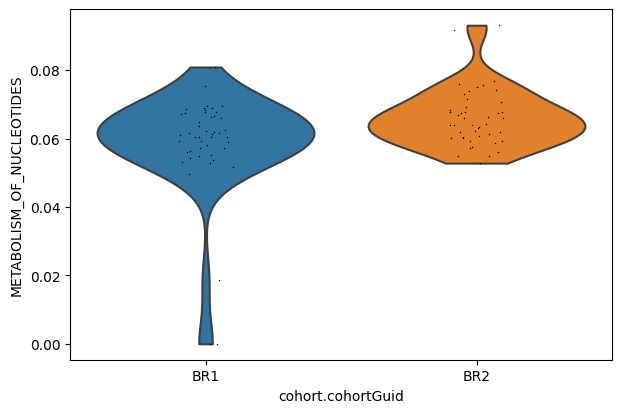

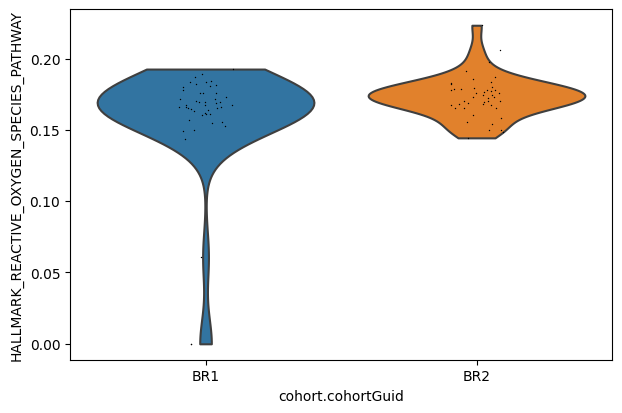

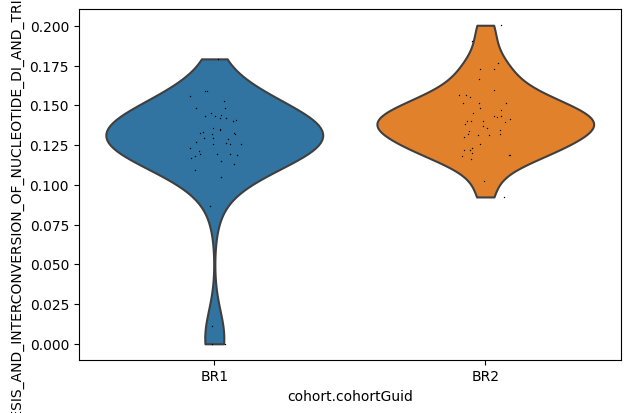

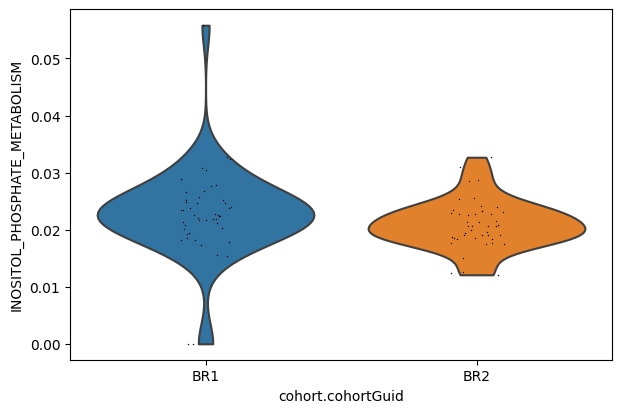

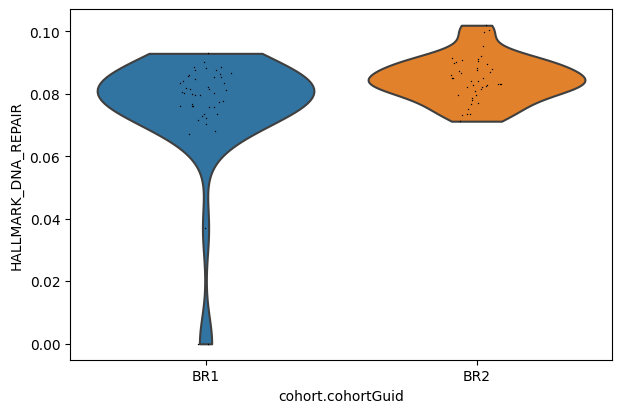

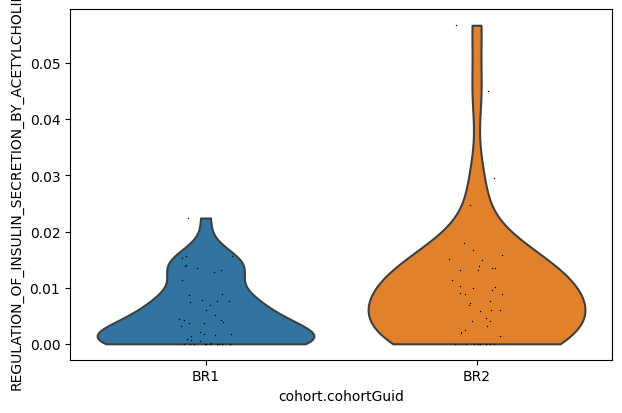

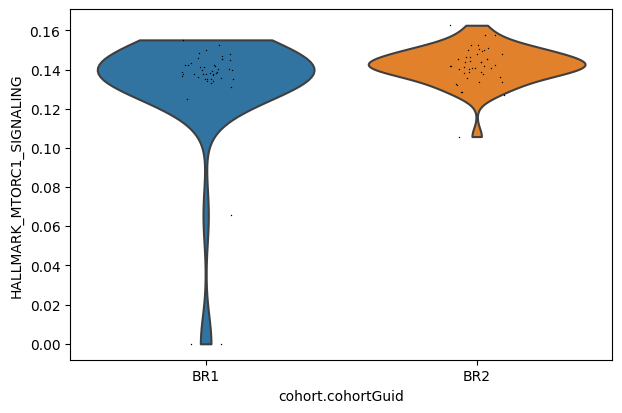

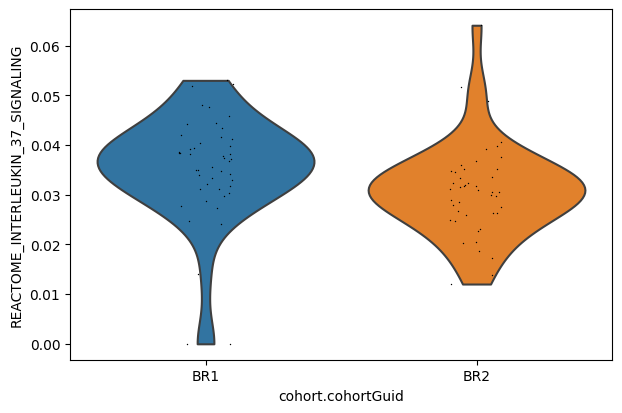

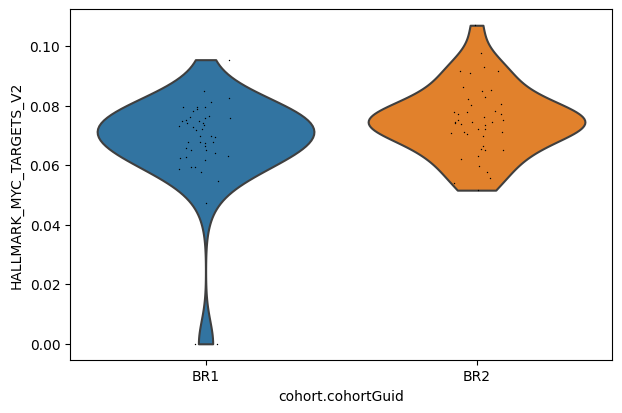

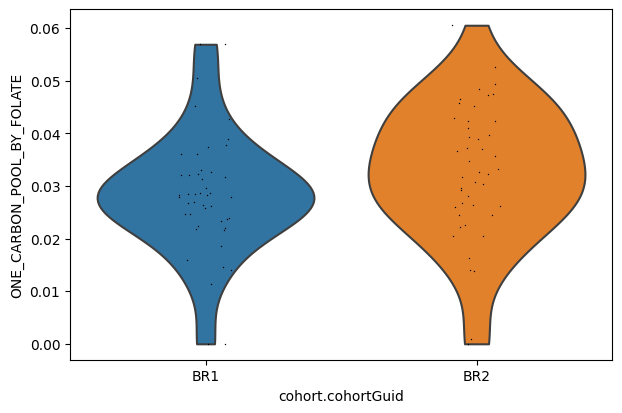

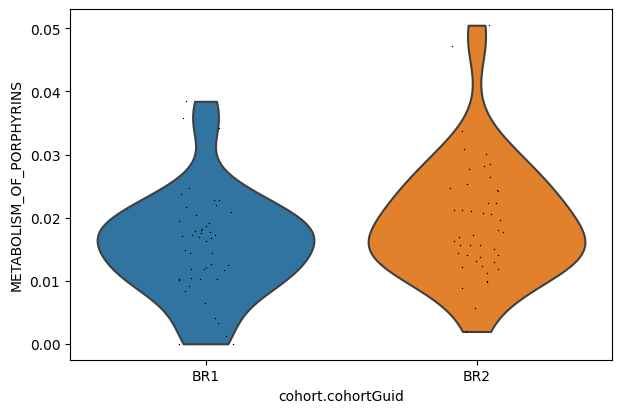

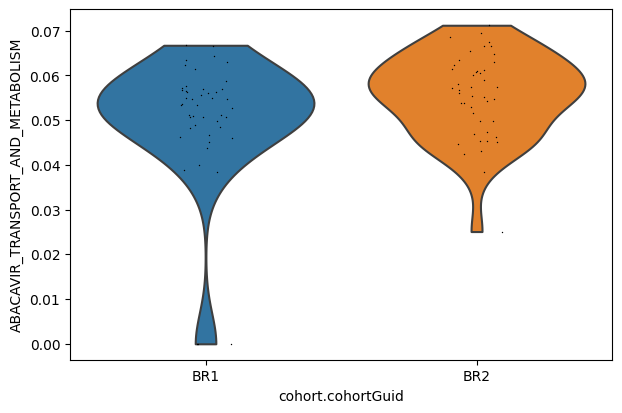

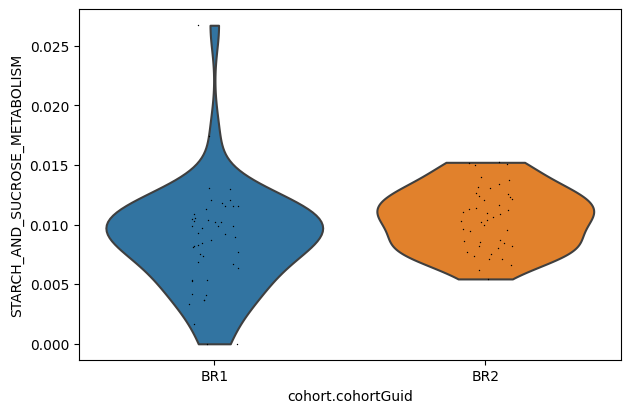

In [85]:
# Loop through each source marker and create a violin plot
source_markers = sig_pathways(Plasma_cell, 'AIFI_L3', 'cohort.cohortGuid', 'BR2', 'wilcoxon')
for marker in source_markers:
    sc.pl.violin(Plasma_cell, keys=marker, groupby='cohort.cohortGuid')

In [572]:
unique = adata2.obs['AIFI_L2'].unique()
print(unique)

['ASDC' 'Memory B cell' 'CD56dim NK cell' 'Progenitor cell'
 'CD16 monocyte' 'MAIT' 'CD8aa' 'cDC2' 'Effector B cell'
 'CD56bright NK cell' 'Memory CD4 T cell' 'Memory CD8 T cell'
 'CD14 monocyte' 'Naive B cell' 'Naive CD4 T cell' 'Naive CD8 T cell'
 'DN T cell' 'Erythrocyte' 'gdT' 'Treg' 'ILC' 'Intermediate monocyte'
 'Plasma cell' 'Platelet' 'Proliferating NK cell' 'Proliferating T cell'
 'Transitional B cell' 'cDC1' 'pDC']


# T cell

In [57]:
T_cell = adata2[adata2.obs['AIFI_L1'].isin(['T cell'])]

KeyboardInterrupt: 

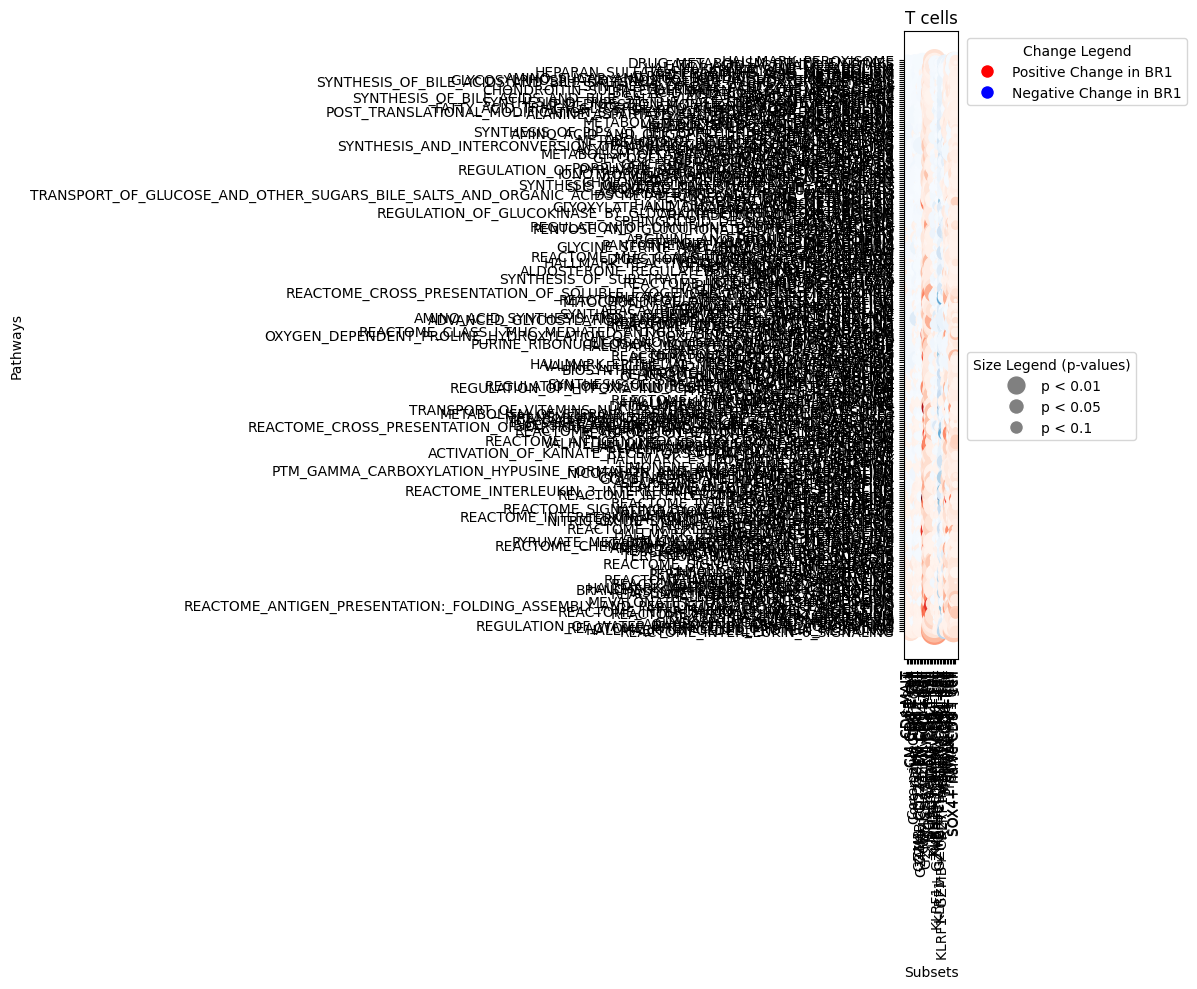

In [58]:
plot_ann_data(T_cell, 'AIFI_L3', 'cohort.cohortGuid', 'BR2', 'wilcoxon', 'T cells', fig_size=(12, 10))

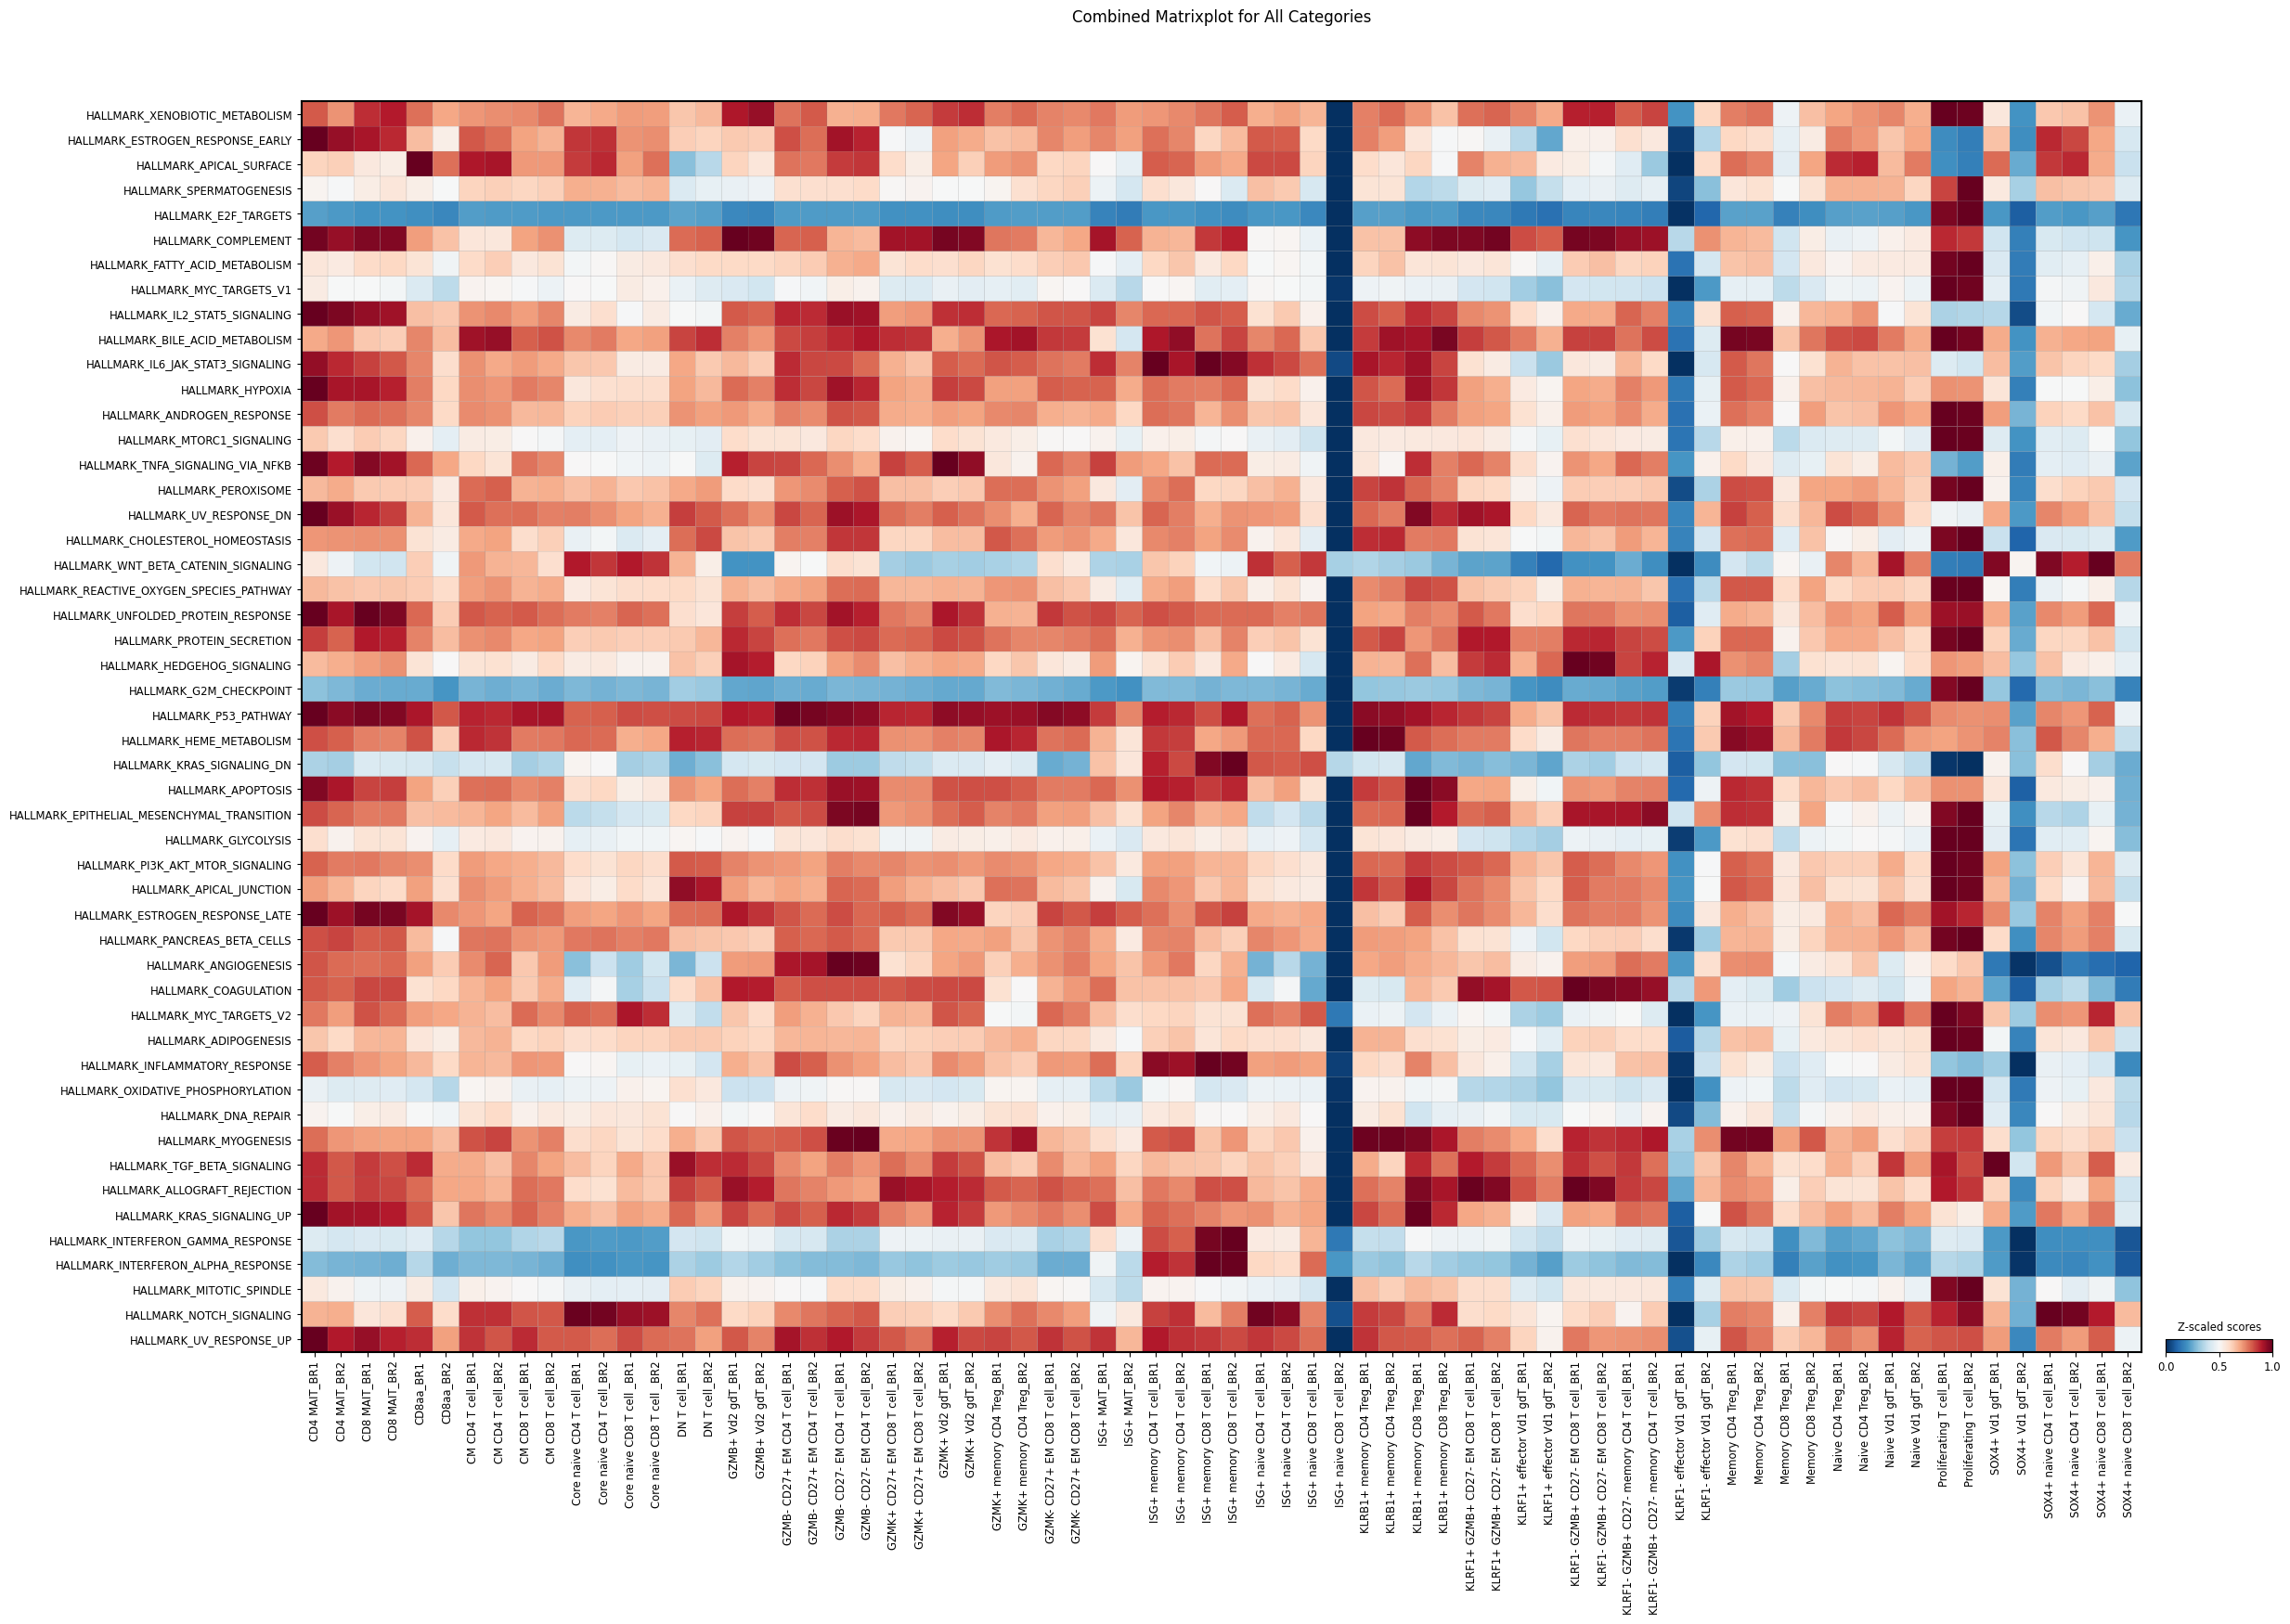

In [589]:
# Initialize a list to store all significant source markers across categories
all_significant_markers = []

# Loop over each unique category in 'AIFI_L3'
for category in T_cell.obs['AIFI_L3'].unique():
    # Subset the NK_cell AnnData object for the current category
    AIFI_L3_subset = T_cell[T_cell.obs['AIFI_L3'] == category].copy()

    # Check if the subset is not empty
    if AIFI_L3_subset.n_obs > 0:
        # Run dc.rank_sources_groups for the subset
        df = dc.rank_sources_groups(AIFI_L3_subset, groupby='cohort.cohortGuid', reference='BR2', method='wilcoxon')
        
        # Filter for significant source markers
        significant_markers = df[df['pvals'] < 0.01]['names'].tolist()
        
        # Add the significant markers to the cumulative list
        all_significant_markers.extend(significant_markers)
    else:
        print(f"No observations found for category {category}. Skipping.")

# Remove duplicates from the list
all_significant_markers = list(set(all_significant_markers))

# Plot one comprehensive matrixplot for all significant markers
sc.pl.matrixplot(T_cell, all_significant_markers, groupby=['AIFI_L3', 'cohort.cohortGuid'], standard_scale='var', swap_axes=True,
                 colorbar_title='Z-scaled scores', cmap='RdBu_r', title="Combined Matrixplot for All Categories")

### Naive CD4

In [225]:
Naive_CD4 = adata2[adata2.obs['AIFI_L2'].isin(['Naive CD4 T cell'])]

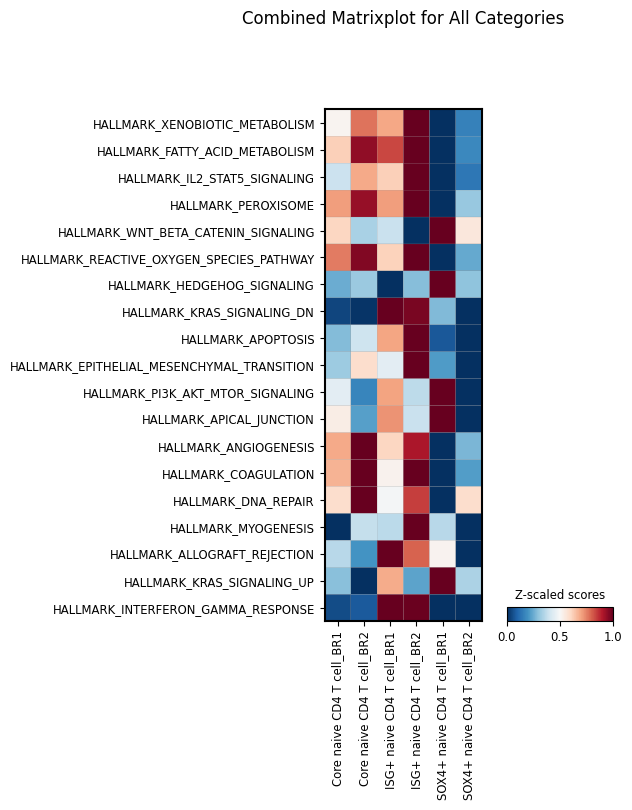

In [581]:
# Initialize a list to store all significant source markers across categories
all_significant_markers = []

# Loop over each unique category in 'AIFI_L3'
for category in Naive_CD4.obs['AIFI_L3'].unique():
    # Subset the NK_cell AnnData object for the current category
    AIFI_L3_subset = Naive_CD4[Naive_CD4.obs['AIFI_L3'] == category].copy()

    # Check if the subset is not empty
    if AIFI_L3_subset.n_obs > 0:
        # Run dc.rank_sources_groups for the subset
        df = dc.rank_sources_groups(AIFI_L3_subset, groupby='cohort.cohortGuid', reference='BR2', method='wilcoxon')
        
        # Filter for significant source markers
        significant_markers = df[df['pvals'] < 0.01]['names'].tolist()
        
        # Add the significant markers to the cumulative list
        all_significant_markers.extend(significant_markers)
    else:
        print(f"No observations found for category {category}. Skipping.")

# Remove duplicates from the list
all_significant_markers = list(set(all_significant_markers))

# Plot one comprehensive matrixplot for all significant markers
sc.pl.matrixplot(Naive_CD4, all_significant_markers, groupby=['AIFI_L3', 'cohort.cohortGuid'], standard_scale='var', swap_axes=True,
                 colorbar_title='Z-scaled scores', cmap='RdBu_r', title="Combined Matrixplot for All Categories")

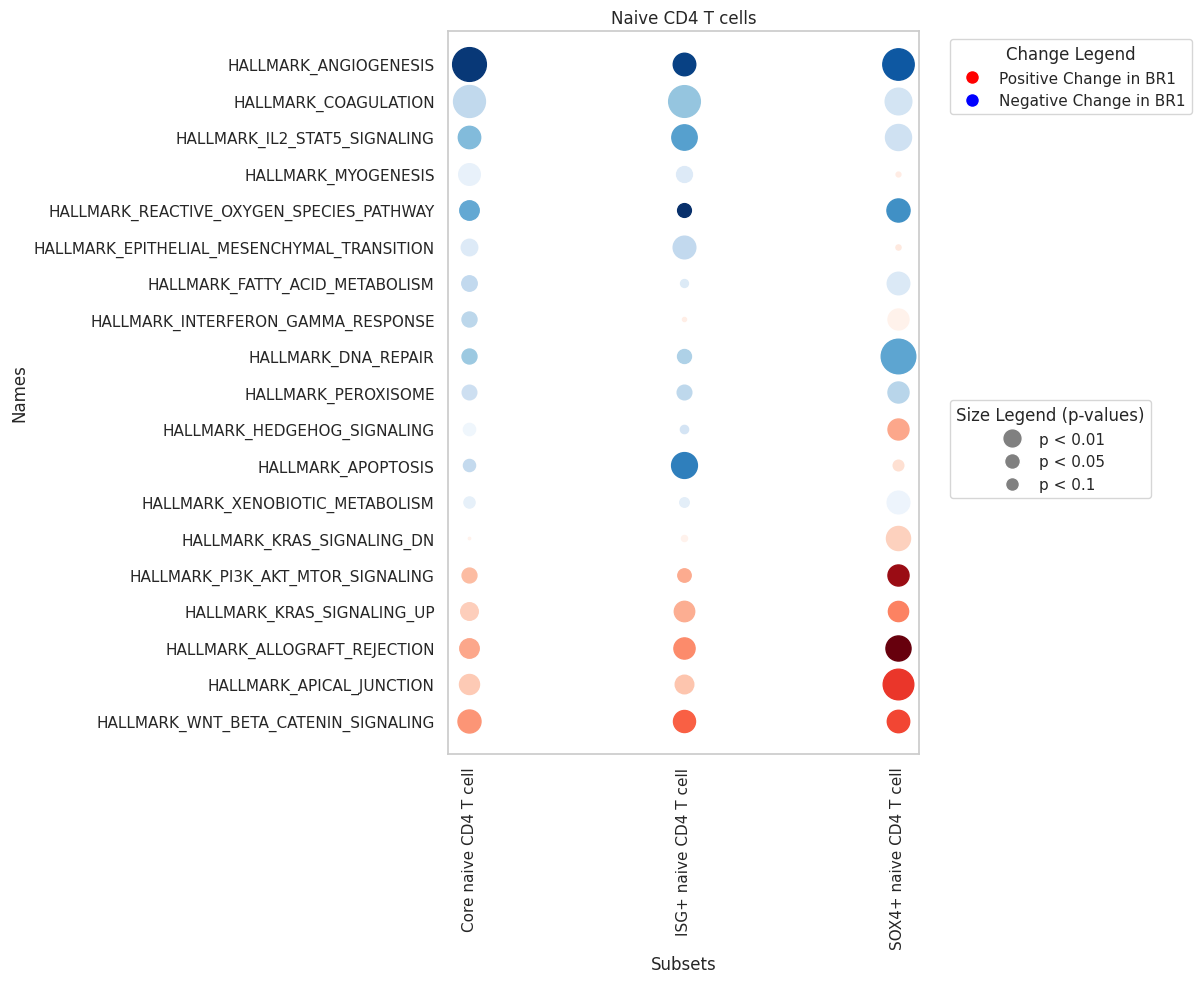

In [682]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib import cm

all_df_dataframes = []
all_significant_markers = []

# Loop over each unique category in 'AIFI_L3'
for category in Naive_CD4.obs['AIFI_L3'].unique():
    # Subset the AnnData object for the current category
    AIFI_L3_subset = Naive_CD4[Naive_CD4.obs['AIFI_L3'] == category].copy()

    # Check if the subset is not empty
    if AIFI_L3_subset.n_obs > 0:
        # Run dc.rank_sources_groups for the subset
        df = dc.rank_sources_groups(AIFI_L3_subset, groupby='cohort.cohortGuid', reference='BR2', method='wilcoxon')
        
        # Add a new column to store the subset information
        df['subset'] = category
        
        # Append the dataframe to the list
        all_df_dataframes.append(df)
        
        # Filter for significant source markers
        significant_markers = df[df['pvals'] < 0.01]['names'].tolist()
        
        # Add the significant markers to the cumulative list
        all_significant_markers.extend(significant_markers)
        
    else:
        print(f"No observations found for category {category}. Skipping.")

# Remove duplicates from the list
all_significant_markers = list(set(all_significant_markers))
        
# Concatenate all "df" dataframes vertically into a single dataframe
combined_df = pd.concat(all_df_dataframes)

# Filter the combined_df to include only rows with 'names' in all_significant_markers
combined_df = combined_df[combined_df['names'].isin(all_significant_markers)]

# Normalize 'pvals' for dot size
combined_df['dot_size'] = -np.log10(combined_df['pvals'])

# Define new gradient color mappings for positive and negative changes
def gradient_color_mapping(value, min_val, max_val, cmap_name):
    cmap = cm.get_cmap(cmap_name)
    norm_value = (value - min_val) / (max_val - min_val)
    return cmap(norm_value)

# Apply the new color mappings
min_change, max_change = combined_df['meanchange'].min(), combined_df['meanchange'].max()
combined_df['custom_color'] = combined_df['meanchange'].apply(
    lambda x: gradient_color_mapping(x, min_change, 0, 'Blues_r') if x < 0 else gradient_color_mapping(x, 0, max_change, 'Reds')
)

# Create the dot plot with custom gradient colors
plt.figure(figsize=(12, 10))
for _, row in combined_df.iterrows():
    plt.scatter(row['subset'], row['names'], s=row['dot_size']*100, color=row['custom_color'])

# Customize the axes and remove grid lines
plt.xlabel('Subsets')
plt.ylabel('Names')
plt.title('Naive CD4 T cells')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.grid(False)  # Disable the grid

# Create custom legend labels for color gradients
color_legend_labels = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Positive Change in BR1'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Negative Change in BR1')
]

# Create custom legend labels for dot sizes
size_legend_labels = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=np.sqrt(-np.log10(0.01))*10, label='p < 0.01'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=np.sqrt(-np.log10(0.05))*10, label='p < 0.05'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=np.sqrt(-np.log10(0.1))*10, label='p < 0.1')
]

# Add the first legend to the plot and get the current axes
first_legend = plt.legend(handles=color_legend_labels, title='Change Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.gca()
ax.add_artist(first_legend)

# Add the second legend to the plot
plt.legend(handles=size_legend_labels, title='Size Legend (p-values)', bbox_to_anchor=(1.05, 0.5), loc='upper left')

# Adjust layout to make room for the legends
plt.tight_layout()

# Show the plot
plt.show()

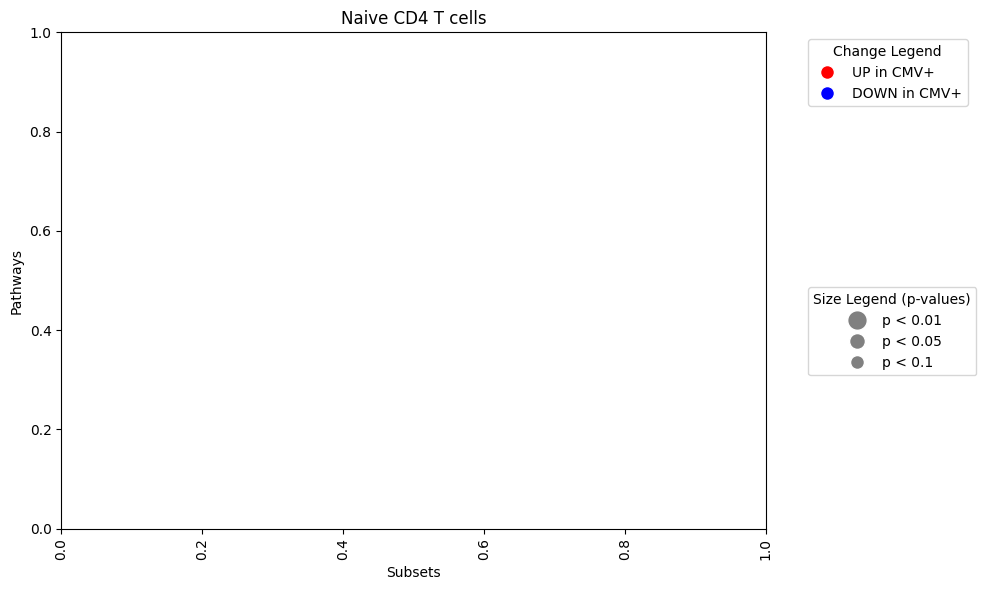

In [226]:
plot_ann_data(Naive_CD4, 'AIFI_L3', 'CMV.IgG.Serology.Result.Interpretation', 'Negative', 'wilcoxon', 'Naive CD4 T cells', fig_size=(10, 6))

### Memory CD4

In [227]:
Mem_CD4 = adata2[adata2.obs['AIFI_L2'].isin(['Memory CD4 T cell'])]

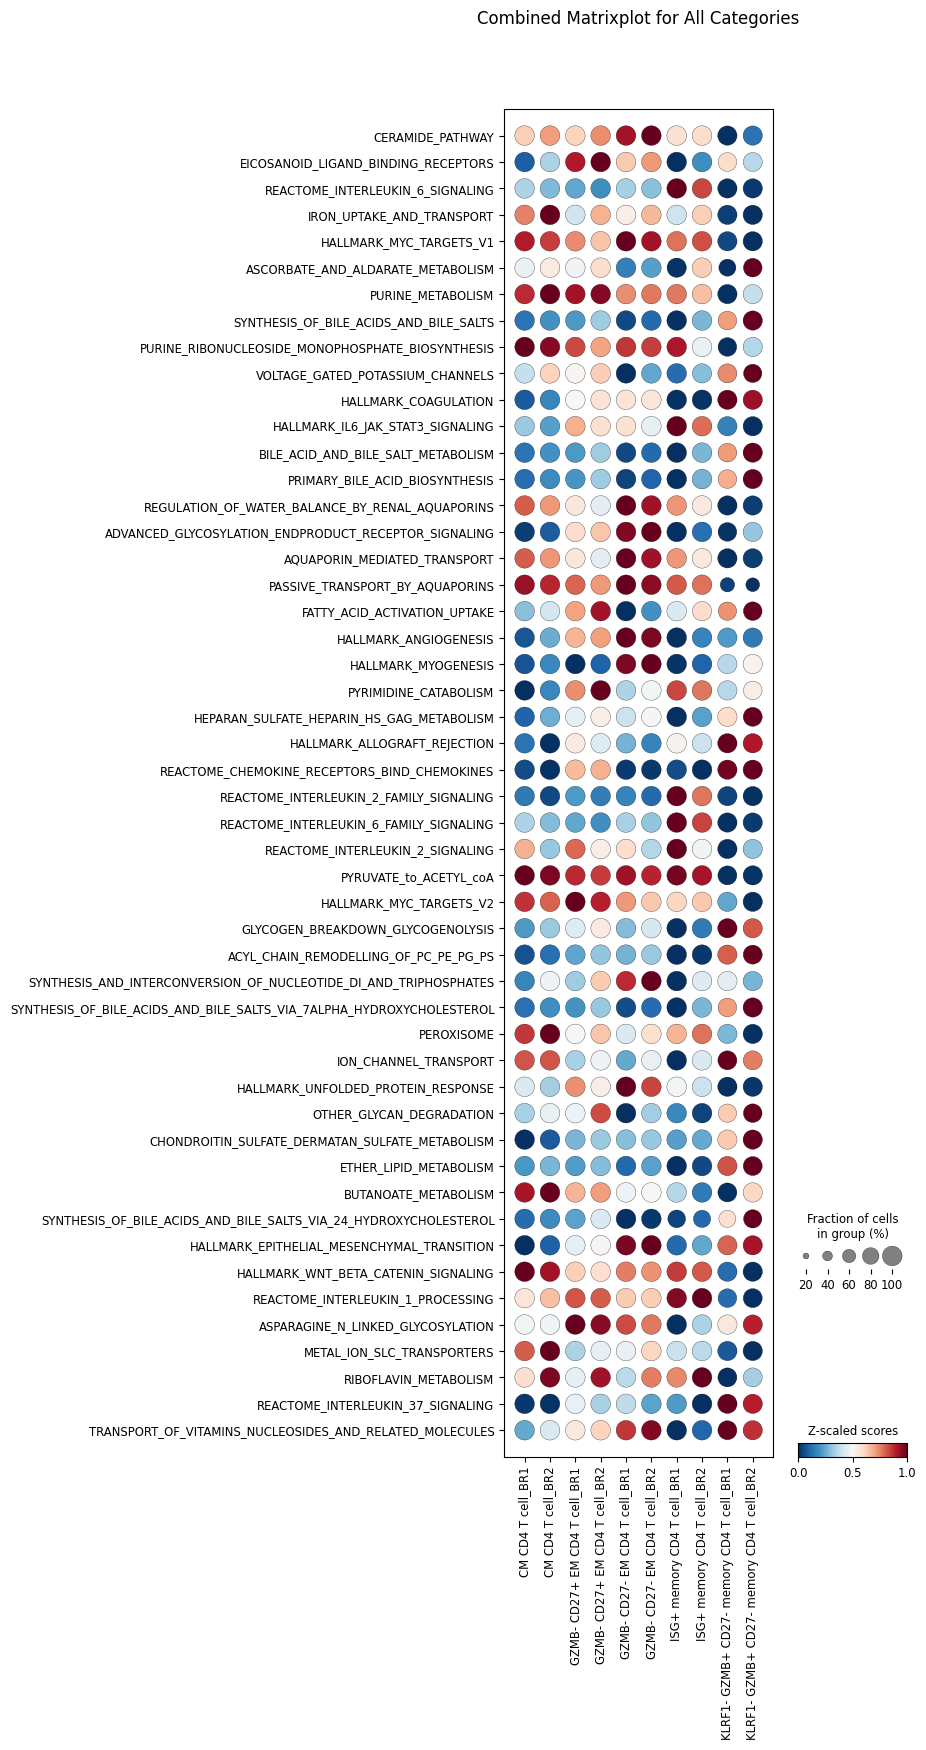

In [63]:
# Initialize a list to store all significant source markers across categories
all_significant_markers = []

# Loop over each unique category in 'AIFI_L3'
for category in Mem_CD4.obs['AIFI_L3'].unique():
    # Subset the NK_cell AnnData object for the current category
    AIFI_L3_subset = Mem_CD4[Mem_CD4.obs['AIFI_L3'] == category].copy()

    # Check if the subset is not empty
    if AIFI_L3_subset.n_obs > 0:
        # Run dc.rank_sources_groups for the subset
        df = dc.rank_sources_groups(AIFI_L3_subset, groupby='cohort.cohortGuid', reference='BR2', method='wilcoxon')
        
        # Filter for significant source markers
        significant_markers = df[df['pvals'] < 0.01]['names'].tolist()
        
        # Add the significant markers to the cumulative list
        all_significant_markers.extend(significant_markers)
    else:
        print(f"No observations found for category {category}. Skipping.")

# Remove duplicates from the list
all_significant_markers = list(set(all_significant_markers))

# Plot one comprehensive matrixplot for all significant markers
sc.pl.dotplot(Mem_CD4, all_significant_markers, groupby=['AIFI_L3', 'cohort.cohortGuid'], standard_scale='var', swap_axes=True,
                 colorbar_title='Z-scaled scores', cmap='RdBu_r', title="Combined Matrixplot for All Categories")

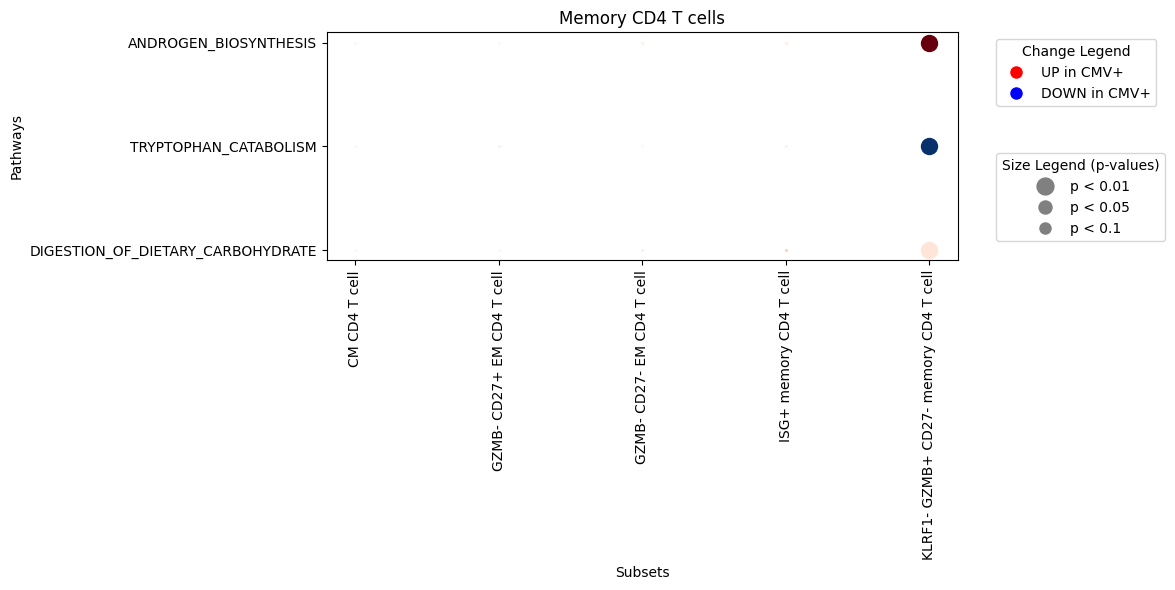

In [229]:
plot_ann_data(Mem_CD4, 'AIFI_L3', 'CMV.IgG.Serology.Result.Interpretation', 'Negative', 'wilcoxon', 'Memory CD4 T cells', fig_size=(12, 6))

### Naive + Mem CD4

In [65]:
Naive_mem_CD4 = adata2[adata2.obs['AIFI_L2'].isin(['Memory CD4 T cell', 'Naive CD4 T cell', 'CD56dim NK cell', 'CD56bright NK cell', 'Proliferating NK cell'])]

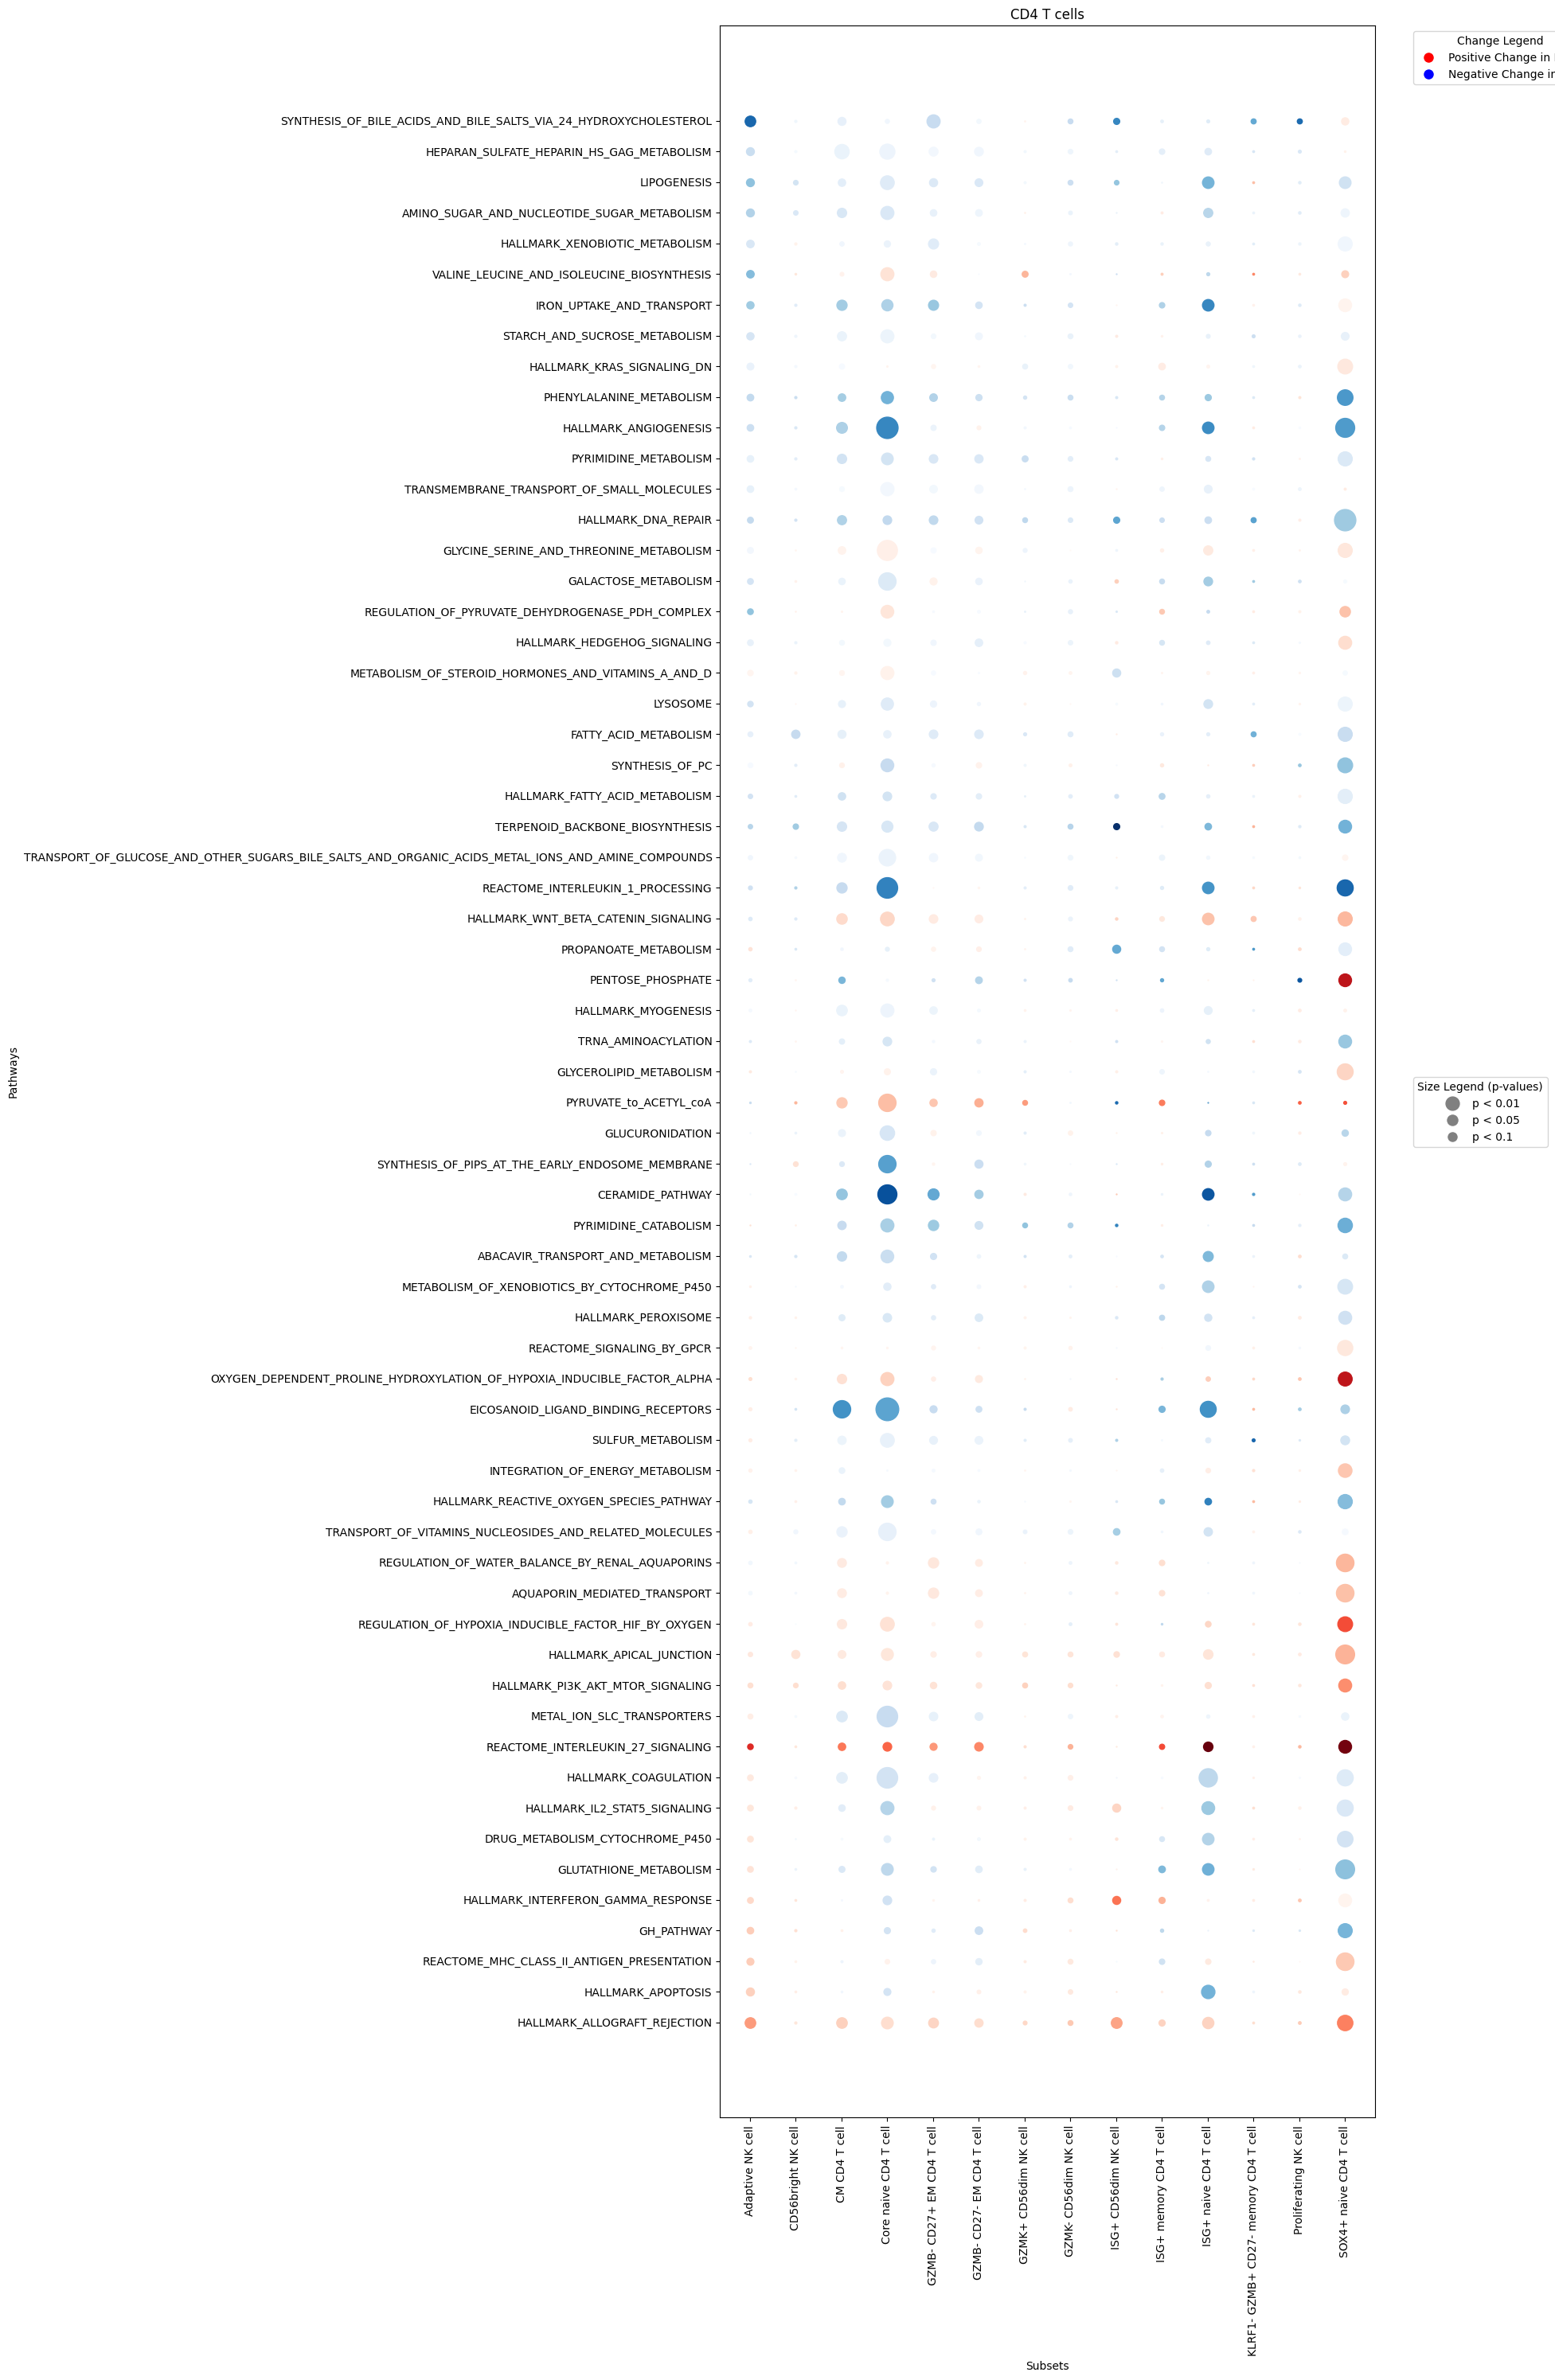

In [68]:
plot_ann_data(Naive_mem_CD4, 'AIFI_L3', 'cohort.cohortGuid', 'BR2', 'wilcoxon', 'CD4 T cells', fig_size=(20, 30))

### Naive CD8

In [230]:
Naive_CD8 = adata2[adata2.obs['AIFI_L2'].isin(['Naive CD8 T cell'])]

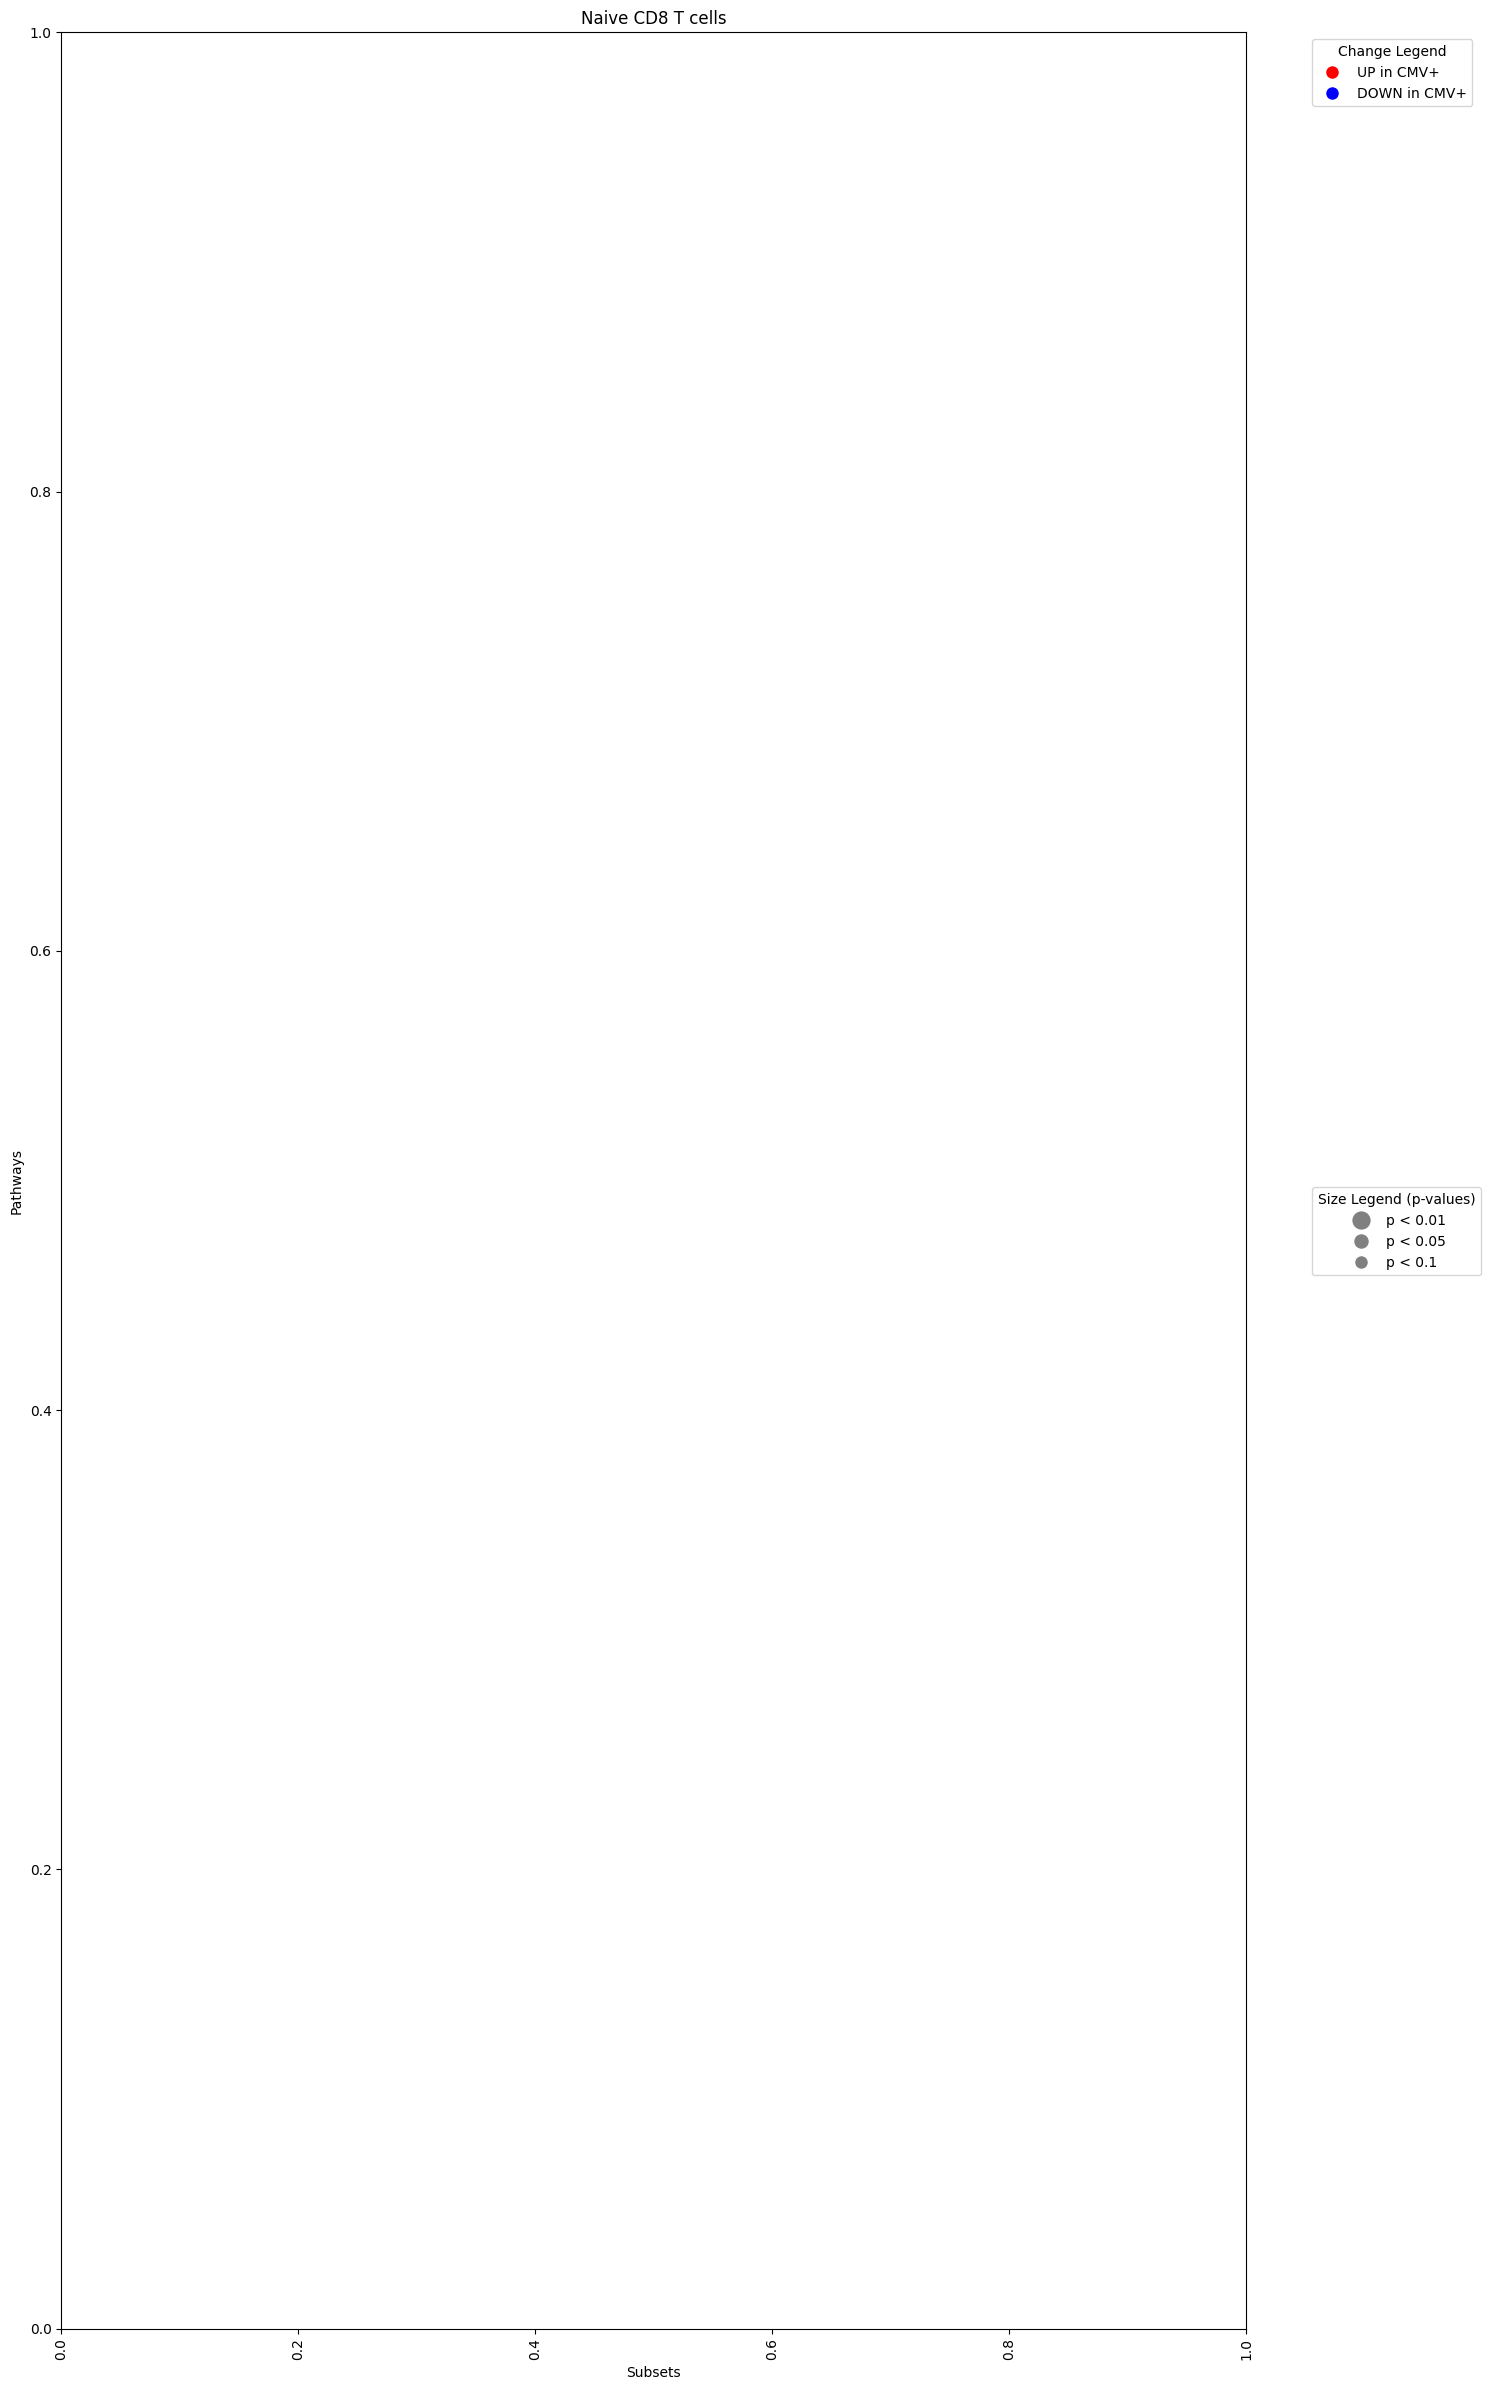

In [231]:
plot_ann_data(Naive_CD8, 'AIFI_L3', 'CMV.IgG.Serology.Result.Interpretation', 'Negative', 'wilcoxon', 'Naive CD8 T cells', fig_size=(15, 24))

### Memory CD8

In [232]:
Mem_CD8 = adata2[adata2.obs['AIFI_L2'].isin(['Memory CD8 T cell'])]

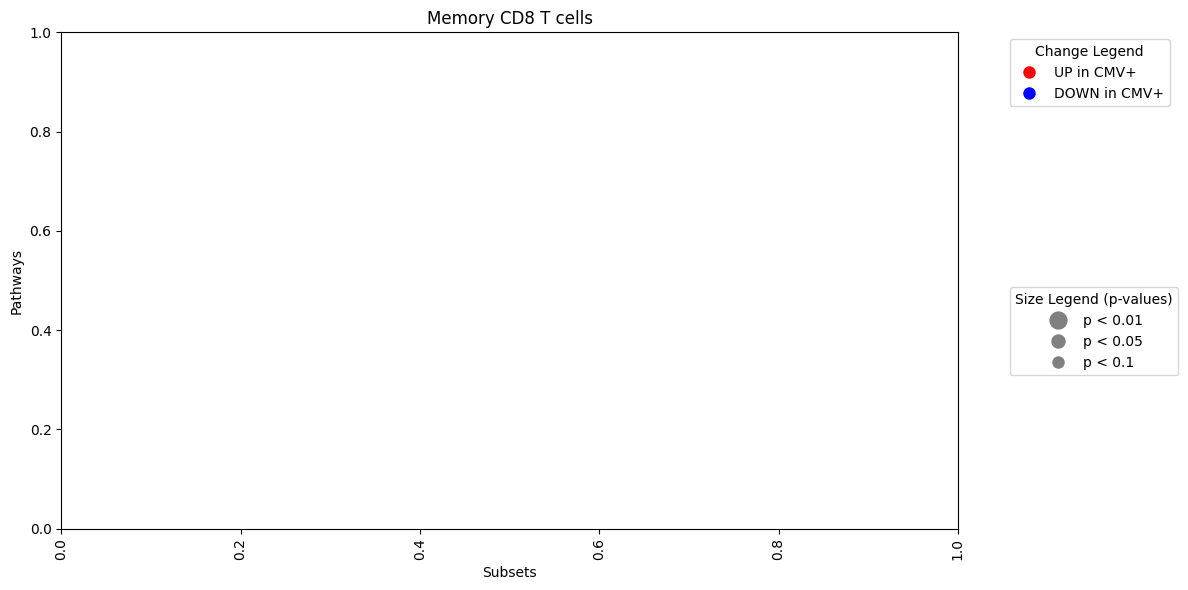

In [233]:
plot_ann_data(Mem_CD8, 'AIFI_L3', 'CMV.IgG.Serology.Result.Interpretation', 'Negative', 'wilcoxon', 'Memory CD8 T cells', fig_size=(12, 6))

### Naive + Memory CD8

In [73]:
Naive_mem_CD8 = adata2[adata2.obs['AIFI_L2'].isin(['Memory CD8 T cell', 'Naive CD8 T cell'])]

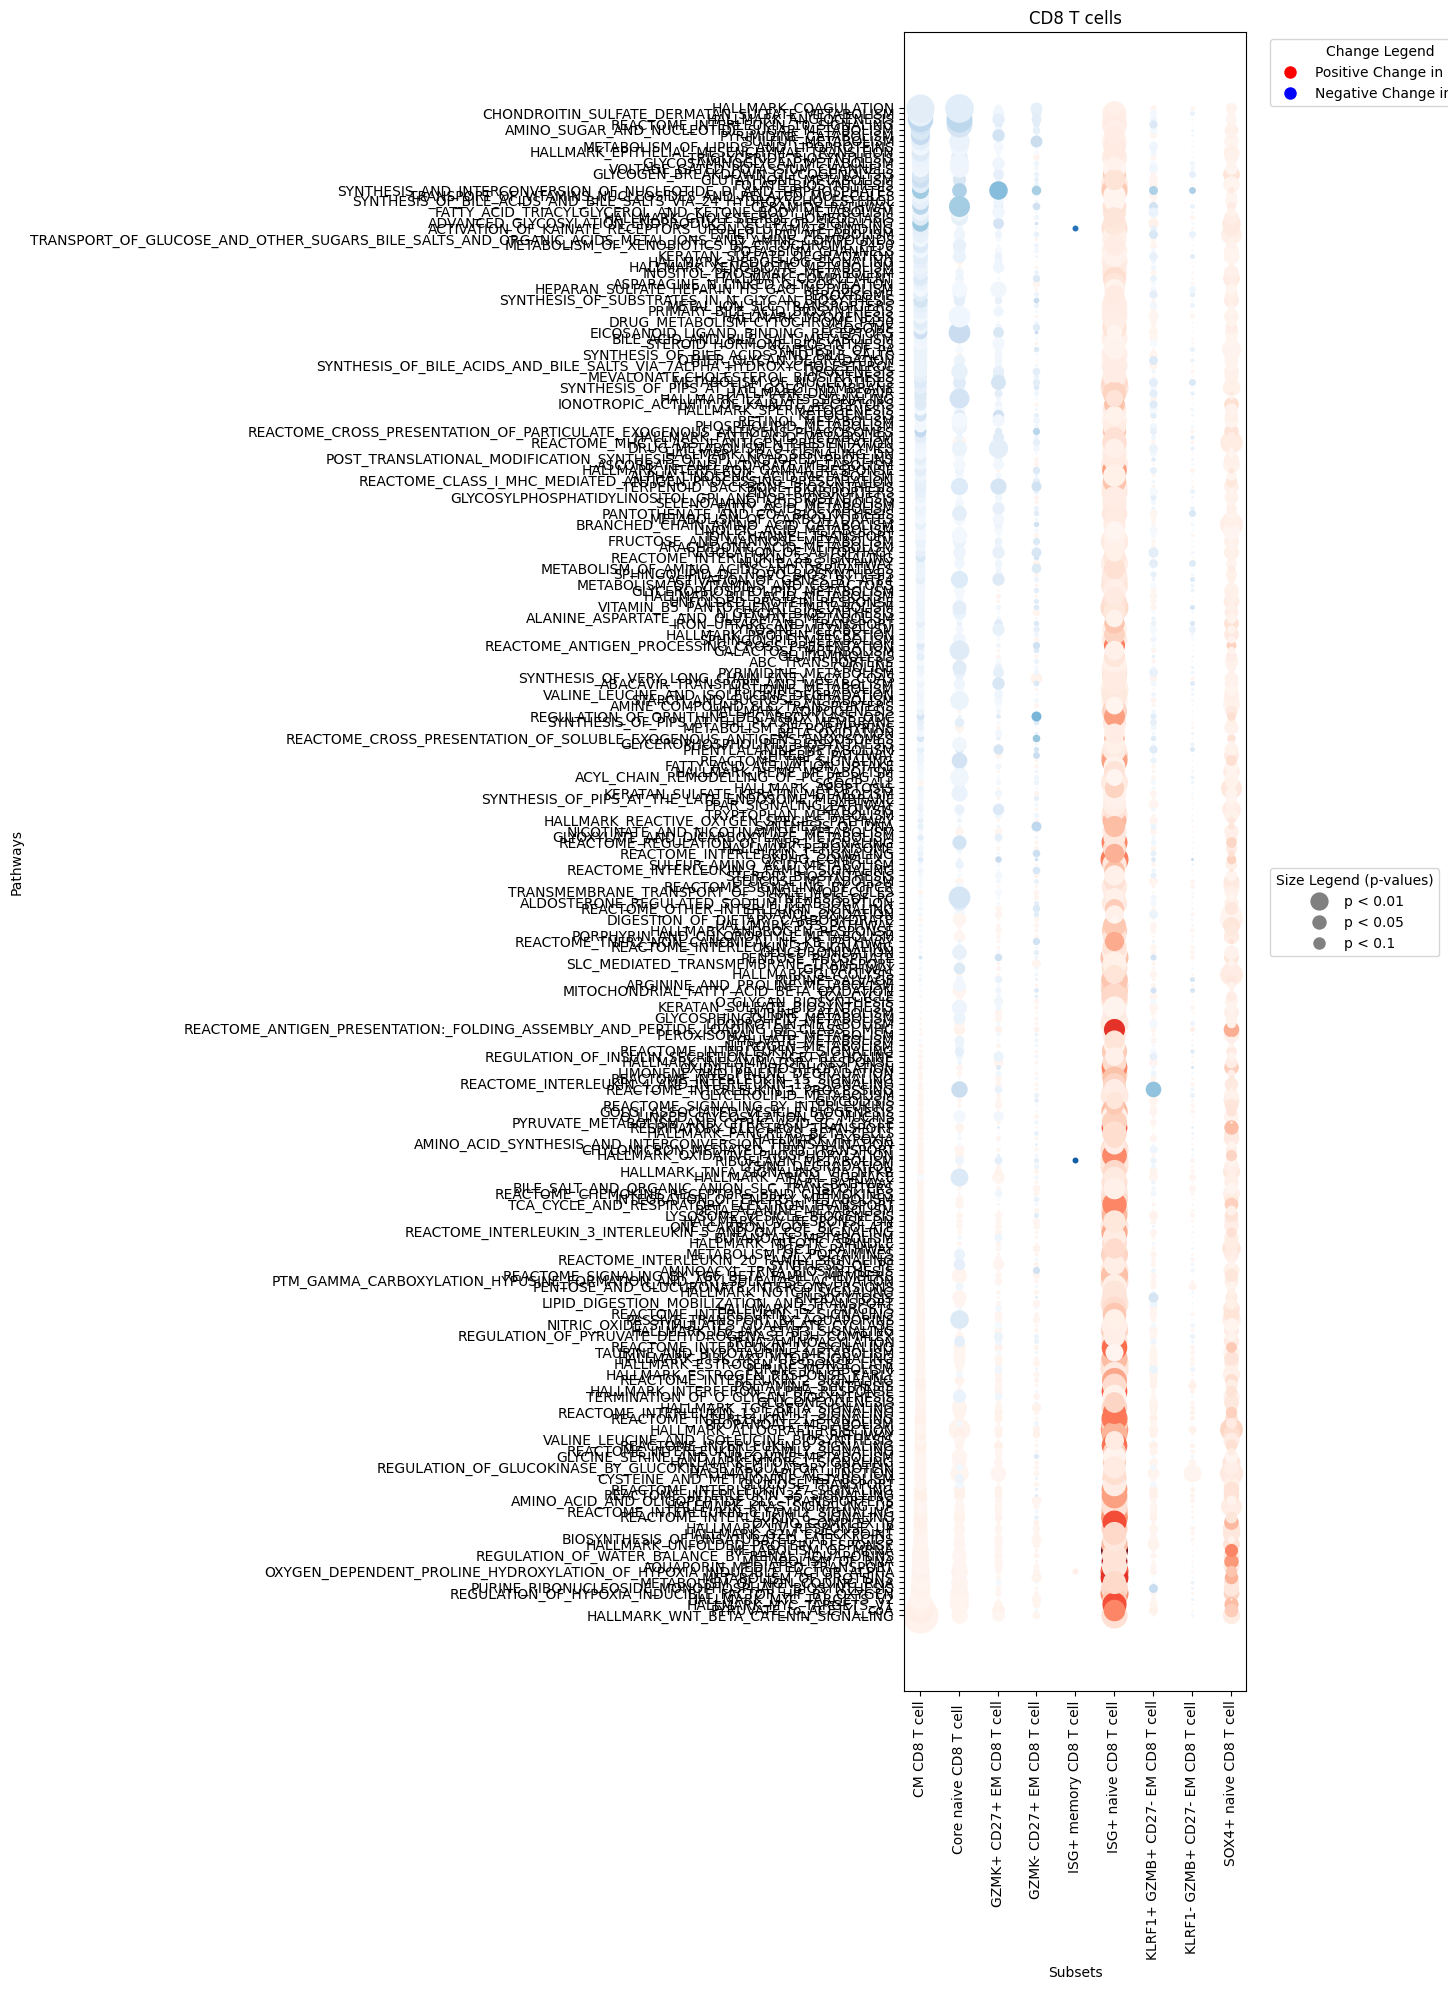

In [74]:
plot_ann_data(Naive_mem_CD8, 'AIFI_L3', 'cohort.cohortGuid', 'BR2', 'wilcoxon', 'CD8 T cells', fig_size=(15, 20))

### Tregs

In [234]:
Tregs = adata2[adata2.obs['AIFI_L2'].isin(['Treg'])]

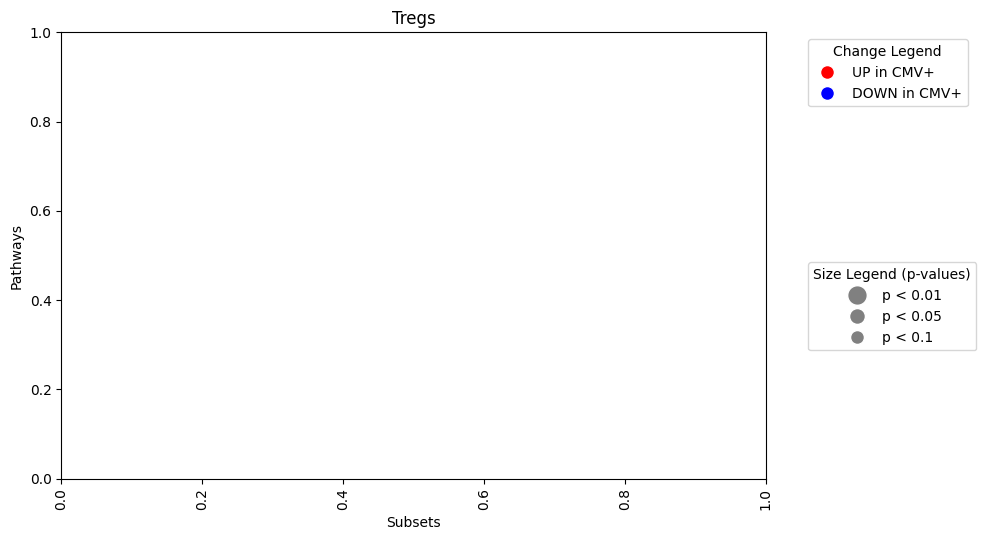

In [235]:
plot_ann_data(Tregs, 'AIFI_L3', 'CMV.IgG.Serology.Result.Interpretation', 'Negative', 'wilcoxon', 'Tregs', fig_size=(10, 5.5))

### Gamma Delta T cell

In [236]:
gdT = adata2[adata2.obs['AIFI_L2'].isin(['gdT'])]

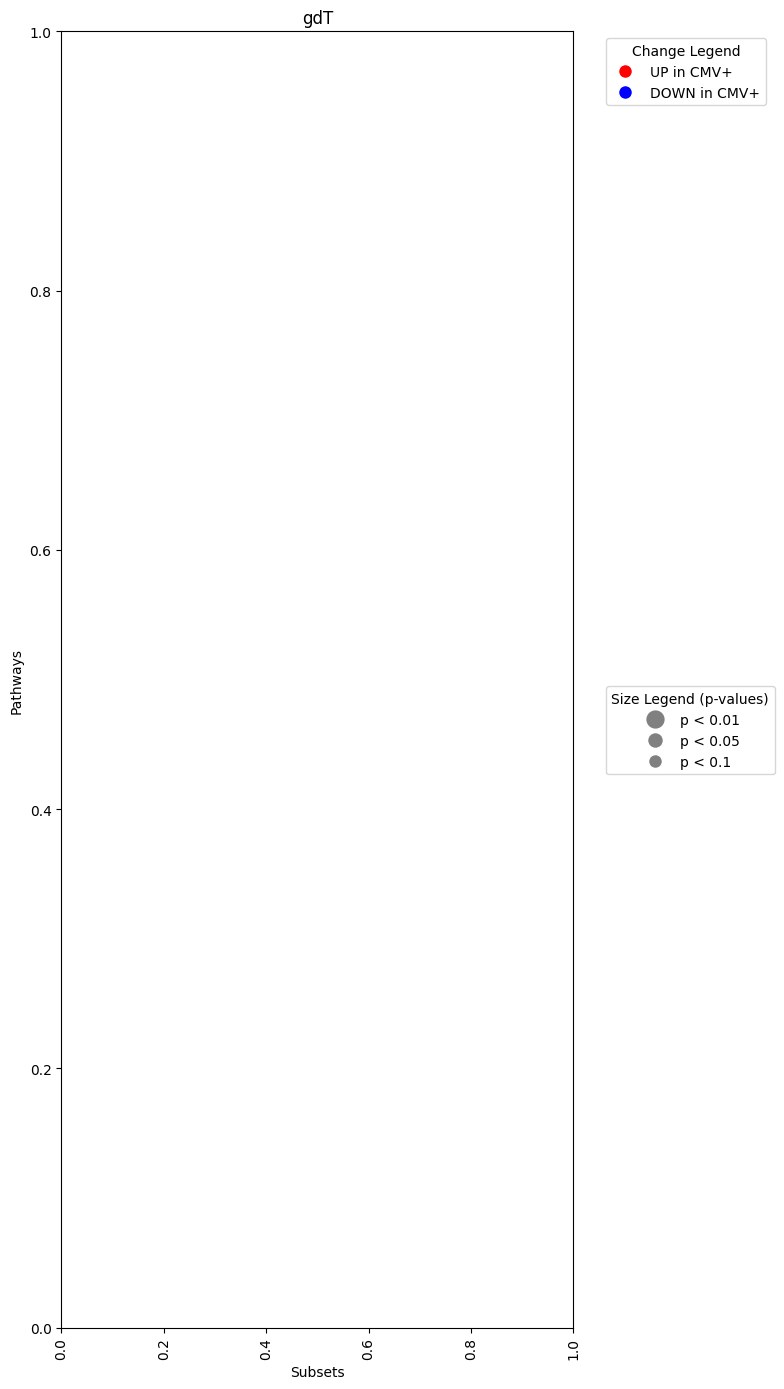

In [237]:
plot_ann_data(gdT, 'AIFI_L3', 'CMV.IgG.Serology.Result.Interpretation', 'Negative', 'wilcoxon', 'gdT', fig_size=(8, 14))

### Other T cells

In [238]:
other_t_cells = adata2[adata2.obs['AIFI_L2'].isin(['DN T cell', 'Proliferating T cell', 'CD8aa', 'MAIT'])]

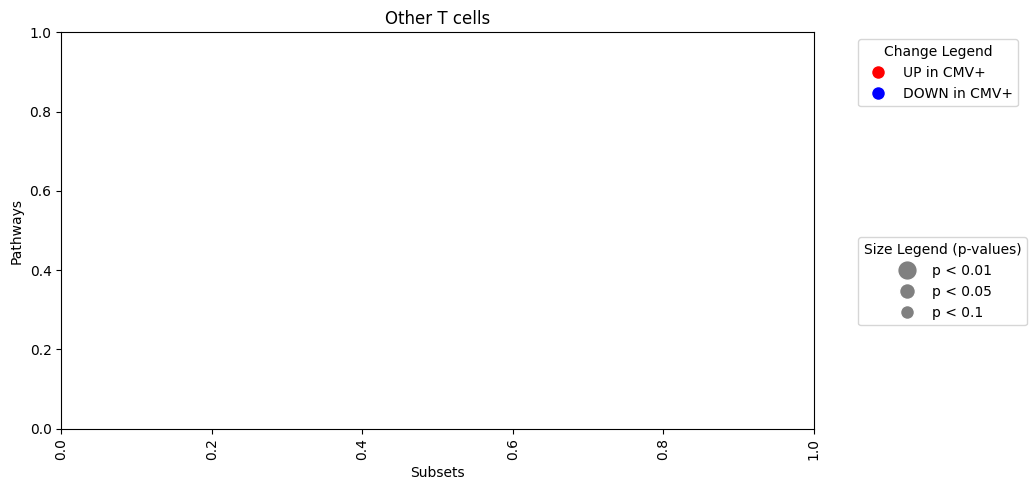

In [239]:
plot_ann_data(other_t_cells, 'AIFI_L3', 'CMV.IgG.Serology.Result.Interpretation', 'Negative', 'wilcoxon', 'Other T cells', fig_size=(10.5, 5))

# B cell flu analysis Yr 1 Day 0 vs day 7

In [4]:
%%time
B_cell_flu=sc.read_h5ad("/home/jupyter/formal_BRIanalysis/DEG_Mehul/for_flu_br1vsbr2.h5ad")

CPU times: user 19.8 s, sys: 1min 2s, total: 1min 22s
Wall time: 7min 32s


In [48]:
B_cell_flu

AnnData object with n_obs × n_vars = 3093549 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'subject.biologicalSex', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 'sample.visitDetails', 'subject.birthYear', 'CMV.IgG.Serology.Result.Interpretation', 'BMI', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3', 'AIFI_L3.5', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'

In [49]:
B_cell_flu.raw = B_cell_flu

In [50]:
B_cells = B_cell_flu[B_cell_flu.obs['AIFI_L3'].isin(['CD27- effector B cell', 'CD27+ effector B cell', 'Core naive B cell', 'Core memory B cell', 'Plasma cell', 'ISG+ naive B cell', 'Transitional B cell', 'Early memory B cell', 'Type 2 polarized memory B cell', 'CD95 memory B cell', 'Activated memory B cell'])]

In [51]:
B_cells

View of AnnData object with n_obs × n_vars = 271900 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'subject.biologicalSex', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 'sample.visitDetails', 'subject.birthYear', 'CMV.IgG.Serology.Result.Interpretation', 'BMI', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3', 'AIFI_L3.5', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'

In [52]:
## code to convert GMT to a file that can be used by decoupler

def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

In [53]:
reac_hll_metab = gmt_to_decoupler("/home/jupyter/formal_BRIanalysis/Reactome_hallmark_metabolism_mig.gmt")

In [54]:
unique_categories_AIFI_L3 = B_cells.obs['AIFI_L3'].unique()
print(unique_categories_AIFI_L3)

['CD95 memory B cell', 'Transitional B cell', 'Core memory B cell', 'Activated memory B cell', 'CD27- effector B cell', ..., 'Plasma cell', 'CD27+ effector B cell', 'Core naive B cell', 'Early memory B cell', 'Type 2 polarized memory B cell']
Length: 11
Categories (11, object): ['Activated memory B cell', 'CD27+ effector B cell', 'CD27- effector B cell', 'CD95 memory B cell', ..., 'ISG+ naive B cell', 'Plasma cell', 'Transitional B cell', 'Type 2 polarized memory B cell']


In [55]:
B_cells.raw

In [56]:
%%time
dc.run_aucell(
    B_cells,
    reac_hll_metab,
    source="geneset",
    target="genesymbol",
    use_raw=True,
)

CPU times: user 2h 54min 42s, sys: 17min 28s, total: 3h 12min 11s
Wall time: 12min 46s


In [57]:
B_cells.obsm["aucell_estimate"]

source                            ABACAVIR_TRANSPORT_AND_METABOLISM  \
cfa6417648b611ea8957bafe6d70929e                           0.000000   
cfad979648b611ea8957bafe6d70929e                           0.000000   
cfc2364248b611ea8957bafe6d70929e                           0.000000   
70a8e30448b611eaa65d9e7d578d66f2                           0.000000   
70aff80648b611eaa65d9e7d578d66f2                           0.000000   
...                                                             ...   
eda3a19a2b8711ecaa1b721ae5eba729                           0.004713   
eda6c0502b8711ecaa1b721ae5eba729                           0.000000   
edab9cc42b8711ecaa1b721ae5eba729                           0.000000   
edb4ea2c2b8711ecaa1b721ae5eba729                           0.035039   
91fc2816286311ecabc39e0459bddc54                           0.000000   

source                            ABC_TRANSPORTERS  \
cfa6417648b611ea8957bafe6d70929e          0.010879   
cfad979648b611ea8957bafe6d70929e          0.008007   
cfc2364248b611ea8957bafe6d70929e          0.000000   
70a8e30448b611eaa65d9e7d578d66f2          0.000000   
70aff80648b611eaa65d9e7d578d66f2          0.012751   
...                                            ...   
eda3a19a2b8711ecaa1b721ae5eba729          0.026559   
eda6c0502b8711ecaa1b721ae5eba729          0.001927   
edab9cc42b8711ecaa1b721ae5eba729          0.000000   
edb4ea2c2b8711ecaa1b721ae5eba729          0.018626   
91fc2816286311ecabc39e0459bddc54          0.038995   

source                            ACTIVATION_OF_GENES_BY_ATF4  \
cfa6417648b611ea8957bafe6d70929e                     0.042843   
cfad979648b611ea8957bafe6d70929e                     0.086117   
cfc2364248b611ea8957bafe6d70929e                     0.028047   
70a8e30448b611eaa65d9e7d578d66f2                     0.032608   
70aff80648b611eaa65d9e7d578d66f2                     0.058716   
...                                                       ...   
eda3a19a2b8711ecaa1b721ae5eba729                     0.010091   
eda6c0502b8711ecaa1b721ae5eba729                     0.047511   
edab9cc42b8711ecaa1b721ae5eba729                     0.054263   
edb4ea2c2b8711ecaa1b721ae5eba729                     0.018674   
91fc2816286311ecabc39e0459bddc54                     0.043238   

source                            ACTIVATION_OF_KAINATE_RECEPTORS_UPON_GLUTAMATE_BINDING  \
cfa6417648b611ea8957bafe6d70929e                                           0.050081        
cfad979648b611ea8957bafe6d70929e                                           0.030257        
cfc2364248b611ea8957bafe6d70929e                                           0.021076        
70a8e30448b611eaa65d9e7d578d66f2                                           0.083599        
70aff80648b611eaa65d9e7d578d66f2                                           0.099249        
...                                                                             ...        
eda3a19a2b8711ecaa1b721ae5eba729                                           0.045412        
eda6c0502b8711ecaa1b721ae5eba729                                           0.051724        
edab9cc42b8711ecaa1b721ae5eba729                                           0.028562        
edb4ea2c2b8711ecaa1b721ae5eba729                                           0.018728        
91fc2816286311ecabc39e0459bddc54                                           0.078590        

source                            ACYL_CHAIN_REMODELLING_OF_PC_PE_PG_PS  \
cfa6417648b611ea8957bafe6d70929e                               0.032680   
cfad979648b611ea8957bafe6d70929e                               0.037779   
cfc2364248b611ea8957bafe6d70929e                               0.033326   
70a8e30448b611eaa65d9e7d578d66f2                               0.003448   
70aff80648b611eaa65d9e7d578d66f2                               0.030920   
...                                                                 ...   
eda3a19a2b8711ecaa1b721ae5eba729                               0.000000   
eda6c0502b87

In [58]:
B_cells.write_h5ad('/home/jupyter/formal_BRIanalysis/B_cell_flu_AUCELL.h5ad')

### Read enrichment stats for B cell flu 

In [59]:
%%time
adata=sc.read_h5ad("/home/jupyter/formal_BRIanalysis/B_cell_flu_AUCELL.h5ad")

CPU times: user 2.35 s, sys: 3.92 s, total: 6.27 s
Wall time: 6.27 s


In [169]:
adata

AnnData object with n_obs × n_vars = 271900 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'subject.biologicalSex', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 'sample.visitDetails', 'subject.birthYear', 'CMV.IgG.Serology.Result.Interpretation', 'BMI', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3', 'AIFI_L3.5', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    obsm: 'aucell_estimate'

In [170]:
# Convert aucell_estimate to a DataFrame
aucell_df = pd.DataFrame(adata.obsm['aucell_estimate'], index=adata.obs.index)

# Ensure all values in aucell_df are numeric
aucell_df = aucell_df.apply(pd.to_numeric, errors='coerce')

# Merge aucell_df with only the necessary columns from adata.obs for grouping
necessary_columns = ['subject.subjectGuid', 'sample.visitName', 'AIFI_L3']
merged_data = adata.obs[necessary_columns].join(aucell_df)
grouped_data = merged_data.groupby(['subject.subjectGuid', 'sample.visitName', 'AIFI_L3']).mean()

# Create mappings for 'cohort.cohortGuid', 'AIFI_L2', and 'AIFI_L3'
cohort_mapping = adata.obs[['subject.subjectGuid', 'cohort.cohortGuid']].drop_duplicates().set_index('subject.subjectGuid')['cohort.cohortGuid'].to_dict()
CMV_mapping = adata.obs[['subject.subjectGuid', 'CMV.IgG.Serology.Result.Interpretation']].drop_duplicates().set_index('subject.subjectGuid')['CMV.IgG.Serology.Result.Interpretation'].to_dict()

# Add 'cohort.cohortGuid', 'CMV', 'timepoint' to the grouped_data
grouped_data['cohort.cohortGuid'] = grouped_data.index.get_level_values('subject.subjectGuid').map(cohort_mapping)
grouped_data['CMV.IgG.Serology.Result.Interpretation'] = grouped_data.index.get_level_values('subject.subjectGuid').map(CMV_mapping)

# Resetting index to make it a standard DataFrame
result_df = grouped_data.reset_index()

# Reorder columns to put 'cohort.cohortGuid', 'AIFI_L2', and 'AIFI_L3' first
cols = ['cohort.cohortGuid', 'CMV.IgG.Serology.Result.Interpretation'] + [col for col in result_df.columns if col not in ['cohort.cohortGuid', 'CMV.IgG.Serology.Result.Interpretation']]
result_df = result_df[cols]

In [171]:
# split cat and num
obs_data = result_df.iloc[:, :5]
X_data = result_df.iloc[:, 5:]

# Create an AnnData object
adata1 = ad.AnnData(X=X_data)
adata1.obs = obs_data

#make a NaN score into 0
adata1.X[np.isnan(adata1.X)] = 0

#set rownames as subjectID
adata1.obs_names = adata1.obs['subject.subjectGuid']

### Function for wilcoxon's analysis and plotting

In [172]:
def plot_ann_data(ann_data, subset_column, groupby_column, reference, method, title, fig_size=(12, 10)):
    all_df_dataframes = []
    all_significant_markers = []

    for category in ann_data.obs[subset_column].unique():
        subset = ann_data[ann_data.obs[subset_column] == category].copy()
        if subset.n_obs > 0:
            df = dc.rank_sources_groups(subset, groupby=groupby_column, reference=reference, method=method)
            df['subset'] = category
            all_df_dataframes.append(df)
            significant_markers = df[df['pvals_adj'] < 0.05]['names'].tolist() #change to pvals if u like
            all_significant_markers.extend(significant_markers)
        else:
            print(f"No observations found for category {category}. Skipping.")

    all_significant_markers = list(set(all_significant_markers))
    combined_df = pd.concat(all_df_dataframes)
    combined_df = combined_df[combined_df['names'].isin(all_significant_markers)]
    combined_df['dot_size'] = -np.log10(combined_df['pvals_adj'])

    def gradient_color_mapping(value, min_val, max_val, cmap_name):
        cmap = cm.get_cmap(cmap_name)
        norm_value = (value - min_val) / (max_val - min_val)
        return cmap(norm_value)

    min_change, max_change = combined_df['meanchange'].min(), combined_df['meanchange'].max()
    combined_df['custom_color'] = combined_df['meanchange'].apply(
        lambda x: gradient_color_mapping(x, min_change, 0, 'Blues_r') if x < 0 else gradient_color_mapping(x, 0, max_change, 'Reds')
    )

    plt.figure(figsize=fig_size)
    for _, row in combined_df.iterrows():
        plt.scatter(row['subset'], row['names'], s=row['dot_size']*100, color=row['custom_color'])
#        plt.ylim(bottom= -0.45, top= 1.5) <- aesthetic modification

    plt.xlabel('Subsets')
    plt.ylabel('Pathways')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.grid(False)
    
    color_legend_labels = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='UP in BR1'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='DOWN in BR1')
    ]

    size_legend_labels = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=np.sqrt(-np.log10(0.01))*10, label='p < 0.01'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=np.sqrt(-np.log10(0.05))*10, label='p < 0.05'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=np.sqrt(-np.log10(0.1))*10, label='p < 0.1')
    ]

    first_legend = plt.legend(handles=color_legend_labels, title='Change Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax = plt.gca()
    ax.add_artist(first_legend)
    plt.legend(handles=size_legend_labels, title='Size Legend (p-values)', bbox_to_anchor=(1.05, 0.5), loc='upper left')

    plt.tight_layout()
    #plt.savefig(f"Pathway_analysis/CMV+ vs CMV- in BR2/{title}.jpg")
    plt.show()

In [173]:
def sig_pathways(ann_data, subset_column, groupby_column, reference, method):
    all_df_dataframes = []
    all_significant_markers = []

    for category in ann_data.obs[subset_column].unique():
        subset = ann_data[ann_data.obs[subset_column] == category].copy()
        if subset.n_obs > 0:
            df = dc.rank_sources_groups(subset, groupby=groupby_column, reference=reference, method=method)
            df['subset'] = category
            all_df_dataframes.append(df)
            significant_markers = df[df['pvals_adj'] < 0.05]['names'].tolist()
            all_significant_markers.extend(significant_markers)
        else:
            print(f"No observations found for category {category}. Skipping.")

    all_significant_markers = list(set(all_significant_markers))
    return all_significant_markers

### BR1 analysis

In [84]:
BR1 = adata1[adata1.obs['cohort.cohortGuid'] == 'BR1'].copy()

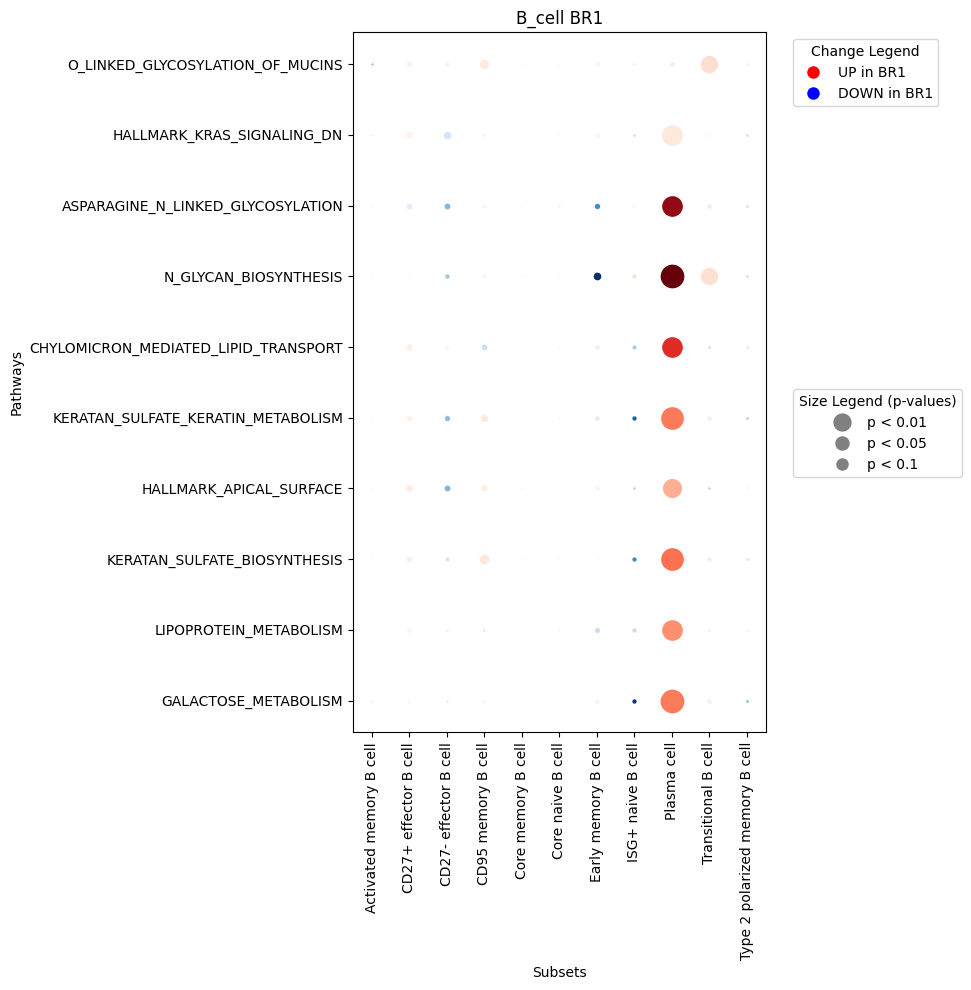

In [88]:
plot_ann_data(BR1, 'AIFI_L3', 'sample.visitName', 'Flu Year 1 Day 0', 'wilcoxon', 'B_cell BR1', fig_size=(10, 10))

### BR2 analysis

In [184]:
BR2 = adata1[adata1.obs['cohort.cohortGuid'] == 'BR2'].copy()

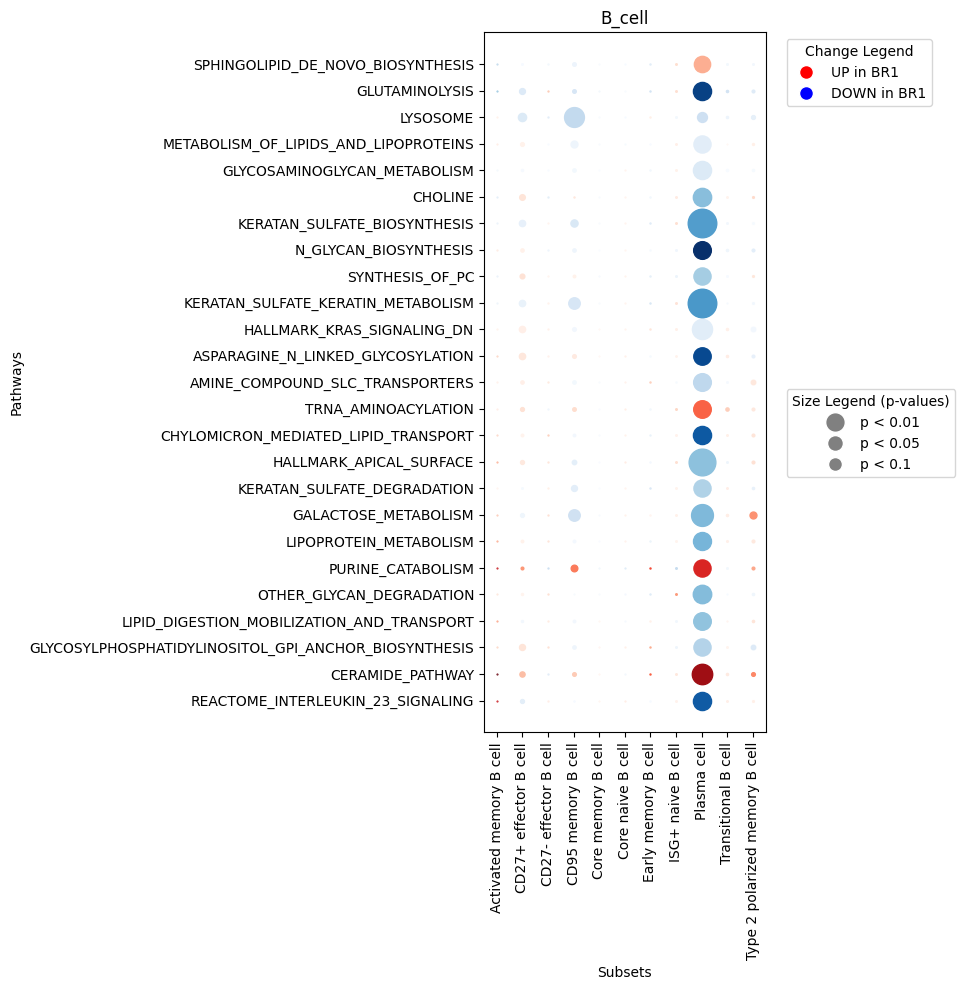

In [185]:
plot_ann_data(BR2, 'AIFI_L3', 'sample.visitName', 'Flu Year 1 Day 7', 'wilcoxon', 'B_cell', fig_size=(10, 10))

### Compare year 1 day 7 between br1 and br2

In [197]:
Day7 = adata1[adata1.obs['sample.visitName'] == 'Flu Year 1 Day 7'].copy()

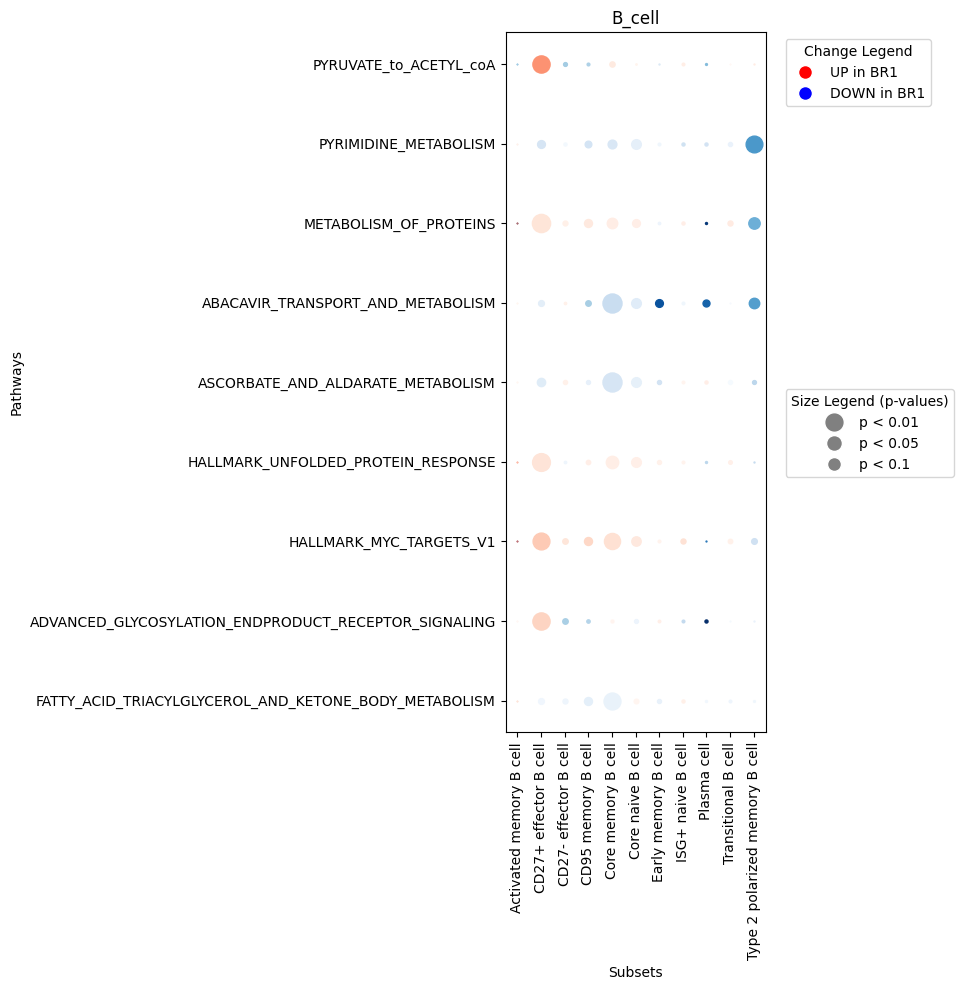

In [198]:
plot_ann_data(Day7, 'AIFI_L3', 'cohort.cohortGuid', 'BR2', 'wilcoxon', 'B_cell', fig_size=(10, 10))

In [304]:
# Specify the geneset you are interested in
specified_geneset = 'REACTOME_INTERLEUKIN_23_SIGNALING'  # Replace with geneset of interest

# Filter the DataFrame for the specified geneset
filtered_df = reac_hll_metab[reac_hll_metab['geneset'] == specified_geneset]

# Extract the genesymbol values as a list
#genesymbol_list = filtered_df['genesymbol'].tolist()
genesymbol_list = ['CNN2', 'IL27RA']

In [305]:
#adata = adata[adata.obs['AIFI_L3'].isin(['CD27- effector B cell', 'CD27+ effector B cell', 'Core naive B cell', 'Core memory B cell', 'Plasma cell', 'ISG+ naive B cell', 'Transitional B cell', 'Early memory B cell', 'Type 2 polarized memory B cell', 'CD95 memory B cell', 'Activated memory B cell'])]
adata2 = adata[adata.obs['AIFI_L3'].isin(['CD27+ effector B cell'])]
adata2 = adata2[adata2.obs['sample.visitName'].isin(['Flu Year 1 Day 7'])]

In [306]:
# Filter the genesymbol list to keep only those present in adata.var_names
filtered_genesymbol_list = [gene for gene in genesymbol_list if gene in adata.var_names]

In [307]:
# Subset the data based on genes of interest
subset_data_genes_of_interest = adata2[:, adata2.var_names.isin(filtered_genesymbol_list)].copy()

# Extract the subject and cohort information
subject_cohort_info = adata2.obs[['subject.subjectGuid', 'cohort.cohortGuid', 'subject.biologicalSex', 'sample.visitName', 'CMV.IgG.Serology.Result.Interpretation']]

# Convert gene expression matrix to pandas DataFrame
expression_df = pd.DataFrame(subset_data_genes_of_interest.X.toarray(), 
                             columns=subset_data_genes_of_interest.var_names, 
                             index=adata2.obs_names)

# Concatenate subject and cohort information with gene expression
full_data = pd.concat([subject_cohort_info, expression_df], axis=1)

def aggregate_data(df, genes_list):
    # For gene expression data, calculate the mean using the provided list of genes
    avg_gene_expression = df[genes_list].mean()
    # Retain the first instance of cohort and other details
    first_cohort = pd.Series(df['cohort.cohortGuid'].iloc[0], index=['cohort.cohortGuid'])
    first_CMV = pd.Series(df['CMV.IgG.Serology.Result.Interpretation'].iloc[0], index=['CMV.IgG.Serology.Result.Interpretation'])
    first_biol_sex = pd.Series(df['subject.biologicalSex'].iloc[0], index=['subject.biologicalSex'])
    first_time_point = pd.Series(df['sample.visitName'].iloc[0], index=['sample.visitName'])
    return pd.concat([first_cohort, first_CMV, first_biol_sex, first_time_point, avg_gene_expression])

# Apply the aggregate function to each group with the current genes_of_interest
aggregated_data = full_data.groupby('subject.subjectGuid').apply(lambda x: aggregate_data(x, filtered_genesymbol_list))

In [308]:
# List of columns to exclude from mean calculation and plotting
exclude_columns = ['cohort.cohortGuid', 'sample.visitName', 'CMV.IgG.Serology.Result.Interpretation', 'subject.biologicalSex']

# Exclude the specified columns and reorder the remaining columns based on their mean expression
cols_ordered = aggregated_data.drop(exclude_columns, axis=1).mean().sort_values(ascending=False).index

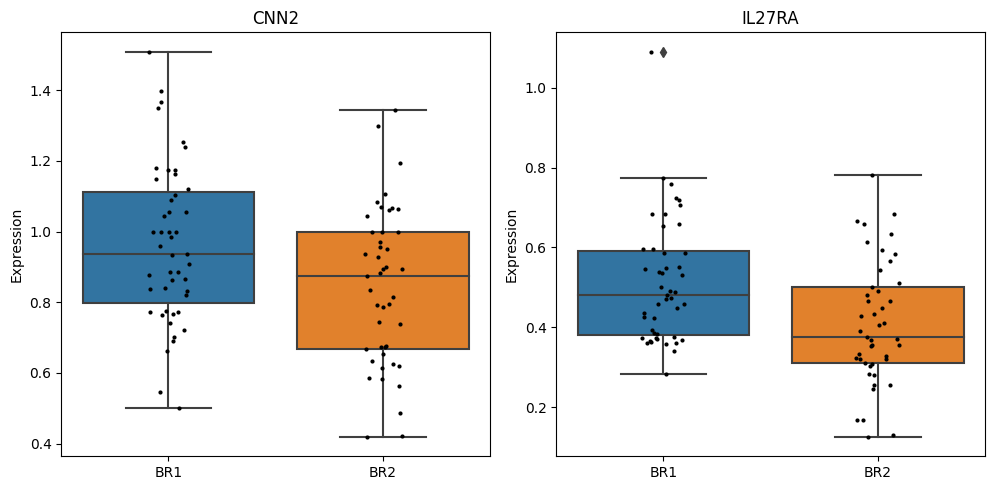

In [309]:
# Reorder the dataframe columns
aggregated_data1 = aggregated_data[['cohort.cohortGuid'] + list(cols_ordered)]

# Set the order of 'cohort.cohortGuid' for plotting
cohort_order = ["BR1", "BR2"]

# Plotting
plt.figure(figsize=(15,5))  # Adjust the size as needed
for i, gene in enumerate(cols_ordered, 1):
    plt.subplot(len(cols_ordered) // 3 + 1, 3, i)  # Adjust the layout as needed
    sns.boxplot(x='cohort.cohortGuid', y=gene, data=aggregated_data1, order=cohort_order)
    sns.stripplot(x='cohort.cohortGuid', y=gene, data=aggregated_data1, order=cohort_order, color='black', size=3)
    plt.title(gene)
    plt.xlabel('')
    plt.ylabel('Expression')

plt.tight_layout()
plt.show()

In [201]:
adata1

AnnData object with n_obs × n_vars = 2024 × 286
    obs: 'cohort.cohortGuid', 'CMV.IgG.Serology.Result.Interpretation', 'subject.subjectGuid', 'sample.visitName', 'AIFI_L3'

In [209]:
# Extract .X attribute from AnnData object
data = adata1.X

# Extract relevant metadata
metadata = adata1.obs[['sample.visitName', 'subject.subjectGuid', 'cohort.cohortGuid']]

# Create a DataFrame combining .X values and metadata
df = pd.DataFrame(data, index=adata1.obs.index, columns=adata1.var.index)
df = pd.concat([df, metadata], axis=1)

# Melt the DataFrame to have 'sample.visitName' and 'cohort.cohortGuid' as categorical variables
melted_df = df.melt(id_vars=['sample.visitName', 'subject.subjectGuid', 'cohort.cohortGuid'], var_name='Feature', value_name='X')

In [210]:
melted_df

sample.visitName subject.subjectGuid cohort.cohortGuid  \
0       Flu Year 1 Day 0              BR1001               BR1   
1       Flu Year 1 Day 0              BR1001               BR1   
2       Flu Year 1 Day 0              BR1001               BR1   
3       Flu Year 1 Day 0              BR1001               BR1   
4       Flu Year 1 Day 0              BR1001               BR1   
...                  ...                 ...               ...   
578859  Flu Year 1 Day 7              BR2053               BR2   
578860  Flu Year 1 Day 7              BR2053               BR2   
578861  Flu Year 1 Day 7              BR2053               BR2   
578862  Flu Year 1 Day 7              BR2053               BR2   
578863  Flu Year 1 Day 7              BR2053               BR2   

                                  Feature         X  
0       ABACAVIR_TRANSPORT_AND_METABOLISM  0.024435  
1       ABACAVIR_TRANSPORT_AND_METABOLISM  0.020762  
2       ABACAVIR_TRANSPORT_AND_METABOLISM  0.023968  
3       ABACAVIR_TRANSPORT_AND_METABOLISM  0.022391  
4       ABACAVIR_TRANSPORT_AND_METABOLISM  0.017184  
...                                   ...       ...  
578859                  ZINC_TRANSPORTERS  0.018263  
578860                  ZINC_TRANSPORTERS  0.011758  
578861                  ZINC_TRANSPORTERS  0.005537  
578862                  ZINC_TRANSPORTERS  0.018878  
578863                  ZINC_TRANSPORTERS  0.009759  

[578864 rows x 5 columns]

In [310]:
mean_values = melted_df.groupby(['sample.visitName', 'subject.subjectGuid', 'cohort.cohortGuid', 'Feature'])['X'].mean().reset_index()

In [312]:
filtered_means = mean_values[(mean_values['Feature'].str.startswith('HALLMARK_')) | (mean_values['Feature'].str.startswith('REACTOME_'))]

In [313]:
filtered_means

sample.visitName subject.subjectGuid cohort.cohortGuid  \
66      Flu Year 1 Day 0              BR1001               BR1   
67      Flu Year 1 Day 0              BR1001               BR1   
68      Flu Year 1 Day 0              BR1001               BR1   
69      Flu Year 1 Day 0              BR1001               BR1   
70      Flu Year 1 Day 0              BR1001               BR1   
...                  ...                 ...               ...   
105189  Flu Year 1 Day 7              BR2053               BR2   
105190  Flu Year 1 Day 7              BR2053               BR2   
105191  Flu Year 1 Day 7              BR2053               BR2   
105192  Flu Year 1 Day 7              BR2053               BR2   
105193  Flu Year 1 Day 7              BR2053               BR2   

                                              Feature         X  
66                              HALLMARK_ADIPOGENESIS  0.061620  
67                       HALLMARK_ALLOGRAFT_REJECTION  0.131595  
68                         HALLMARK_ANDROGEN_RESPONSE  0.076492  
69                              HALLMARK_ANGIOGENESIS  0.017905  
70                           HALLMARK_APICAL_JUNCTION  0.050323  
...                                               ...       ...  
105189                     REACTOME_SIGNALING_BY_GPCR  0.021771  
105190             REACTOME_SIGNALING_BY_INTERLEUKINS  0.081664  
105191  REACTOME_SIGNALING_BY_TGF_BETA_FAMILY_MEMBERS  0.086044  
105192     REACTOME_TNFR2_NON_CANONICAL_NF_KB_PATHWAY  0.139542  
105193                         REACTOME_TNF_SIGNALING  0.137092  

[32016 rows x 5 columns]